In [17]:
import os
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
from torchvision.transforms import autoaugment, InterpolationMode
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold, train_test_split
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.nn.parallel import DataParallel
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score

In [18]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class RetainRandomStateSettings:
    def __init__(self, tolerance: float = 1e-2):
        self.retention = tolerance
        self.__last_loss = float('inf')
        self.__initial_epoch_rng_state = torch.get_rng_state()

    def step(self):
        pass

class TolerateLossEpochsPeriod(RetainRandomStateSettings):
    def __init__(self, tolerance: float = 1e-2):
        super().__init__(tolerance)
        self.step = self.__update_epoch_at_first

    def __update_epoch_normally(self, loss):
        super().step()
        if abs(self.__last_loss - loss) < self.retention:
            print(f'|{self.__last_loss} - {loss}| < {self.retention}')
            print('new rng')
            self.__initial_epoch_rng_state = torch.get_rng_state()
        self.__last_loss = loss
        torch.set_rng_state(self.__initial_epoch_rng_state)

    def __update_epoch_at_first(self, loss):
        self.__initial_epoch_rng_state = torch.get_rng_state()
        self.step = self.__update_epoch_next
        
    def __update_epoch_next(self, loss):
        super().step()
        self.__last_loss = loss
        torch.set_rng_state(self.__initial_epoch_rng_state)
        self.step = self.__update_epoch_normally

class MyDataset(Dataset):
    def __init__(self, imgs, labels, transform=None, target_transform=None, augment_times=1, tolerance: float = 1e-2):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.augment_times = augment_times
        self.loss_tolerance = TolerateLossEpochsPeriod(tolerance)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        path = self.imgs[idx]
        target = self.labels[idx]
        try:
            img = Image.open(path).convert('RGB')
            if not isinstance(img, Image.Image):
                raise TypeError(f"Image at index {idx} is of type {type(img)}, expected PIL Image.")
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return None, None
        
        if self.transform:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def update_loss(self, loss):
        self.loss_tolerance.step(loss)


In [19]:
class ExceptableTrivialAugmentWide(autoaugment.TrivialAugmentWide):
    def __init__(
        self,
        num_magnitude_bins: int = 31,
        interpolation: InterpolationMode = InterpolationMode.NEAREST,
        fill = None,
        excepting = {}
    ) -> None:
        super().__init__(num_magnitude_bins,interpolation,fill)
        self.excepting = excepting

    def _augmentation_space(self, num_bins: int):
        result = super()._augmentation_space(num_bins)
        return {key: value for key, value in result.items() if key not in self.excepting}

In [20]:
num_classes = 5       # 输出的类别总数
patch_size = 16       # 对输入的图像进行切分的大小，表示切分后每个小块的大小
hidden_size = 512     # 隐藏层的维度大小
num_layers = 10       # 编码器中的层数
dropout_prob = 0.25    # Dropout操作的概率，用于防止过拟合
batch_size =128     # 批次大小
num_epochs = 75    # 训练轮数
learning_rate = 1e-4  # 学习率
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [21]:
import torch
import torch.nn.functional as F
import numpy as np
from torch import nn
import warnings


_BATCH_NORM_PARAMS = {
    'eps': 0.001,
    'momentum': 0.9997,
    'affine': True,
}


def autopad(k, p=None, d=1):  # kernel, padding, dilation
    # Pad to 'same' shape outputs
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k,
                                          int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

def fixed_padding(inputs, kernel_size, rate=1):
    """Pads the input along the spatial dimensions independently of input size.
    
    Args:
        inputs: A tensor of size [batch, height_in, width_in, channels].
        kernel_size: The kernel to be used in the conv2d or max_pool2d 
            operation. Should be a positive integer.
        rate: An integer, rate for atrous convolution.
        
    Returns:
        padded_inputs: A tensor of size [batch, height_out, width_out, 
            channels] with the input, either intact (if kernel_size == 1) or 
            padded (if kernel_size > 1).
    """
    kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = torch.nn.functional.pad(
        inputs, pad=(pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class SeparableConv2d(torch.nn.Module):
    """Strided 2-D separable convolution with 'SAME' padding."""
    
    def __init__(self, in_channels, out_channels, kernel_size=1, 
                 stride=1, groups=1, depth_multiplier=1, rate=1, use_explicit_padding=True, 
                 activation_func=None, **kwargs):
        """Constructor.
        
        If stride > 1 and use_explicit_padding is True, then we do explicit
        zero-padding, followed by conv2d with 'VALID' padding.
        
        Args:
            in_channels: An integer, the number of input filters.
            out_channels: An integer, the number of output filters.
            kernel_size: An integer with the kernel_size of the filters.
            depth_multiplier: The number of depthwise convolution output
                channels for each input channel. The total number of depthwise
                convolution output channels will be equal to `num_filters_in *
                depth_multiplier`.
            stride: An integer, the output stride.
            rate: An integer, rate for atrous convolution.
            use_explicit_padding: If True, use explicit padding to make the
                model fully compatible with the open source version, otherwise
                use the nattive Pytorch 'SAME' padding.
            activation_func: Activation function.
            **kwargs: Additional keyword arguments to pass to torch.nn.Conv2d.
        """
        super(SeparableConv2d, self).__init__()
        self.__kernel_size = kernel_size
        self.__rate = rate
        self.__without_padding = stride == 1 or not use_explicit_padding
        
        out_channels_depthwise = in_channels * depth_multiplier
        if self.__without_padding:
            # Separable convolution for padding 'SAME'
            # Here, we assume that floor(padding) = padding
            padding = (kernel_size - 1) * rate // 2
            self.conv_depthwise = torch.nn.Conv2d(in_channels, 
                                                   out_channels_depthwise,
                                                   kernel_size=kernel_size, 
                                                   stride=stride, 
                                                   dilation=rate,
                                                   groups=in_channels,
                                                   padding=padding,
                                                   bias=False,
                                                   **kwargs)
        else:
            # Separable convolution for padding 'VALID'
            self.conv_depthwise = torch.nn.Conv2d(in_channels,
                                                   out_channels_depthwise,
                                                   kernel_size=kernel_size, 
                                                   stride=stride,
                                                   dilation=rate,
                                                   groups=in_channels,
                                                   bias=False,
                                                   **kwargs)
        self.batch_norm_depthwise = torch.nn.BatchNorm2d(
            out_channels_depthwise, **_BATCH_NORM_PARAMS)
        self.conv_pointwise = torch.nn.Conv2d(out_channels_depthwise,
                                               out_channels,
                                               kernel_size=1, 
                                               stride=1,
                                               groups=groups,
                                               bias=False,
                                               **kwargs)
        self.batch_norm_pointwise = torch.nn.BatchNorm2d(
            out_channels, **_BATCH_NORM_PARAMS)
        self.activation_func = activation_func
    
    def forward(self, x):
        """
        Input: [batch, height_in, width_in, channels]
        Output: [batch, height_out, width_out, channels]
        """
        if not self.__without_padding:
            x = fixed_padding(x, self.__kernel_size, self.__rate)
        x = self.conv_depthwise(x)
        x = self.batch_norm_depthwise(x)
        if self.activation_func is not None:
            x = self.activation_func(x)
        x = self.conv_pointwise(x)
        x = self.batch_norm_pointwise(x)
        if self.activation_func is not None:
            x = self.activation_func(x)
        return x


class Focus(nn.Module):
    # Focus wh information into c-space
    # ch_in, ch_out, kernel, stride, padding, groups
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, n=1, act=True):
        super().__init__()
        self.n = n
        self.conv = None
        expected_in_channels = c1 * (4**n)
        if expected_in_channels != c2:
            self.conv = Conv(expected_in_channels, c2, k, s, p, g, act=act)

    def forward(self, x):  # x(b,c,w,h) -> y(b,c*4^n,w/2^n,h/2^n)
        for _ in range(self.n):
            x = torch.cat((x[..., ::2, ::2], x[..., 1::2, ::2],
                          x[..., ::2, 1::2], x[..., 1::2, 1::2]), 1)
        if self.conv is not None:
            x = self.conv(x)
        return x


class Conv(nn.Module):
    # Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(
            k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(
            act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))


class SeparableBottleneck(nn.Module):
    # Standard bottleneck
    # ch_in, ch_out, shortcut, groups, expansion
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = SeparableConv2d(c1, c_, 1, 1)
        self.cv2 = SeparableConv2d(c_, c2, 3, 1, groups=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class SeparableC3(nn.Module):
    # CSP Bottleneck with 3 convolutions
    # ch_in, ch_out, number, shortcut, groups, expansion
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = SeparableConv2d(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = SeparableConv2d(2 * c_, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.Sequential(
            *(SeparableBottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))


class SPPF(nn.Module):
    # Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher
    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            # suppress torch 1.9.0 max_pool2d() warning
            warnings.simplefilter('ignore')
            y1 = self.m(x)
            y2 = self.m(y1)
            return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))


class SingleEncoderModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n: int = 1, has_leading_max_pool: bool = True):
        super(SingleEncoderModule, self).__init__()
        layers: list[nn.Module] = []
        if has_leading_max_pool:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers += [
            Conv(in_channels, out_channels, 3, 1),
            SeparableC3(out_channels, out_channels, n)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x
    
class SPPSingleEncoderModule(SingleEncoderModule):
    def __init__(self, in_channels: int, out_channels: int, n: int = 1, has_leading_max_pool: bool = True):
        super().__init__(in_channels, out_channels, n, has_leading_max_pool)
        layers = list(self.layers.children())
        layers.insert(len(layers)-1,SPPF(out_channels, out_channels))
        self.layers = nn.Sequential(*layers)

class ViTModule(nn.Module):
    def __init__(self, channels_in, channels_out, patch_size, num_layers, num_heads, dropout_prob=0.3):
        super(ViTModule, self).__init__()
        self.channels_out = channels_out
        self.patch_embedding = None
        if channels_in != channels_out:
            self.patch_embedding = nn.Sequential(
                nn.Conv2d(channels_in, channels_out,
                          kernel_size=patch_size, stride=patch_size),
                nn.BatchNorm2d(channels_out),
                nn.GELU(),
                nn.Conv2d(channels_out, channels_out,
                          kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(channels_out),
                nn.GELU()
            )

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=channels_out, nhead=num_heads, dropout=dropout_prob),
            num_layers=num_layers
        )

    def forward(self, x: torch.Tensor):
        if self.patch_embedding is not None:
            x = self.patch_embedding(x)
        b, _, w, h = x.shape
        x = x.flatten(2).permute(2, 0, 1)
        x = self.transformer_encoder(x)

        x = x.permute(1, 2, 0).reshape(b, self.channels_out, w, h)
        return x


class VTCNet(nn.Module):
    def __init__(self, num_classes: int = 1):
        super(VTCNet, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        # self.batch_norm = nn.BatchNorm2d(3)

        #self.focus = Focus(3, 12)
        self.vit = ViTModule(3, 1024, patch_size=16, num_layers=3, num_heads=8)

        self.encoders = nn.Sequential(
            SingleEncoderModule(3, 64, has_leading_max_pool=False),
            SingleEncoderModule(64, 128, 2),
            SingleEncoderModule(128, 256, 3),
            SingleEncoderModule(256, 512),
            SPPSingleEncoderModule(512, 512)
        )

        self.classifier = nn.Sequential(
            nn.Conv2d(512+1024, num_classes, 1 , 1),
            nn.BatchNorm2d(num_classes),
            nn.GELU()
        )
        
        self.avg_pool = nn.AdaptiveMaxPool2d(1)

    def forward(self, x: torch.Tensor):
        x = x.view(-1, *(x.shape[-3:]))
        # x = self.batch_norm(x)
        #x = self.focus(x)
        x = self.pool(x)
        encoded = self.encoders(x)
        x = self.vit(x)
        # x=encoded
        x = torch.concat([x, encoded], dim=1)
        del encoded
        x = self.classifier(x)
        x = self.avg_pool(x).flatten(2)
        x = x.squeeze(dim=2)
        return x

    def save_weights(self, path: str):
        torch.save(self.state_dict(), path)

    def load_weights(self, path: str):
        self.load_state_dict(torch.load(path))


In [22]:
def initialize_weights(model):
    for m in model.modules():
        t = type(m)
        if t is nn.Conv2d:
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif t is nn.BatchNorm2d:
            m.eps = 1e-3
            m.momentum = 0.03
        elif t in [nn.Hardswish, nn.LeakyReLU, nn.ReLU, nn.ReLU6, nn.SiLU]:
            m.inplace = True

In [23]:
import numpy as np
from collections.abc import Iterable
from numpy._typing import DTypeLike

def apply_from_axis(func, arr: np.ndarray, axis = 0, otypes: Iterable[DTypeLike] = ...):
    slices = (slice(None,None,None),)*(axis)
    if len(otypes) > 1:
        return tuple(np.array(item,dtype=otypes[i]) for i,item in enumerate(zip(*[func(arr[slices+(i,)]) for i in range(arr.shape[axis])])))
    else:
        return np.array([func(arr[slices+(i,)]) for i in range(arr.shape[axis])],otypes[0],copy=False)

np.apply_from_axis = apply_from_axis

Fold 1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/75


100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Train Loss: 0.9977885627746582
Train Acc (3077): 65.12837179070523%
------Weighted------
Weighted precision 0.6494247633389265
Weighted recall 0.6512837179070523
Weighted f1-score 0.6487469245582944
------Macro------
Macro precision 0.6498986983910753
Macro recall 0.6517832819144199
Macro f1-score 0.6492592514682037


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.7706712484359741
Val Acc (162): 37.65432098765432%
------Weighted------
Weighted precision 0.21797245963912631
Weighted recall 0.3765432098765432
Weighted f1-score 0.27066033169319553
------Macro------
Macro precision 0.21825174825174826
Macro recall 0.37517106549364615
Macro f1-score 0.27051943108281135
Training Loss: 0.9978, Training Accuracy: 65.13%
Validation Loss: 1.7707, Validation Accuracy: 37.65%
Epoch 2/75


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Train Loss: 0.6058015775680542
Train Acc (3077): 81.89795255118622%
------Weighted------
Weighted precision 0.8185122345735008
Weighted recall 0.8189795255118621
Weighted f1-score 0.8165629123063207
------Macro------
Macro precision 0.8192068063038007
Macro recall 0.8194483660031722
Macro f1-score 0.8171555813426699


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.510164499282837
Val Acc (162): 33.95061728395062%
------Weighted------
Weighted precision 0.1975440437849858
Weighted recall 0.3395061728395062
Weighted f1-score 0.24001759557315114
------Macro------
Macro precision 0.19711438923395447
Macro recall 0.33802541544477027
Macro f1-score 0.23943167943167945
Training Loss: 0.6058, Training Accuracy: 81.90%
Validation Loss: 1.5102, Validation Accuracy: 33.95%
Epoch 3/75


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Train Loss: 0.3633431875705719
Train Acc (3077): 91.3227169320767%
------Weighted------
Weighted precision 0.9130015591443768
Weighted recall 0.913227169320767
Weighted f1-score 0.9126739180238779
------Macro------
Macro precision 0.9132772614714743
Macro recall 0.9135326512832563
Macro f1-score 0.9129708853261643


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


Val Loss: 1.5009989738464355
Val Acc (162): 37.03703703703704%
------Weighted------
Weighted precision 0.5988614800759013
Weighted recall 0.37037037037037035
Weighted f1-score 0.31016539240060015
------Macro------
Macro precision 0.5972422517394055
Macro recall 0.3679130009775171
Macro f1-score 0.30922946633312487
Training Loss: 0.3633, Training Accuracy: 91.32%
Validation Loss: 1.5010, Validation Accuracy: 37.04%
Epoch 4/75


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Train Loss: 0.23682113885879516
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.967858782206979
Weighted recall 0.9678258043548911
Weighted f1-score 0.9676705606062762
------Macro------
Macro precision 0.9678361476457233
Macro recall 0.9680126625690816
Macro f1-score 0.9677547652234143


100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


Val Loss: 1.4357070326805115
Val Acc (162): 43.20987654320987%
------Weighted------
Weighted precision 0.6044627110103301
Weighted recall 0.43209876543209874
Weighted f1-score 0.41000873944291605
------Macro------
Macro precision 0.6047278911564625
Macro recall 0.42946603128054744
Macro f1-score 0.4094105931654788
Training Loss: 0.2368, Training Accuracy: 96.78%
Validation Loss: 1.4357, Validation Accuracy: 43.21%
Epoch 5/75


100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Train Loss: 0.16703289568424226
Train Acc (3077): 98.44003899902502%
------Weighted------
Weighted precision 0.9843639660861286
Weighted recall 0.9844003899902503
Weighted f1-score 0.9843620611438201
------Macro------
Macro precision 0.9844371482375301
Macro recall 0.9844970142058133
Macro f1-score 0.9844471017043158


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


Val Loss: 1.213879644870758
Val Acc (162): 61.72839506172839%
------Weighted------
Weighted precision 0.7231853794353794
Weighted recall 0.6172839506172839
Weighted f1-score 0.6202184954575075
------Macro------
Macro precision 0.725090840532017
Macro recall 0.6151209677419355
Macro f1-score 0.6202212568195595
Training Loss: 0.1670, Training Accuracy: 98.44%
Validation Loss: 1.2139, Validation Accuracy: 61.73%
|0.23682113885879516 - 0.16703289568424226| < 0.07
new rng
Epoch 6/75


100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


Train Loss: 0.4075521814823151
Train Acc (3077): 86.96782580435489%
------Weighted------
Weighted precision 0.8693848967882765
Weighted recall 0.8696782580435489
Weighted f1-score 0.869463002128198
------Macro------
Macro precision 0.8696414542989548
Macro recall 0.8698306686473167
Macro f1-score 0.8696681504768267


100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


Val Loss: 1.0074339509010315
Val Acc (162): 65.4320987654321%
------Weighted------
Weighted precision 0.7240079365079365
Weighted recall 0.654320987654321
Weighted f1-score 0.6365038036275429
------Macro------
Macro precision 0.7259523809523809
Macro recall 0.6500855327468231
Macro f1-score 0.6339859655066409
Training Loss: 0.4076, Training Accuracy: 86.97%
Validation Loss: 1.0074, Validation Accuracy: 65.43%
Epoch 7/75


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Train Loss: 0.1879244738817215
Train Acc (3077): 97.10757231069223%
------Weighted------
Weighted precision 0.9710793559686623
Weighted recall 0.9710757231069224
Weighted f1-score 0.9710402886732891
------Macro------
Macro precision 0.9711090813252733
Macro recall 0.9711421467859134
Macro f1-score 0.971088063912972


100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


Val Loss: 1.0416949391365051
Val Acc (162): 63.58024691358025%
------Weighted------
Weighted precision 0.7187918228405649
Weighted recall 0.6358024691358025
Weighted f1-score 0.6234996237866091
------Macro------
Macro precision 0.7214069944730322
Macro recall 0.6326857282502444
Macro f1-score 0.6223332595995059
Training Loss: 0.1879, Training Accuracy: 97.11%
Validation Loss: 1.0417, Validation Accuracy: 63.58%
Epoch 8/75


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Train Loss: 0.14706447780132292
Train Acc (3077): 98.57003574910627%
------Weighted------
Weighted precision 0.9857937150690586
Weighted recall 0.9857003574910628
Weighted f1-score 0.9857011250918329
------Macro------
Macro precision 0.9858555723238712
Macro recall 0.9858005552492992
Macro f1-score 0.9857824880889133


100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


Val Loss: 0.9136736989021301
Val Acc (162): 70.98765432098766%
------Weighted------
Weighted precision 0.7518538676308989
Weighted recall 0.7098765432098766
Weighted f1-score 0.7021725188391855
------Macro------
Macro precision 0.7535193389616681
Macro recall 0.7065860215053764
Macro f1-score 0.7005194805194804
Training Loss: 0.1471, Training Accuracy: 98.57%
Validation Loss: 0.9137, Validation Accuracy: 70.99%
|0.1879244738817215 - 0.14706447780132292| < 0.07
new rng
Epoch 9/75


100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


Train Loss: 0.29755943655967715
Train Acc (3077): 90.86772830679233%
------Weighted------
Weighted precision 0.9085286558575068
Weighted recall 0.9086772830679233
Weighted f1-score 0.9084578125292271
------Macro------
Macro precision 0.9088283744269688
Macro recall 0.9090331298512714
Macro f1-score 0.9087878160202946


100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


Val Loss: 0.6489264070987701
Val Acc (162): 75.30864197530865%
------Weighted------
Weighted precision 0.7845264140657094
Weighted recall 0.7530864197530864
Weighted f1-score 0.7459414752443074
------Macro------
Macro precision 0.7871585325243862
Macro recall 0.7497922776148583
Macro f1-score 0.7447694753577105
Training Loss: 0.2976, Training Accuracy: 90.87%
Validation Loss: 0.6489, Validation Accuracy: 75.31%
Epoch 10/75


100%|██████████| 25/25 [00:12<00:00,  1.98it/s]


Train Loss: 0.14627781838178636
Train Acc (3077): 97.62755931101722%
------Weighted------
Weighted precision 0.9762486375343327
Weighted recall 0.9762755931101722
Weighted f1-score 0.9762476746209725
------Macro------
Macro precision 0.9762621337819967
Macro recall 0.9763134541911302
Macro f1-score 0.9762735973869996


100%|██████████| 2/2 [00:00<00:00,  4.34it/s]


Val Loss: 0.37644805014133453
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.8917102842730082
Weighted recall 0.8888888888888888
Weighted f1-score 0.8893964619753788
------Macro------
Macro precision 0.8930926779313875
Macro recall 0.8893695014662757
Macro f1-score 0.8903299943165672
Training Loss: 0.1463, Training Accuracy: 97.63%
Validation Loss: 0.3764, Validation Accuracy: 88.89%
Epoch 11/75


100%|██████████| 25/25 [00:12<00:00,  1.98it/s]


Train Loss: 0.09349778175354004
Train Acc (3077): 99.57751056223594%
------Weighted------
Weighted precision 0.9957782359602116
Weighted recall 0.9957751056223595
Weighted f1-score 0.9957758712659529
------Macro------
Macro precision 0.9958258246712909
Macro recall 0.9957988797363383
Macro f1-score 0.9958115443441284


100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


Val Loss: 0.24227233976125717
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9388468156079636
Weighted recall 0.9382716049382716
Weighted f1-score 0.937862712121286
------Macro------
Macro precision 0.9394392111683383
Macro recall 0.9390029325513197
Macro f1-score 0.9385224021757542
Training Loss: 0.0935, Training Accuracy: 99.58%
Validation Loss: 0.2423, Validation Accuracy: 93.83%
|0.14627781838178636 - 0.09349778175354004| < 0.07
new rng
Epoch 12/75


100%|██████████| 25/25 [00:12<00:00,  1.94it/s]


Train Loss: 0.3096382677555084
Train Acc (3077): 92.52518687032824%
------Weighted------
Weighted precision 0.9249728284220169
Weighted recall 0.9252518687032825
Weighted f1-score 0.9250621402746535
------Macro------
Macro precision 0.9250918043394766
Macro recall 0.92543325678604
Macro f1-score 0.9252119181764821


100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


Val Loss: 0.20865105837583542
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9416692602967112
Weighted recall 0.9382716049382716
Weighted f1-score 0.9387768971373519
------Macro------
Macro precision 0.9416603004838299
Macro recall 0.9388257575757576
Macro f1-score 0.9390325413095424
Training Loss: 0.3096, Training Accuracy: 92.53%
Validation Loss: 0.2087, Validation Accuracy: 93.83%
Epoch 13/75


100%|██████████| 25/25 [00:12<00:00,  1.93it/s]


Train Loss: 0.16273578852415085
Train Acc (3077): 98.70003249918751%
------Weighted------
Weighted precision 0.9870411655118266
Weighted recall 0.9870003249918752
Weighted f1-score 0.9869727474427948
------Macro------
Macro precision 0.9869812306128649
Macro recall 0.9870141685557533
Macro f1-score 0.9869503479287249


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Val Loss: 0.23766126483678818
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9203806282659329
Weighted recall 0.9197530864197531
Weighted f1-score 0.9193111554977497
------Macro------
Macro precision 0.9208862821766047
Macro recall 0.9204423264907137
Macro f1-score 0.9199210180889704
Training Loss: 0.1627, Training Accuracy: 98.70%
Validation Loss: 0.2377, Validation Accuracy: 91.98%
Epoch 14/75


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Train Loss: 0.21366609692573546
Train Acc (3077): 95.6776080597985%
------Weighted------
Weighted precision 0.9567225798990027
Weighted recall 0.956776080597985
Weighted f1-score 0.9566758661169514
------Macro------
Macro precision 0.9569921746676897
Macro recall 0.9569461732199083
Macro f1-score 0.9568964965749036


100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


Val Loss: 0.25468859821558
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9334376614469209
Weighted recall 0.9320987654320988
Weighted f1-score 0.930558681212276
------Macro------
Macro precision 0.9333393458393457
Macro recall 0.9325635386119258
Macro f1-score 0.9307778496013789
Training Loss: 0.2137, Training Accuracy: 95.68%
Validation Loss: 0.2547, Validation Accuracy: 93.21%
|0.16273578852415085 - 0.21366609692573546| < 0.07
new rng
Epoch 15/75


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Train Loss: 0.28044581472873686
Train Acc (3077): 92.395190120247%
------Weighted------
Weighted precision 0.9238930426070052
Weighted recall 0.92395190120247
Weighted f1-score 0.9238916900806199
------Macro------
Macro precision 0.9239626775757241
Macro recall 0.9240358776929989
Macro f1-score 0.9239686397613823


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Val Loss: 0.2700902596116066
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9059958242556282
Weighted recall 0.9012345679012346
Weighted f1-score 0.8978480780453852
------Macro------
Macro precision 0.9065686274509804
Macro recall 0.9022605083088955
Macro f1-score 0.8987493972612988
Training Loss: 0.2804, Training Accuracy: 92.40%
Validation Loss: 0.2701, Validation Accuracy: 90.12%
|0.21366609692573546 - 0.28044581472873686| < 0.07
new rng
Epoch 16/75


100%|██████████| 25/25 [00:12<00:00,  1.98it/s]


Train Loss: 0.3204484421014786
Train Acc (3077): 89.89275268118297%
------Weighted------
Weighted precision 0.8989696052475826
Weighted recall 0.8989275268118297
Weighted f1-score 0.898791367584952
------Macro------
Macro precision 0.8988214131821708
Macro recall 0.899056129039135
Macro f1-score 0.8987810534966126


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]


Val Loss: 0.20516926795244217
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9269186340336437
Weighted recall 0.9197530864197531
Weighted f1-score 0.9184936433073767
------Macro------
Macro precision 0.9272904483430799
Macro recall 0.9208211143695015
Macro f1-score 0.9192573881505142
Training Loss: 0.3204, Training Accuracy: 89.89%
Validation Loss: 0.2052, Validation Accuracy: 91.98%
|0.28044581472873686 - 0.3204484421014786| < 0.07
new rng
Epoch 17/75


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Train Loss: 0.2518748885393143
Train Acc (3077): 92.29769255768606%
------Weighted------
Weighted precision 0.9231279812820535
Weighted recall 0.9229769255768606
Weighted f1-score 0.9227115720223987
------Macro------
Macro precision 0.9233598217598271
Macro recall 0.9233683535933984
Macro f1-score 0.9230259001485649


100%|██████████| 2/2 [00:00<00:00,  4.28it/s]


Val Loss: 0.18018248677253723
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9361716291454854
Weighted recall 0.9320987654320988
Weighted f1-score 0.9331160484403535
------Macro------
Macro precision 0.9367973856209151
Macro recall 0.9327529325513197
Macro f1-score 0.9337661024332442
Training Loss: 0.2519, Training Accuracy: 92.30%
Validation Loss: 0.1802, Validation Accuracy: 93.21%
|0.3204484421014786 - 0.2518748885393143| < 0.07
new rng
Epoch 18/75


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Train Loss: 0.21468996986746788
Train Acc (3077): 93.30516737081572%
------Weighted------
Weighted precision 0.9331768832942127
Weighted recall 0.9330516737081573
Weighted f1-score 0.9330799237641705
------Macro------
Macro precision 0.9334296432600377
Macro recall 0.9333590867191015
Macro f1-score 0.9333597556854446


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Val Loss: 0.2240109220147133
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9490578297595841
Weighted recall 0.9444444444444444
Weighted f1-score 0.9447594411676834
------Macro------
Macro precision 0.9490271132376396
Macro recall 0.9450635386119257
Macro f1-score 0.9450456260497244
Training Loss: 0.2147, Training Accuracy: 93.31%
Validation Loss: 0.2240, Validation Accuracy: 94.44%
|0.2518748885393143 - 0.21468996986746788| < 0.07
new rng
Epoch 19/75


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Train Loss: 0.20643342077732085
Train Acc (3077): 94.54013649658758%
------Weighted------
Weighted precision 0.9452116265824703
Weighted recall 0.9454013649658759
Weighted f1-score 0.9451971923264644
------Macro------
Macro precision 0.945188501450194
Macro recall 0.9455525982826332
Macro f1-score 0.9452626753850157


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


Val Loss: 0.17430633306503296
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9647480091924536
Weighted recall 0.9629629629629629
Weighted f1-score 0.9635045116080152
------Macro------
Macro precision 0.9650216450216451
Macro recall 0.96305596285435
Macro f1-score 0.963689637267265
Training Loss: 0.2064, Training Accuracy: 94.54%
Validation Loss: 0.1743, Validation Accuracy: 96.30%
|0.21468996986746788 - 0.20643342077732085| < 0.07
new rng
Epoch 20/75


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Train Loss: 0.2615295597910881
Train Acc (3077): 94.67013324666884%
------Weighted------
Weighted precision 0.9467174340276632
Weighted recall 0.9467013324666883
Weighted f1-score 0.9466962320576575
------Macro------
Macro precision 0.9468976139025707
Macro recall 0.9467625982344202
Macro f1-score 0.9468168235902894


100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


Val Loss: 0.19836384803056717
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9264357969150998
Weighted recall 0.9259259259259259
Weighted f1-score 0.923867381710519
------Macro------
Macro precision 0.9261528449763745
Macro recall 0.9268939393939395
Macro f1-score 0.9242259701083231
Training Loss: 0.2615, Training Accuracy: 94.67%
Validation Loss: 0.1984, Validation Accuracy: 92.59%
|0.20643342077732085 - 0.2615295597910881| < 0.07
new rng
Epoch 21/75


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Train Loss: 0.24450793027877807
Train Acc (3077): 92.395190120247%
------Weighted------
Weighted precision 0.924674171550618
Weighted recall 0.92395190120247
Weighted f1-score 0.9241469951024868
------Macro------
Macro precision 0.925079343127838
Macro recall 0.9238726257329061
Macro f1-score 0.9243100318515303


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


Val Loss: 0.19813521206378937
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9202417695473252
Weighted recall 0.9197530864197531
Weighted f1-score 0.9194085155749485
------Macro------
Macro precision 0.9210988921472794
Macro recall 0.9202529325513197
Macro f1-score 0.920091801606528
Training Loss: 0.2445, Training Accuracy: 92.40%
Validation Loss: 0.1981, Validation Accuracy: 91.98%
|0.2615295597910881 - 0.24450793027877807| < 0.07
new rng
Epoch 22/75


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Train Loss: 0.1996556180715561
Train Acc (3077): 93.53266168345792%
------Weighted------
Weighted precision 0.9354925088256858
Weighted recall 0.9353266168345792
Weighted f1-score 0.9353922385284438
------Macro------
Macro precision 0.9357512138994306
Macro recall 0.9355087130517257
Macro f1-score 0.9356127234528326


100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


Val Loss: 0.11320175975561142
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9703373015873017
Weighted recall 0.9691358024691358
Weighted f1-score 0.9692148988372787
------Macro------
Macro precision 0.9703571428571429
Macro recall 0.96930596285435
Macro f1-score 0.9693045491332744
Training Loss: 0.1997, Training Accuracy: 93.53%
Validation Loss: 0.1132, Validation Accuracy: 96.91%
|0.24450793027877807 - 0.1996556180715561| < 0.07
new rng
Epoch 23/75


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Train Loss: 0.20970871567726135
Train Acc (3077): 94.5726356841079%
------Weighted------
Weighted precision 0.9458370309483825
Weighted recall 0.945726356841079
Weighted f1-score 0.9455080915255833
------Macro------
Macro precision 0.9460017390106634
Macro recall 0.946145630035887
Macro f1-score 0.9458030464597025


100%|██████████| 2/2 [00:00<00:00,  4.44it/s]


Val Loss: 0.2497970461845398
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9342539200751303
Weighted recall 0.9259259259259259
Weighted f1-score 0.9251842326635388
------Macro------
Macro precision 0.9345191810087445
Macro recall 0.9268939393939395
Macro f1-score 0.9258771311749954
Training Loss: 0.2097, Training Accuracy: 94.57%
Validation Loss: 0.2498, Validation Accuracy: 92.59%
|0.1996556180715561 - 0.20970871567726135| < 0.07
new rng
Epoch 24/75


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Train Loss: 0.2513461184501648
Train Acc (3077): 92.07019824504387%
------Weighted------
Weighted precision 0.9206514281132425
Weighted recall 0.9207019824504388
Weighted f1-score 0.9206196036038555
------Macro------
Macro precision 0.9207800602961547
Macro recall 0.9209417249969208
Macro f1-score 0.9208030795353782


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


Val Loss: 0.16999603062868118
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.939565177923021
Weighted recall 0.9382716049382716
Weighted f1-score 0.9386402697710741
------Macro------
Macro precision 0.9397170231729056
Macro recall 0.9388135386119257
Macro f1-score 0.9389893067131873
Training Loss: 0.2513, Training Accuracy: 92.07%
Validation Loss: 0.1700, Validation Accuracy: 93.83%
|0.20970871567726135 - 0.2513461184501648| < 0.07
new rng
Epoch 25/75


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Train Loss: 0.19929125308990478
Train Acc (3077): 93.82515437114073%
------Weighted------
Weighted precision 0.9382035275107791
Weighted recall 0.9382515437114072
Weighted f1-score 0.9380478330940303
------Macro------
Macro precision 0.9381238061760424
Macro recall 0.9385174005111605
Macro f1-score 0.9381426351595241


100%|██████████| 2/2 [00:00<00:00,  4.34it/s]


Val Loss: 0.14934099465608597
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9413055757282337
Weighted recall 0.9382716049382716
Weighted f1-score 0.938579472777016
------Macro------
Macro precision 0.9416993464052288
Macro recall 0.9390029325513197
Macro f1-score 0.939140995001327
Training Loss: 0.1993, Training Accuracy: 93.83%
Validation Loss: 0.1493, Validation Accuracy: 93.83%
|0.2513461184501648 - 0.19929125308990478| < 0.07
new rng
Epoch 26/75


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Train Loss: 0.21935407042503358
Train Acc (3077): 94.37764055898603%
------Weighted------
Weighted precision 0.9438868503467952
Weighted recall 0.9437764055898602
Weighted f1-score 0.9438011780616691
------Macro------
Macro precision 0.944033721265394
Macro recall 0.9437742843466406
Macro f1-score 0.9438734835223774


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


Val Loss: 0.1250875275582075
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9468547912992358
Weighted recall 0.9444444444444444
Weighted f1-score 0.944257694094446
------Macro------
Macro precision 0.9473015873015873
Macro recall 0.9450635386119257
Macro f1-score 0.9448011117494023
Training Loss: 0.2194, Training Accuracy: 94.38%
Validation Loss: 0.1251, Validation Accuracy: 94.44%
|0.19929125308990478 - 0.21935407042503358| < 0.07
new rng
Epoch 27/75


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Train Loss: 0.20826842218637467
Train Acc (3077): 94.28014299642508%
------Weighted------
Weighted precision 0.9428244341829176
Weighted recall 0.9428014299642509
Weighted f1-score 0.9427099516096704
------Macro------
Macro precision 0.94260435256635
Macro recall 0.942889553861541
Macro f1-score 0.9426431665132255


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


Val Loss: 0.14825489372015
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9549953994398439
Weighted recall 0.9506172839506173
Weighted f1-score 0.9516316713038024
------Macro------
Macro precision 0.9554463554463555
Macro recall 0.9509347507331378
Macro f1-score 0.9520326667867651
Training Loss: 0.2083, Training Accuracy: 94.28%
Validation Loss: 0.1483, Validation Accuracy: 95.06%
|0.21935407042503358 - 0.20826842218637467| < 0.07
new rng
Epoch 28/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.23273858666419983
Train Acc (3077): 92.85017874553137%
------Weighted------
Weighted precision 0.92842889007929
Weighted recall 0.9285017874553136
Weighted f1-score 0.9283477175494546
------Macro------
Macro precision 0.928502188789933
Macro recall 0.9288925547728738
Macro f1-score 0.9285793141310675


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


Val Loss: 0.1505042165517807
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9449513517528224
Weighted recall 0.9444444444444444
Weighted f1-score 0.9442348457258786
------Macro------
Macro precision 0.94501559714795
Macro recall 0.9448863636363637
Macro f1-score 0.944478962900364
Training Loss: 0.2327, Training Accuracy: 92.85%
Validation Loss: 0.1505, Validation Accuracy: 94.44%
|0.20826842218637467 - 0.23273858666419983| < 0.07
new rng
Epoch 29/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.23419727146625519
Train Acc (3077): 94.83262918427039%
------Weighted------
Weighted precision 0.9482019536812745
Weighted recall 0.9483262918427039
Weighted f1-score 0.9482301913801343
------Macro------
Macro precision 0.9482651073343554
Macro recall 0.9484143253807777
Macro f1-score 0.9483064305417725


100%|██████████| 2/2 [00:00<00:00,  4.37it/s]


Val Loss: 0.1050775796175003
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9635131269118198
Weighted recall 0.9629629629629629
Weighted f1-score 0.9630505638172223
------Macro------
Macro precision 0.9639928698752229
Macro recall 0.9632453567937439
Macro f1-score 0.9634304232591486
Training Loss: 0.2342, Training Accuracy: 94.83%
Validation Loss: 0.1051, Validation Accuracy: 96.30%
|0.23273858666419983 - 0.23419727146625519| < 0.07
new rng
Epoch 30/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.2213034451007843
Train Acc (3077): 95.45011374715632%
------Weighted------
Weighted precision 0.9549912342284649
Weighted recall 0.9545011374715632
Weighted f1-score 0.9545885650983204
------Macro------
Macro precision 0.9552396061834922
Macro recall 0.9545944363868948
Macro f1-score 0.9547592678517483


100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


Val Loss: 0.09159588068723679
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9818445896877269
Weighted recall 0.9814814814814815
Weighted f1-score 0.9815690823357409
------Macro------
Macro precision 0.982174688057041
Macro recall 0.9814271749755621
Macro f1-score 0.9817054815342068
Training Loss: 0.2213, Training Accuracy: 95.45%
Validation Loss: 0.0916, Validation Accuracy: 98.15%
|0.23419727146625519 - 0.2213034451007843| < 0.07
new rng
Epoch 31/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.1373956522345543
Train Acc (3077): 95.77510562235945%
------Weighted------
Weighted precision 0.9577699071505076
Weighted recall 0.9577510562235944
Weighted f1-score 0.9577306385219994
------Macro------
Macro precision 0.9578526132803313
Macro recall 0.9578780606525965
Macro f1-score 0.9578351598159924


100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


Val Loss: 0.08161670714616776
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.977977977977978
Weighted recall 0.9753086419753086
Weighted f1-score 0.9757231276869255
------Macro------
Macro precision 0.9783783783783784
Macro recall 0.975366568914956
Macro f1-score 0.9759658169699155
Training Loss: 0.1374, Training Accuracy: 95.78%
Validation Loss: 0.0816, Validation Accuracy: 97.53%
Epoch 32/75


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Train Loss: 0.11633946031332015
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9665101581376945
Weighted recall 0.9665258368540787
Weighted f1-score 0.9665122985123352
------Macro------
Macro precision 0.9665596730578152
Macro recall 0.9666185038663553
Macro f1-score 0.9665833426332868


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Val Loss: 0.08145615458488464
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9830246913580247
Weighted recall 0.9814814814814815
Weighted f1-score 0.981640559691314
------Macro------
Macro precision 0.9833333333333332
Macro recall 0.9814271749755621
Macro f1-score 0.9817756593014968
Training Loss: 0.1163, Training Accuracy: 96.65%
Validation Loss: 0.0815, Validation Accuracy: 98.15%
|0.1373956522345543 - 0.11633946031332015| < 0.07
new rng
Epoch 33/75


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Train Loss: 0.13102705895900726
Train Acc (3077): 96.2300942476438%
------Weighted------
Weighted precision 0.9622597202758478
Weighted recall 0.962300942476438
Weighted f1-score 0.9622666549812715
------Macro------
Macro precision 0.9624010673285248
Macro recall 0.9624717707085969
Macro f1-score 0.9624226865717868


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


Val Loss: 0.08265316858887672
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9765538987761211
Weighted recall 0.9753086419753086
Weighted f1-score 0.9754757352826703
------Macro------
Macro precision 0.9767965367965367
Macro recall 0.975366568914956
Macro f1-score 0.9756296825161339
Training Loss: 0.1310, Training Accuracy: 96.23%
Validation Loss: 0.0827, Validation Accuracy: 97.53%
|0.11633946031332015 - 0.13102705895900726| < 0.07
new rng
Epoch 34/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.2044978168606758
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9658286005130953
Weighted recall 0.9658758531036724
Weighted f1-score 0.9657511314463708
------Macro------
Macro precision 0.965854771360544
Macro recall 0.9661421888230857
Macro f1-score 0.9658978940139784


100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


Val Loss: 0.08534861728549004
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9765538987761211
Weighted recall 0.9753086419753086
Weighted f1-score 0.9754757352826703
------Macro------
Macro precision 0.9767965367965367
Macro recall 0.975366568914956
Macro f1-score 0.9756296825161339
Training Loss: 0.2045, Training Accuracy: 96.59%
Validation Loss: 0.0853, Validation Accuracy: 97.53%
Epoch 35/75


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Train Loss: 0.17306211352348327
Train Acc (3077): 97.0425739356516%
------Weighted------
Weighted precision 0.9703415567293111
Weighted recall 0.9704257393565161
Weighted f1-score 0.9703273431210306
------Macro------
Macro precision 0.9704004260373337
Macro recall 0.9706076676810953
Macro f1-score 0.97044837879747


100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


Val Loss: 0.08965526521205902
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9830246913580247
Weighted recall 0.9814814814814815
Weighted f1-score 0.981640559691314
------Macro------
Macro precision 0.9833333333333332
Macro recall 0.9814271749755621
Macro f1-score 0.9817756593014968
Training Loss: 0.1731, Training Accuracy: 97.04%
Validation Loss: 0.0897, Validation Accuracy: 98.15%
|0.2044978168606758 - 0.17306211352348327| < 0.07
new rng
Epoch 36/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.1260582759976387
Train Acc (3077): 96.88007799805006%
------Weighted------
Weighted precision 0.9687647837477726
Weighted recall 0.9688007799805005
Weighted f1-score 0.968764216355939
------Macro------
Macro precision 0.9689160584424424
Macro recall 0.9688482583471879
Macro f1-score 0.9688635242132044


100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


Val Loss: 0.14040539413690567
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9696691176470589
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691298110241644
------Macro------
Macro precision 0.969864081996435
Macro recall 0.96930596285435
Macro f1-score 0.9693087240628225
Training Loss: 0.1261, Training Accuracy: 96.88%
Validation Loss: 0.1404, Validation Accuracy: 96.91%
|0.17306211352348327 - 0.1260582759976387| < 0.07
new rng
Epoch 37/75


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Train Loss: 0.13139292925596238
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9653955922550198
Weighted recall 0.9652258693532662
Weighted f1-score 0.9652902196309792
------Macro------
Macro precision 0.9655646097655737
Macro recall 0.9653134472343204
Macro f1-score 0.9654187634472825


100%|██████████| 2/2 [00:00<00:00,  4.44it/s]


Val Loss: 0.11416323855519295
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9770334059549746
Weighted recall 0.9753086419753086
Weighted f1-score 0.9754647953618736
------Macro------
Macro precision 0.9774509803921567
Macro recall 0.9751771749755621
Macro f1-score 0.9756159815000279
Training Loss: 0.1314, Training Accuracy: 96.52%
Validation Loss: 0.1142, Validation Accuracy: 97.53%
|0.1260582759976387 - 0.13139292925596238| < 0.07
new rng
Epoch 38/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.15881236284971237
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9698148848232516
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697742501397383
------Macro------
Macro precision 0.9699177507662144
Macro recall 0.969865164794497
Macro f1-score 0.9698703845092463


100%|██████████| 2/2 [00:00<00:00,  4.44it/s]


Val Loss: 0.08799923583865166
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9770334059549746
Weighted recall 0.9753086419753086
Weighted f1-score 0.9754647953618736
------Macro------
Macro precision 0.9774509803921567
Macro recall 0.9751771749755621
Macro f1-score 0.9756159815000279
Training Loss: 0.1588, Training Accuracy: 96.98%
Validation Loss: 0.0880, Validation Accuracy: 97.53%
|0.13139292925596238 - 0.15881236284971237| < 0.07
new rng
Epoch 39/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.13719307571649553
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9652186359048922
Weighted recall 0.9652258693532662
Weighted f1-score 0.9650172645293414
------Macro------
Macro precision 0.9652822573045643
Macro recall 0.9654409261800693
Macro f1-score 0.9651596561713841


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


Val Loss: 0.14311859011650085
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969680464778504
Weighted recall 0.9691358024691358
Weighted f1-score 0.9692204785001276
------Macro------
Macro precision 0.9702317290552586
Macro recall 0.969116568914956
Macro f1-score 0.9694851976721319
Training Loss: 0.1372, Training Accuracy: 96.52%
Validation Loss: 0.1431, Validation Accuracy: 96.91%
|0.15881236284971237 - 0.13719307571649553| < 0.07
new rng
Epoch 40/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.11567315801978112
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9701487664991106
Weighted recall 0.9701007474813129
Weighted f1-score 0.9699898107788221
------Macro------
Macro precision 0.9701670748762558
Macro recall 0.9702560906840965
Macro f1-score 0.9700786613825031


100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


Val Loss: 0.07305415533483028
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.977977977977978
Weighted recall 0.9753086419753086
Weighted f1-score 0.9755225951947263
------Macro------
Macro precision 0.9783783783783784
Macro recall 0.975366568914956
Macro f1-score 0.9757689305230288
Training Loss: 0.1157, Training Accuracy: 97.01%
Validation Loss: 0.0731, Validation Accuracy: 97.53%
|0.13719307571649553 - 0.11567315801978112| < 0.07
new rng
Epoch 41/75


100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Train Loss: 0.1527143868803978
Train Acc (3077): 97.30256743581411%
------Weighted------
Weighted precision 0.972993825548143
Weighted recall 0.973025674358141
Weighted f1-score 0.973005667475117
------Macro------
Macro precision 0.9730406651068799
Macro recall 0.9730583150832868
Macro f1-score 0.9730454146975867


100%|██████████| 2/2 [00:00<00:00,  4.43it/s]


Val Loss: 0.07638357765972614
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9713804713804715
Weighted recall 0.9691358024691358
Weighted f1-score 0.9693627325131245
------Macro------
Macro precision 0.9717171717171716
Macro recall 0.96930596285435
Macro f1-score 0.9696278252514888
Training Loss: 0.1527, Training Accuracy: 97.30%
Validation Loss: 0.0764, Validation Accuracy: 96.91%
|0.11567315801978112 - 0.1527143868803978| < 0.07
new rng
Epoch 42/75


100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


Train Loss: 0.1497327533364296
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9681040399981079
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681157239645775
------Macro------
Macro precision 0.9682329294250573
Macro recall 0.9682285561520105
Macro f1-score 0.9682193034551034


100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


Val Loss: 0.1179814375936985
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9830246913580247
Weighted recall 0.9814814814814815
Weighted f1-score 0.981640559691314
------Macro------
Macro precision 0.9833333333333332
Macro recall 0.9814271749755621
Macro f1-score 0.9817756593014968
Training Loss: 0.1497, Training Accuracy: 96.82%
Validation Loss: 0.1180, Validation Accuracy: 98.15%
|0.1527143868803978 - 0.1497327533364296| < 0.07
new rng
Epoch 43/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.20093375504016875
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.9640146676360289
Weighted recall 0.9639259018524536
Weighted f1-score 0.9638791248914728
------Macro------
Macro precision 0.9640344422344457
Macro recall 0.9640190712680304
Macro f1-score 0.9639359656836242


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


Val Loss: 0.08797027915716171
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.977977977977978
Weighted recall 0.9753086419753086
Weighted f1-score 0.9755225951947263
------Macro------
Macro precision 0.9783783783783784
Macro recall 0.975366568914956
Macro f1-score 0.9757689305230288
Training Loss: 0.2009, Training Accuracy: 96.39%
Validation Loss: 0.0880, Validation Accuracy: 97.53%
|0.1497327533364296 - 0.20093375504016875| < 0.07
new rng
Epoch 44/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.14319000840187074
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9668682437346384
Weighted recall 0.9668508287292817
Weighted f1-score 0.9668469065581318
------Macro------
Macro precision 0.9668885293053048
Macro recall 0.9670091545322169
Macro f1-score 0.9669361612723029


100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


Val Loss: 0.0638989144936204
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9883597883597882
Weighted recall 0.9876543209876543
Weighted f1-score 0.9877377946648278
------Macro------
Macro precision 0.9885714285714287
Macro recall 0.9874877810361682
Macro f1-score 0.9877620354573103
Training Loss: 0.1432, Training Accuracy: 96.69%
Validation Loss: 0.0639, Validation Accuracy: 98.77%
|0.20093375504016875 - 0.14319000840187074| < 0.07
new rng
Epoch 45/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.1318628281354904
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9664634935540094
Weighted recall 0.9665258368540787
Weighted f1-score 0.9664756385717764
------Macro------
Macro precision 0.966508630955768
Macro recall 0.9666132889174911
Macro f1-score 0.9665422232445462


100%|██████████| 2/2 [00:00<00:00,  4.43it/s]


Val Loss: 0.07241483591496944
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9830246913580247
Weighted recall 0.9814814814814815
Weighted f1-score 0.981640559691314
------Macro------
Macro precision 0.9833333333333332
Macro recall 0.9814271749755621
Macro f1-score 0.9817756593014968
Training Loss: 0.1319, Training Accuracy: 96.65%
Validation Loss: 0.0724, Validation Accuracy: 98.15%
|0.14319000840187074 - 0.1318628281354904| < 0.07
new rng
Epoch 46/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.11089077219367027
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.9677329324910181
Weighted recall 0.9678258043548911
Weighted f1-score 0.9677613969782773
------Macro------
Macro precision 0.9677912530687482
Macro recall 0.9678695208210779
Macro f1-score 0.9678127502768478


100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


Val Loss: 0.13724587112665176
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9820316454303383
Weighted recall 0.9814814814814815
Weighted f1-score 0.9815690823357409
------Macro------
Macro precision 0.982174688057041
Macro recall 0.9814271749755621
Macro f1-score 0.9816122414409667
Training Loss: 0.1109, Training Accuracy: 96.78%
Validation Loss: 0.1372, Validation Accuracy: 98.15%
|0.1318628281354904 - 0.11089077219367027| < 0.07
new rng
Epoch 47/75


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Train Loss: 0.14111740112304688
Train Acc (3077): 97.40006499837504%
------Weighted------
Weighted precision 0.9739169034599161
Weighted recall 0.9740006499837504
Weighted f1-score 0.9739371225091366
------Macro------
Macro precision 0.9740079024450411
Macro recall 0.9741574497373857
Macro f1-score 0.974061182911675


100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


Val Loss: 0.08341964706778526
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9703755576304597
Weighted recall 0.9691358024691358
Weighted f1-score 0.9693014783621448
------Macro------
Macro precision 0.9707247899159663
Macro recall 0.969116568914956
Macro f1-score 0.9694715309661912
Training Loss: 0.1411, Training Accuracy: 97.40%
Validation Loss: 0.0834, Validation Accuracy: 96.91%
|0.11089077219367027 - 0.14111740112304688| < 0.07
new rng
Epoch 48/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.1496180233359337
Train Acc (3077): 96.62008449788755%
------Weighted------
Weighted precision 0.9663141951551565
Weighted recall 0.9662008449788755
Weighted f1-score 0.9661708317628531
------Macro------
Macro precision 0.9663956815099283
Macro recall 0.9664164364393948
Macro f1-score 0.9663194931428858


100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


Val Loss: 0.0895337462425232
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9770334059549746
Weighted recall 0.9753086419753086
Weighted f1-score 0.9754647953618736
------Macro------
Macro precision 0.9774509803921567
Macro recall 0.9751771749755621
Macro f1-score 0.9756159815000279
Training Loss: 0.1496, Training Accuracy: 96.62%
Validation Loss: 0.0895, Validation Accuracy: 97.53%
|0.14111740112304688 - 0.1496180233359337| < 0.07
new rng
Epoch 49/75


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Train Loss: 0.13244474619627
Train Acc (3077): 96.88007799805006%
------Weighted------
Weighted precision 0.9688037314758674
Weighted recall 0.9688007799805005
Weighted f1-score 0.9688009603948056
------Macro------
Macro precision 0.9688753009787865
Macro recall 0.9689143390617698
Macro f1-score 0.9688935208044009


100%|██████████| 2/2 [00:00<00:00,  4.81it/s]


Val Loss: 0.12710420414805412
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9719866925749278
Weighted recall 0.9691358024691358
Weighted f1-score 0.969346830865286
------Macro------
Macro precision 0.9724960254372019
Macro recall 0.969116568914956
Macro f1-score 0.96960925272156
Training Loss: 0.1324, Training Accuracy: 96.88%
Validation Loss: 0.1271, Validation Accuracy: 96.91%
|0.1496180233359337 - 0.13244474619627| < 0.07
new rng
Epoch 50/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.12538039863109587
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9655970934851261
Weighted recall 0.9655508612284693
Weighted f1-score 0.9655618969423934
------Macro------
Macro precision 0.965700071355071
Macro recall 0.9656367921075768
Macro f1-score 0.96565625268239


100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


Val Loss: 0.07450339011847973
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9830246913580247
Weighted recall 0.9814814814814815
Weighted f1-score 0.981640559691314
------Macro------
Macro precision 0.9833333333333332
Macro recall 0.9814271749755621
Macro f1-score 0.9817756593014968
Training Loss: 0.1254, Training Accuracy: 96.56%
Validation Loss: 0.0745, Validation Accuracy: 98.15%
|0.13244474619627 - 0.12538039863109587| < 0.07
new rng
Epoch 51/75


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Train Loss: 0.13471576154232026
Train Acc (3077): 97.2700682482938%
------Weighted------
Weighted precision 0.9726529997942434
Weighted recall 0.972700682482938
Weighted f1-score 0.9726682242951454
------Macro------
Macro precision 0.9727727962663069
Macro recall 0.972812961629718
Macro f1-score 0.97278434239608


100%|██████████| 2/2 [00:00<00:00,  4.13it/s]


Val Loss: 0.07435348071157932
Val Acc (162): 98.76543209876543%
------Weighted------
Weighted precision 0.9883597883597882
Weighted recall 0.9876543209876543
Weighted f1-score 0.9877377946648278
------Macro------
Macro precision 0.9885714285714287
Macro recall 0.9874877810361682
Macro f1-score 0.9877620354573103
Training Loss: 0.1347, Training Accuracy: 97.27%
Validation Loss: 0.0744, Validation Accuracy: 98.77%
|0.12538039863109587 - 0.13471576154232026| < 0.07
new rng
Epoch 52/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.11258476048707962
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9697729299101404
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697538850761143
------Macro------
Macro precision 0.9697978717523915
Macro recall 0.9699230758219297
Macro f1-score 0.9698402293101882


100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


Val Loss: 0.12492283061146736
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9704066811909948
Weighted recall 0.9691358024691358
Weighted f1-score 0.9693096897643664
------Macro------
Macro precision 0.9705882352941175
Macro recall 0.96930596285435
Macro f1-score 0.9694853322804754
Training Loss: 0.1126, Training Accuracy: 96.98%
Validation Loss: 0.1249, Validation Accuracy: 96.91%
|0.13471576154232026 - 0.11258476048707962| < 0.07
new rng
Epoch 53/75


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


Train Loss: 0.15279744893312455
Train Acc (3077): 96.88007799805006%
------Weighted------
Weighted precision 0.9688069195949217
Weighted recall 0.9688007799805005
Weighted f1-score 0.9687959469858535
------Macro------
Macro precision 0.9689509745443404
Macro recall 0.9688758719998327
Macro f1-score 0.9689055665737814


100%|██████████| 2/2 [00:00<00:00,  5.00it/s]


Val Loss: 0.09207593277096748
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9713804713804715
Weighted recall 0.9691358024691358
Weighted f1-score 0.9693627325131245
------Macro------
Macro precision 0.9717171717171716
Macro recall 0.96930596285435
Macro f1-score 0.9696278252514888
Training Loss: 0.1528, Training Accuracy: 96.88%
Validation Loss: 0.0921, Validation Accuracy: 96.91%
|0.11258476048707962 - 0.15279744893312455| < 0.07
new rng
Epoch 54/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.12415278375148774
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9698668772336649
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697954686530991
------Macro------
Macro precision 0.9699069391132845
Macro recall 0.9698722217801249
Macro f1-score 0.9698632783329654


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


Val Loss: 0.10461792349815369
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9830246913580247
Weighted recall 0.9814814814814815
Weighted f1-score 0.981640559691314
------Macro------
Macro precision 0.9833333333333332
Macro recall 0.9814271749755621
Macro f1-score 0.9817756593014968
Training Loss: 0.1242, Training Accuracy: 96.98%
Validation Loss: 0.1046, Validation Accuracy: 98.15%
|0.15279744893312455 - 0.12415278375148774| < 0.07
new rng
Epoch 55/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.11102789163589477
Train Acc (3077): 98.05004874878128%
------Weighted------
Weighted precision 0.9804854825194597
Weighted recall 0.9805004874878128
Weighted f1-score 0.9804750060454028
------Macro------
Macro precision 0.9805153835791109
Macro recall 0.9806669404905198
Macro f1-score 0.980573201206169


100%|██████████| 2/2 [00:00<00:00,  4.99it/s]


Val Loss: 0.10698771476745605
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9770334059549746
Weighted recall 0.9753086419753086
Weighted f1-score 0.9752657702785892
------Macro------
Macro precision 0.9774509803921567
Macro recall 0.975366568914956
Macro f1-score 0.9755167751508216
Training Loss: 0.1110, Training Accuracy: 98.05%
Validation Loss: 0.1070, Validation Accuracy: 97.53%
|0.12415278375148774 - 0.11102789163589477| < 0.07
new rng
Epoch 56/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.13872766762971878
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9708347847485321
Weighted recall 0.9707507312317192
Weighted f1-score 0.9707799412147473
------Macro------
Macro precision 0.9709086167028405
Macro recall 0.9708112491842481
Macro f1-score 0.9708468546581704


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


Val Loss: 0.08268041722476482
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9820316454303383
Weighted recall 0.9814814814814815
Weighted f1-score 0.9815690823357409
------Macro------
Macro precision 0.982174688057041
Macro recall 0.9814271749755621
Macro f1-score 0.9816122414409667
Training Loss: 0.1387, Training Accuracy: 97.08%
Validation Loss: 0.0827, Validation Accuracy: 98.15%
|0.11102789163589477 - 0.13872766762971878| < 0.07
new rng
Epoch 57/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.12303081169724464
Train Acc (3077): 97.46506337341566%
------Weighted------
Weighted precision 0.9746944417290899
Weighted recall 0.9746506337341566
Weighted f1-score 0.9746500055871977
------Macro------
Macro precision 0.9748625824025454
Macro recall 0.9746922671282257
Macro f1-score 0.9747547489860212


100%|██████████| 2/2 [00:00<00:00,  4.99it/s]


Val Loss: 0.08495841361582279
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9830246913580247
Weighted recall 0.9814814814814815
Weighted f1-score 0.981640559691314
------Macro------
Macro precision 0.9833333333333332
Macro recall 0.9814271749755621
Macro f1-score 0.9817756593014968
Training Loss: 0.1230, Training Accuracy: 97.47%
Validation Loss: 0.0850, Validation Accuracy: 98.15%
|0.13872766762971878 - 0.12303081169724464| < 0.07
new rng
Epoch 58/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.1252274915575981
Train Acc (3077): 97.36756581085473%
------Weighted------
Weighted precision 0.9738078273557971
Weighted recall 0.9736756581085473
Weighted f1-score 0.973645844942959
------Macro------
Macro precision 0.9737874979165767
Macro recall 0.973733968957658
Macro f1-score 0.9736649996866176


100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


Val Loss: 0.08182565867900848
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.977977977977978
Weighted recall 0.9753086419753086
Weighted f1-score 0.9755225951947263
------Macro------
Macro precision 0.9783783783783784
Macro recall 0.975366568914956
Macro f1-score 0.9757689305230288
Training Loss: 0.1252, Training Accuracy: 97.37%
Validation Loss: 0.0818, Validation Accuracy: 97.53%
|0.12303081169724464 - 0.1252274915575981| < 0.07
new rng
Epoch 59/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.10862364813685417
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9700859419407012
Weighted recall 0.9701007474813129
Weighted f1-score 0.9700885012795162
------Macro------
Macro precision 0.9701701848930219
Macro recall 0.9701405446067112
Macro f1-score 0.9701505626951781


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


Val Loss: 0.11863109469413757
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.973196881091618
Weighted recall 0.9691358024691358
Weighted f1-score 0.9693754775225442
------Macro------
Macro precision 0.9736842105263157
Macro recall 0.96930596285435
Macro f1-score 0.9697335786267047
Training Loss: 0.1086, Training Accuracy: 97.01%
Validation Loss: 0.1186, Validation Accuracy: 96.91%
|0.1252274915575981 - 0.10862364813685417| < 0.07
new rng
Epoch 60/75


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


Train Loss: 0.124844970703125
Train Acc (3077): 97.2700682482938%
------Weighted------
Weighted precision 0.9726841918399793
Weighted recall 0.972700682482938
Weighted f1-score 0.9726833885384911
------Macro------
Macro precision 0.9727262687192603
Macro recall 0.9726922858553746
Macro f1-score 0.9727001904708233


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


Val Loss: 0.09588386118412018
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.973196881091618
Weighted recall 0.9691358024691358
Weighted f1-score 0.9693754775225442
------Macro------
Macro precision 0.9736842105263157
Macro recall 0.96930596285435
Macro f1-score 0.9697335786267047
Training Loss: 0.1248, Training Accuracy: 97.27%
Validation Loss: 0.0959, Validation Accuracy: 96.91%
|0.10862364813685417 - 0.124844970703125| < 0.07
new rng
Epoch 61/75


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Train Loss: 0.16167519718408585
Train Acc (3077): 97.33506662333441%
------Weighted------
Weighted precision 0.9733505220129237
Weighted recall 0.9733506662333442
Weighted f1-score 0.9733462067899339
------Macro------
Macro precision 0.9733989931015576
Macro recall 0.9734448532027196
Macro f1-score 0.9734174935985198


100%|██████████| 2/2 [00:00<00:00,  4.71it/s]


Val Loss: 0.08754673600196838
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.973196881091618
Weighted recall 0.9691358024691358
Weighted f1-score 0.9693754775225442
------Macro------
Macro precision 0.9736842105263157
Macro recall 0.96930596285435
Macro f1-score 0.9697335786267047
Training Loss: 0.1617, Training Accuracy: 97.34%
Validation Loss: 0.0875, Validation Accuracy: 96.91%
|0.124844970703125 - 0.16167519718408585| < 0.07
new rng
Epoch 62/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.1321759280562401
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9690705329260775
Weighted recall 0.9691257718557036
Weighted f1-score 0.9690836526532403
------Macro------
Macro precision 0.9690925915339555
Macro recall 0.9692060506180707
Macro f1-score 0.9691348576370297


100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


Val Loss: 0.11831866204738617
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.977977977977978
Weighted recall 0.9753086419753086
Weighted f1-score 0.9755225951947263
------Macro------
Macro precision 0.9783783783783784
Macro recall 0.975366568914956
Macro f1-score 0.9757689305230288
Training Loss: 0.1322, Training Accuracy: 96.91%
Validation Loss: 0.1183, Validation Accuracy: 97.53%
|0.16167519718408585 - 0.1321759280562401| < 0.07
new rng
Epoch 63/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.15809771090745925
Train Acc (3077): 97.49756256093598%
------Weighted------
Weighted precision 0.9750382964473306
Weighted recall 0.9749756256093598
Weighted f1-score 0.9750006846649104
------Macro------
Macro precision 0.9750579842993797
Macro recall 0.9749522884231417
Macro f1-score 0.9749989226331394


100%|██████████| 2/2 [00:00<00:00,  4.67it/s]


Val Loss: 0.11008400842547417
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.977977977977978
Weighted recall 0.9753086419753086
Weighted f1-score 0.9755225951947263
------Macro------
Macro precision 0.9783783783783784
Macro recall 0.975366568914956
Macro f1-score 0.9757689305230288
Training Loss: 0.1581, Training Accuracy: 97.50%
Validation Loss: 0.1101, Validation Accuracy: 97.53%
|0.1321759280562401 - 0.15809771090745925| < 0.07
new rng
Epoch 64/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.13823865115642547
Train Acc (3077): 97.20506987325317%
------Weighted------
Weighted precision 0.9719987928684519
Weighted recall 0.9720506987325317
Weighted f1-score 0.9719902450529371
------Macro------
Macro precision 0.9720585338822255
Macro recall 0.9721634604977727
Macro f1-score 0.9720769998468024


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


Val Loss: 0.07750695757567883
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.977977977977978
Weighted recall 0.9753086419753086
Weighted f1-score 0.9755225951947263
------Macro------
Macro precision 0.9783783783783784
Macro recall 0.975366568914956
Macro f1-score 0.9757689305230288
Training Loss: 0.1382, Training Accuracy: 97.21%
Validation Loss: 0.0775, Validation Accuracy: 97.53%
|0.15809771090745925 - 0.13823865115642547| < 0.07
new rng
Epoch 65/75


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Train Loss: 0.13411116003990173
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9693928475590203
Weighted recall 0.9694507637309068
Weighted f1-score 0.9693685303867473
------Macro------
Macro precision 0.9694494874492318
Macro recall 0.9695866368231856
Macro f1-score 0.9694656755553867


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


Val Loss: 0.17087119445204735
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.977977977977978
Weighted recall 0.9753086419753086
Weighted f1-score 0.9755225951947263
------Macro------
Macro precision 0.9783783783783784
Macro recall 0.975366568914956
Macro f1-score 0.9757689305230288
Training Loss: 0.1341, Training Accuracy: 96.95%
Validation Loss: 0.1709, Validation Accuracy: 97.53%
|0.13823865115642547 - 0.13411116003990173| < 0.07
new rng
Epoch 66/75


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Train Loss: 0.12190687865018844
Train Acc (3077): 97.53006174845629%
------Weighted------
Weighted precision 0.9752652313241421
Weighted recall 0.9753006174845629
Weighted f1-score 0.9752503694136899
------Macro------
Macro precision 0.9753136593543887
Macro recall 0.9753618360608767
Macro f1-score 0.9753058441762912


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


Val Loss: 0.09998500719666481
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.977977977977978
Weighted recall 0.9753086419753086
Weighted f1-score 0.9755225951947263
------Macro------
Macro precision 0.9783783783783784
Macro recall 0.975366568914956
Macro f1-score 0.9757689305230288
Training Loss: 0.1219, Training Accuracy: 97.53%
Validation Loss: 0.1000, Validation Accuracy: 97.53%
|0.13411116003990173 - 0.12190687865018844| < 0.07
new rng
Epoch 67/75


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


Train Loss: 0.10616507023572921
Train Acc (3077): 97.40006499837504%
------Weighted------
Weighted precision 0.9739546128263975
Weighted recall 0.9740006499837504
Weighted f1-score 0.9739605557179801
------Macro------
Macro precision 0.9739951046697393
Macro recall 0.9739884988970905
Macro f1-score 0.9739748278290776


100%|██████████| 2/2 [00:00<00:00,  4.81it/s]


Val Loss: 0.07450687140226364
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9770334059549746
Weighted recall 0.9753086419753086
Weighted f1-score 0.9752657702785892
------Macro------
Macro precision 0.9774509803921567
Macro recall 0.975366568914956
Macro f1-score 0.9755167751508216
Training Loss: 0.1062, Training Accuracy: 97.40%
Validation Loss: 0.0745, Validation Accuracy: 97.53%
|0.12190687865018844 - 0.10616507023572921| < 0.07
new rng
Epoch 68/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.09397841036319733
Train Acc (3077): 98.05004874878128%
------Weighted------
Weighted precision 0.9805134560459486
Weighted recall 0.9805004874878128
Weighted f1-score 0.9804955540458806
------Macro------
Macro precision 0.9806004492754772
Macro recall 0.980508955462383
Macro f1-score 0.9805432586237245


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


Val Loss: 0.09751753509044647
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9770334059549746
Weighted recall 0.9753086419753086
Weighted f1-score 0.9752657702785892
------Macro------
Macro precision 0.9774509803921567
Macro recall 0.975366568914956
Macro f1-score 0.9755167751508216
Training Loss: 0.0940, Training Accuracy: 98.05%
Validation Loss: 0.0975, Validation Accuracy: 97.53%
|0.10616507023572921 - 0.09397841036319733| < 0.07
new rng
Epoch 69/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.10527470618486405
Train Acc (3077): 97.53006174845629%
------Weighted------
Weighted precision 0.9752689241250503
Weighted recall 0.9753006174845629
Weighted f1-score 0.975274968572325
------Macro------
Macro precision 0.9753634651885491
Macro recall 0.9753620967515687
Macro f1-score 0.9753531755327527


100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


Val Loss: 0.08493339270353317
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9770334059549746
Weighted recall 0.9753086419753086
Weighted f1-score 0.9752657702785892
------Macro------
Macro precision 0.9774509803921567
Macro recall 0.975366568914956
Macro f1-score 0.9755167751508216
Training Loss: 0.1053, Training Accuracy: 97.53%
Validation Loss: 0.0849, Validation Accuracy: 97.53%
|0.09397841036319733 - 0.10527470618486405| < 0.07
new rng
Epoch 70/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.14068647474050522
Train Acc (3077): 97.2700682482938%
------Weighted------
Weighted precision 0.9726637262471005
Weighted recall 0.972700682482938
Weighted f1-score 0.9726646177132523
------Macro------
Macro precision 0.9727327299378794
Macro recall 0.9727074972413637
Macro f1-score 0.9727028733443275


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


Val Loss: 0.11142688617110252
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.973196881091618
Weighted recall 0.9691358024691358
Weighted f1-score 0.9693754775225442
------Macro------
Macro precision 0.9736842105263157
Macro recall 0.96930596285435
Macro f1-score 0.9697335786267047
Training Loss: 0.1407, Training Accuracy: 97.27%
Validation Loss: 0.1114, Validation Accuracy: 96.91%
|0.10527470618486405 - 0.14068647474050522| < 0.07
new rng
Epoch 71/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.1179995658993721
Train Acc (3077): 97.33506662333441%
------Weighted------
Weighted precision 0.9733355210865395
Weighted recall 0.9733506662333442
Weighted f1-score 0.9733375466290394
------Macro------
Macro precision 0.9733717230652325
Macro recall 0.9734123407239748
Macro f1-score 0.9733865467061322


100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


Val Loss: 0.08701993711292744
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9719866925749278
Weighted recall 0.9691358024691358
Weighted f1-score 0.9690402433424499
------Macro------
Macro precision 0.9724960254372019
Macro recall 0.96930596285435
Macro f1-score 0.969404439613521
Training Loss: 0.1180, Training Accuracy: 97.34%
Validation Loss: 0.0870, Validation Accuracy: 96.91%
|0.14068647474050522 - 0.1179995658993721| < 0.07
new rng
Epoch 72/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.15117832869291306
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9684573701974244
Weighted recall 0.9684757881052973
Weighted f1-score 0.9684434702072913
------Macro------
Macro precision 0.9684927002302592
Macro recall 0.9686121422020326
Macro f1-score 0.9685293113078167


100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


Val Loss: 0.17967934533953667
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9705626133730709
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691009458699458
------Macro------
Macro precision 0.9709141838553602
Macro recall 0.96930596285435
Macro f1-score 0.9693707983654585
Training Loss: 0.1512, Training Accuracy: 96.85%
Validation Loss: 0.1797, Validation Accuracy: 96.91%
|0.1179995658993721 - 0.15117832869291306| < 0.07
new rng
Epoch 73/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.13084565177559854
Train Acc (3077): 97.10757231069223%
------Weighted------
Weighted precision 0.9710655727099642
Weighted recall 0.9710757231069224
Weighted f1-score 0.9710650638686806
------Macro------
Macro precision 0.9711486715549535
Macro recall 0.9712343117901602
Macro f1-score 0.9711858723945868


100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


Val Loss: 0.08249358925968409
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9719866925749278
Weighted recall 0.9691358024691358
Weighted f1-score 0.9690402433424499
------Macro------
Macro precision 0.9724960254372019
Macro recall 0.96930596285435
Macro f1-score 0.969404439613521
Training Loss: 0.1308, Training Accuracy: 97.11%
Validation Loss: 0.0825, Validation Accuracy: 96.91%
|0.15117832869291306 - 0.13084565177559854| < 0.07
new rng
Epoch 74/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.14041322737932205
Train Acc (3077): 97.5625609359766%
------Weighted------
Weighted precision 0.9756534030592449
Weighted recall 0.975625609359766
Weighted f1-score 0.9756231704777443
------Macro------
Macro precision 0.9757198774239342
Macro recall 0.9757339399050586
Macro f1-score 0.9757104922653541


100%|██████████| 2/2 [00:00<00:00,  4.81it/s]


Val Loss: 0.1148514598608017
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9653891859774212
Weighted recall 0.9629629629629629
Weighted f1-score 0.9628803806608481
------Macro------
Macro precision 0.9658348187759952
Macro recall 0.9632453567937439
Macro f1-score 0.963263334341981
Training Loss: 0.1404, Training Accuracy: 97.56%
Validation Loss: 0.1149, Validation Accuracy: 96.30%
|0.13084565177559854 - 0.14041322737932205| < 0.07
new rng
Epoch 75/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.1098389545083046
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9681247814039855
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681339148429486
------Macro------
Macro precision 0.9681298400690558
Macro recall 0.9682164673128806
Macro f1-score 0.9681692407186082


100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


Val Loss: 0.10590632259845734
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9719866925749278
Weighted recall 0.9691358024691358
Weighted f1-score 0.9690402433424499
------Macro------
Macro precision 0.9724960254372019
Macro recall 0.96930596285435
Macro f1-score 0.969404439613521
Training Loss: 0.1098, Training Accuracy: 96.82%
Validation Loss: 0.1059, Validation Accuracy: 96.91%


100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


Val Loss: 0.09707237035036087
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9719866925749278
Weighted recall 0.9691358024691358
Weighted f1-score 0.9690402433424499
------Macro------
Macro precision 0.9724960254372019
Macro recall 0.96930596285435
Macro f1-score 0.969404439613521
Fold 1, Test Accuracy: 96.91%, Test Loss: 0.0971
Precision: 0.9725, Recall: 0.9693, F1-score: 0.9694
Fold 2


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/75


100%|██████████| 25/25 [00:16<00:00,  1.56it/s]


Train Loss: 0.9979045820236206
Train Acc (3077): 63.24341891452714%
------Weighted------
Weighted precision 0.6297598887681707
Weighted recall 0.6324341891452714
Weighted f1-score 0.6298564105077444
------Macro------
Macro precision 0.6304611540958227
Macro recall 0.6336188995903591
Macro f1-score 0.630810105554082


100%|██████████| 2/2 [00:00<00:00,  3.32it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.991510272026062
Val Acc (162): 20.37037037037037%
------Weighted------
Weighted precision 0.1088982063824831
Weighted recall 0.2037037037037037
Weighted f1-score 0.07921810699588479
------Macro------
Macro precision 0.1069182389937107
Macro recall 0.2
Macro f1-score 0.07777777777777779
Training Loss: 0.9979, Training Accuracy: 63.24%
Validation Loss: 1.9915, Validation Accuracy: 20.37%
Epoch 2/75


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


Train Loss: 0.5824326604604722
Train Acc (3077): 81.37796555086123%
------Weighted------
Weighted precision 0.8138499982724045
Weighted recall 0.8137796555086123
Weighted f1-score 0.8117076657063278
------Macro------
Macro precision 0.8144133326933559
Macro recall 0.8147332434152726
Macro f1-score 0.8124998476495868


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.7806763052940369
Val Acc (162): 21.604938271604937%
------Weighted------
Weighted precision 0.08920358266763495
Weighted recall 0.21604938271604937
Weighted f1-score 0.09168231211241963
------Macro------
Macro precision 0.08758169934640522
Macro recall 0.2121212121212121
Macro f1-score 0.09001536098310291
Training Loss: 0.5824, Training Accuracy: 81.38%
Validation Loss: 1.7807, Validation Accuracy: 21.60%
Epoch 3/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.3558344316482544
Train Acc (3077): 91.16022099447514%
------Weighted------
Weighted precision 0.9115588388652588
Weighted recall 0.9116022099447514
Weighted f1-score 0.9110406245296256
------Macro------
Macro precision 0.9117195802774694
Macro recall 0.9121659466020795
Macro f1-score 0.9114098846560896


100%|██████████| 2/2 [00:00<00:00,  4.81it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.533764362335205
Val Acc (162): 24.691358024691358%
------Weighted------
Weighted precision 0.34141188168033804
Weighted recall 0.24691358024691357
Weighted f1-score 0.14344729344729348
------Macro------
Macro precision 0.33520439292251375
Macro recall 0.24242424242424243
Macro f1-score 0.14083916083916087
Training Loss: 0.3558, Training Accuracy: 91.16%
Validation Loss: 1.5338, Validation Accuracy: 24.69%
Epoch 4/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.20900565057992934
Train Acc (3077): 97.0425739356516%
------Weighted------
Weighted precision 0.9705814546559189
Weighted recall 0.9704257393565161
Weighted f1-score 0.9703471009138136
------Macro------
Macro precision 0.9706175961754775
Macro recall 0.970658642719893
Macro f1-score 0.9704837874865732


100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


Val Loss: 1.409586489200592
Val Acc (162): 40.123456790123456%
------Weighted------
Weighted precision 0.7135499988797025
Weighted recall 0.4012345679012346
Weighted f1-score 0.34507201120499664
------Macro------
Macro precision 0.7184392014519057
Macro recall 0.3977394916911046
Macro f1-score 0.343833625261519
Training Loss: 0.2090, Training Accuracy: 97.04%
Validation Loss: 1.4096, Validation Accuracy: 40.12%
Epoch 5/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.13717975243926048
Train Acc (3077): 98.89502762430939%
------Weighted------
Weighted precision 0.9889441323174039
Weighted recall 0.988950276243094
Weighted f1-score 0.9889372937483705
------Macro------
Macro precision 0.9889414408117716
Macro recall 0.989009227541181
Macro f1-score 0.9889654311635917


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 1.1783252954483032
Val Acc (162): 51.23456790123457%
------Weighted------
Weighted precision 0.5419540687641046
Weighted recall 0.5123456790123457
Weighted f1-score 0.4749073215634691
------Macro------
Macro precision 0.5374336917562724
Macro recall 0.5071969696969697
Macro f1-score 0.4709510055626872
Training Loss: 0.1372, Training Accuracy: 98.90%
Validation Loss: 1.1783, Validation Accuracy: 51.23%
Epoch 6/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.09839639559388161
Train Acc (3077): 99.7400064998375%
------Weighted------
Weighted precision 0.9974026667927568
Weighted recall 0.9974000649983751
Weighted f1-score 0.9973995617899539
------Macro------
Macro precision 0.9974175407965907
Macro recall 0.997427698923171
Macro f1-score 0.9974208560366673


100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


Val Loss: 1.0541983246803284
Val Acc (162): 56.79012345679013%
------Weighted------
Weighted precision 0.73014302920807
Weighted recall 0.5679012345679012
Weighted f1-score 0.5327902775409127
------Macro------
Macro precision 0.7338373983739838
Macro recall 0.5625122189638319
Macro f1-score 0.528552839454636
Training Loss: 0.0984, Training Accuracy: 99.74%
Validation Loss: 1.0542, Validation Accuracy: 56.79%
|0.13717975243926048 - 0.09839639559388161| < 0.07
new rng
Epoch 7/75


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


Train Loss: 0.49387417316436766
Train Acc (3077): 85.50536236594085%
------Weighted------
Weighted precision 0.8540500641035704
Weighted recall 0.8550536236594085
Weighted f1-score 0.8542397713128749
------Macro------
Macro precision 0.8544957052220015
Macro recall 0.8559374435268614
Macro f1-score 0.8549072547614243


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


Val Loss: 0.9158768653869629
Val Acc (162): 61.72839506172839%
------Weighted------
Weighted precision 0.7081863609641387
Weighted recall 0.6172839506172839
Weighted f1-score 0.5911667775762334
------Macro------
Macro precision 0.709047619047619
Macro recall 0.6115896871945259
Macro f1-score 0.58699279147926
Training Loss: 0.4939, Training Accuracy: 85.51%
Validation Loss: 0.9159, Validation Accuracy: 61.73%
Epoch 8/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.25306223273277284
Train Acc (3077): 96.13259668508287%
------Weighted------
Weighted precision 0.9613992713803496
Weighted recall 0.9613259668508287
Weighted f1-score 0.961206363608219
------Macro------
Macro precision 0.9614704653177902
Macro recall 0.9614990521040415
Macro f1-score 0.9613303798878183


100%|██████████| 2/2 [00:00<00:00,  4.67it/s]


Val Loss: 0.8233539760112762
Val Acc (162): 66.66666666666667%
------Weighted------
Weighted precision 0.7234366458234348
Weighted recall 0.6666666666666666
Weighted f1-score 0.6431542003092942
------Macro------
Macro precision 0.723302331948755
Macro recall 0.6602761485826002
Macro f1-score 0.6386010642084999
Training Loss: 0.2531, Training Accuracy: 96.13%
Validation Loss: 0.8234, Validation Accuracy: 66.67%
Epoch 9/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.1624151262640953
Train Acc (3077): 99.54501137471563%
------Weighted------
Weighted precision 0.9954561726013257
Weighted recall 0.9954501137471563
Weighted f1-score 0.9954497148309099
------Macro------
Macro precision 0.9954332876178024
Macro recall 0.9954930170262184
Macro f1-score 0.9954596996255048


100%|██████████| 2/2 [00:00<00:00,  4.68it/s]


Val Loss: 0.5500806123018265
Val Acc (162): 79.62962962962963%
------Weighted------
Weighted precision 0.8497605966702302
Weighted recall 0.7962962962962963
Weighted f1-score 0.8011812219233851
------Macro------
Macro precision 0.852228717573986
Macro recall 0.7941959921798631
Macro f1-score 0.8012529852543819
Training Loss: 0.1624, Training Accuracy: 99.55%
Validation Loss: 0.5501, Validation Accuracy: 79.63%
Epoch 10/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.23625655770301818
Train Acc (3077): 95.22261943451414%
------Weighted------
Weighted precision 0.9528548321298462
Weighted recall 0.9522261943451413
Weighted f1-score 0.9523423607513849
------Macro------
Macro precision 0.9529236508555685
Macro recall 0.9525247507878468
Macro f1-score 0.9525258943249841


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


Val Loss: 0.4014436602592468
Val Acc (162): 85.80246913580247%
------Weighted------
Weighted precision 0.8826074369422031
Weighted recall 0.8580246913580247
Weighted f1-score 0.857395651349675
------Macro------
Macro precision 0.8831550703201134
Macro recall 0.8585105083088955
Macro f1-score 0.8580612912879213
Training Loss: 0.2363, Training Accuracy: 95.22%
Validation Loss: 0.4014, Validation Accuracy: 85.80%
Epoch 11/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.16724592715501785
Train Acc (3077): 97.23756906077348%
------Weighted------
Weighted precision 0.9724708529059263
Weighted recall 0.9723756906077348
Weighted f1-score 0.972365117081682
------Macro------
Macro precision 0.9724789104915621
Macro recall 0.9722705569631167
Macro f1-score 0.9723177159855607


100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


Val Loss: 0.2836778610944748
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9270489112386792
Weighted recall 0.9197530864197531
Weighted f1-score 0.9189066546008469
------Macro------
Macro precision 0.9274075755211658
Macro recall 0.9198863636363637
Macro f1-score 0.9191663455203297
Training Loss: 0.1672, Training Accuracy: 97.24%
Validation Loss: 0.2837, Validation Accuracy: 91.98%
|0.23625655770301818 - 0.16724592715501785| < 0.07
new rng
Epoch 12/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.35926965057849886
Train Acc (3077): 88.20279493012674%
------Weighted------
Weighted precision 0.8818873809613305
Weighted recall 0.8820279493012675
Weighted f1-score 0.8817883413627824
------Macro------
Macro precision 0.8824621929879154
Macro recall 0.8823728531927394
Macro f1-score 0.8822511582736471


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


Val Loss: 0.21080148220062256
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.8959759838475725
Weighted recall 0.8950617283950617
Weighted f1-score 0.8927311999038654
------Macro------
Macro precision 0.8969375775296827
Macro recall 0.8965909090909092
Macro f1-score 0.8940229410651945
Training Loss: 0.3593, Training Accuracy: 88.20%
Validation Loss: 0.2108, Validation Accuracy: 89.51%
Epoch 13/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.20993286073207856
Train Acc (3077): 95.25511862203444%
------Weighted------
Weighted precision 0.9528727738287969
Weighted recall 0.9525511862203445
Weighted f1-score 0.9524290529492291
------Macro------
Macro precision 0.9530609580515913
Macro recall 0.9528877654259345
Macro f1-score 0.9526963424754893


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.21483958512544632
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.941085693536674
Weighted recall 0.9382716049382716
Weighted f1-score 0.937919168045251
------Macro------
Macro precision 0.942156862745098
Macro recall 0.9384469696969697
Macro f1-score 0.9385342997613261
Training Loss: 0.2099, Training Accuracy: 95.26%
Validation Loss: 0.2148, Validation Accuracy: 93.83%
Epoch 14/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.10399826064705849
Train Acc (3077): 98.96002599935002%
------Weighted------
Weighted precision 0.9896974513285519
Weighted recall 0.9896002599935002
Weighted f1-score 0.9896106079111854
------Macro------
Macro precision 0.9896168057326735
Macro recall 0.9896519717028148
Macro f1-score 0.9895962398995884


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.20153097063302994
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9407718643012759
Weighted recall 0.9382716049382716
Weighted f1-score 0.9384538816447898
------Macro------
Macro precision 0.9418487394957982
Macro recall 0.9386363636363637
Macro f1-score 0.9391688615744807
Training Loss: 0.1040, Training Accuracy: 98.96%
Validation Loss: 0.2015, Validation Accuracy: 93.83%
Epoch 15/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.06429024934768676
Train Acc (3077): 99.80500487487812%
------Weighted------
Weighted precision 0.9980500290309233
Weighted recall 0.9980500487487812
Weighted f1-score 0.9980495151690097
------Macro------
Macro precision 0.9980398085857551
Macro recall 0.9980297952291531
Macro f1-score 0.9980342815229097


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.14537657424807549
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9604653996101364
Weighted recall 0.9567901234567902
Weighted f1-score 0.9571366172843891
------Macro------
Macro precision 0.9611842105263158
Macro recall 0.9570075757575758
Macro f1-score 0.9576178889224375
Training Loss: 0.0643, Training Accuracy: 99.81%
Validation Loss: 0.1454, Validation Accuracy: 95.68%
|0.10399826064705849 - 0.06429024934768676| < 0.07
new rng
Epoch 16/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.3197376972436905
Train Acc (3077): 91.51771205719857%
------Weighted------
Weighted precision 0.9150564937327736
Weighted recall 0.9151771205719857
Weighted f1-score 0.915049288658324
------Macro------
Macro precision 0.9154649461471905
Macro recall 0.915590564998951
Macro f1-score 0.9154605532535391


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


Val Loss: 0.20450937747955322
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9482442000824354
Weighted recall 0.9444444444444444
Weighted f1-score 0.9448409829836031
------Macro------
Macro precision 0.949185214626391
Macro recall 0.9446969696969697
Macro f1-score 0.9454398337980429
Training Loss: 0.3197, Training Accuracy: 91.52%
Validation Loss: 0.2045, Validation Accuracy: 94.44%
Epoch 17/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.21792309999465942
Train Acc (3077): 95.54761130971725%
------Weighted------
Weighted precision 0.9555328075766502
Weighted recall 0.9554761130971726
Weighted f1-score 0.9554434252204806
------Macro------
Macro precision 0.955571984299391
Macro recall 0.955668062037347
Macro f1-score 0.9555594707478287


100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


Val Loss: 0.2127283588051796
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9453428130511463
Weighted recall 0.9444444444444444
Weighted f1-score 0.9442196159311056
------Macro------
Macro precision 0.9459577922077921
Macro recall 0.9448863636363637
Macro f1-score 0.9447433419468135
Training Loss: 0.2179, Training Accuracy: 95.55%
Validation Loss: 0.2127, Validation Accuracy: 94.44%
Epoch 18/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.12417903572320937
Train Acc (3077): 98.47253818654534%
------Weighted------
Weighted precision 0.9847512174885422
Weighted recall 0.9847253818654533
Weighted f1-score 0.9846900361676176
------Macro------
Macro precision 0.9847293768243143
Macro recall 0.9848392450511166
Macro f1-score 0.984736585069467


100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


Val Loss: 0.1976155787706375
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9459821428571429
Weighted recall 0.9444444444444444
Weighted f1-score 0.9443829037850254
------Macro------
Macro precision 0.9469642857142857
Macro recall 0.9448863636363637
Macro f1-score 0.9450960611230622
Training Loss: 0.1242, Training Accuracy: 98.47%
Validation Loss: 0.1976, Validation Accuracy: 94.44%
Epoch 19/75


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Train Loss: 0.06785868570208549
Train Acc (3077): 99.70750731231719%
------Weighted------
Weighted precision 0.9970907841304947
Weighted recall 0.9970750731231719
Weighted f1-score 0.9970776744459071
------Macro------
Macro precision 0.9970884878942101
Macro recall 0.9970674379560185
Macro f1-score 0.9970726917049821


100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


Val Loss: 0.19309691339731216
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9629402687000727
Weighted recall 0.9629629629629629
Weighted f1-score 0.9628637439582712
------Macro------
Macro precision 0.9634246880570411
Macro recall 0.9634469696969697
Macro f1-score 0.9633495546741816
Training Loss: 0.0679, Training Accuracy: 99.71%
Validation Loss: 0.1931, Validation Accuracy: 96.30%
|0.12417903572320937 - 0.06785868570208549| < 0.07
new rng
Epoch 20/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.27078846633434295
Train Acc (3077): 92.46018849528762%
------Weighted------
Weighted precision 0.9242431660156623
Weighted recall 0.9246018849528762
Weighted f1-score 0.9242309138615461
------Macro------
Macro precision 0.9246063972725782
Macro recall 0.9251818744917504
Macro f1-score 0.9247047245928263


100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


Val Loss: 0.11676356568932533
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9639274691358025
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629366816162308
------Macro------
Macro precision 0.9645833333333333
Macro recall 0.9634469696969697
Macro f1-score 0.9635143600360992
Training Loss: 0.2708, Training Accuracy: 92.46%
Validation Loss: 0.1168, Validation Accuracy: 96.30%
Epoch 21/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.12146980121731758
Train Acc (3077): 98.86252843678908%
------Weighted------
Weighted precision 0.9886211801330076
Weighted recall 0.9886252843678908
Weighted f1-score 0.9886211681748784
------Macro------
Macro precision 0.9886264383566716
Macro recall 0.9886408931762828
Macro f1-score 0.9886316210130743


100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


Val Loss: 0.17348560690879822
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9702807646356033
Weighted recall 0.9691358024691358
Weighted f1-score 0.9691050931087163
------Macro------
Macro precision 0.9706317204301076
Macro recall 0.9695075757575757
Macro f1-score 0.9694774247491639
Training Loss: 0.1215, Training Accuracy: 98.86%
Validation Loss: 0.1735, Validation Accuracy: 96.91%
Epoch 22/75


100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


Train Loss: 0.21720581233501435
Train Acc (3077): 94.24764380890478%
------Weighted------
Weighted precision 0.9429295027111854
Weighted recall 0.9424764380890478
Weighted f1-score 0.9425165543450961
------Macro------
Macro precision 0.9434939105077097
Macro recall 0.9430088973958679
Macro f1-score 0.9430690598441778


100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


Val Loss: 0.19266262650489807
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9340466896635197
Weighted recall 0.9320987654320988
Weighted f1-score 0.9320080692469178
------Macro------
Macro precision 0.9346650326797385
Macro recall 0.9327651515151516
Macro f1-score 0.9326608791346812
Training Loss: 0.2172, Training Accuracy: 94.25%
Validation Loss: 0.1927, Validation Accuracy: 93.21%
Epoch 23/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.14672216445207595
Train Acc (3077): 97.53006174845629%
------Weighted------
Weighted precision 0.9753543673861987
Weighted recall 0.9753006174845629
Weighted f1-score 0.9752979332170706
------Macro------
Macro precision 0.9751737417532607
Macro recall 0.9752021542650173
Macro f1-score 0.9751580726103748


100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


Val Loss: 0.19360363483428955
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9148074661963551
Weighted recall 0.9135802469135802
Weighted f1-score 0.9135942524947201
------Macro------
Macro precision 0.9159523809523809
Macro recall 0.9140029325513197
Macro f1-score 0.914380047426366
Training Loss: 0.1467, Training Accuracy: 97.53%
Validation Loss: 0.1936, Validation Accuracy: 91.36%
Epoch 24/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.0603375418484211
Train Acc (3077): 99.83750406239844%
------Weighted------
Weighted precision 0.9983766516155804
Weighted recall 0.9983750406239844
Weighted f1-score 0.9983750603012812
------Macro------
Macro precision 0.9983604651170663
Macro recall 0.9983794626520263
Macro f1-score 0.9983691840746953


100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


Val Loss: 0.18346691131591797
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9457242300544273
Weighted recall 0.9444444444444444
Weighted f1-score 0.9445854521802887
------Macro------
Macro precision 0.946515558813946
Macro recall 0.9446847507331378
Macro f1-score 0.9451056807293442
Training Loss: 0.0603, Training Accuracy: 99.84%
Validation Loss: 0.1835, Validation Accuracy: 94.44%
Epoch 25/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.038300450146198275
Train Acc (3077): 99.96750081247968%
------Weighted------
Weighted precision 0.9996755506821845
Weighted recall 0.9996750081247969
Weighted f1-score 0.9996750090260594
------Macro------
Macro precision 0.9996661101836395
Macro recall 0.9996683250414595
Macro f1-score 0.9996669405186548


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


Val Loss: 0.17072433978319168
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9527983020207496
Weighted recall 0.9506172839506173
Weighted f1-score 0.9502156090467837
------Macro------
Macro precision 0.9534671207718874
Macro recall 0.9509347507331378
Macro f1-score 0.9507326774565641
Training Loss: 0.0383, Training Accuracy: 99.97%
Validation Loss: 0.1707, Validation Accuracy: 95.06%
|0.0603375418484211 - 0.038300450146198275| < 0.07
new rng
Epoch 26/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.2779159939289093
Train Acc (3077): 92.65518362040949%
------Weighted------
Weighted precision 0.9263572254524297
Weighted recall 0.9265518362040949
Weighted f1-score 0.9264105737495872
------Macro------
Macro precision 0.9267886471554337
Macro recall 0.9269665978754122
Macro f1-score 0.9268345913275375


100%|██████████| 2/2 [00:00<00:00,  5.00it/s]


Val Loss: 0.17831414192914963
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9216150305581201
Weighted recall 0.9135802469135802
Weighted f1-score 0.912979009076653
------Macro------
Macro precision 0.9228071115875995
Macro recall 0.9134347507331378
Macro f1-score 0.9135265548526614
Training Loss: 0.2779, Training Accuracy: 92.66%
Validation Loss: 0.1783, Validation Accuracy: 91.36%
Epoch 27/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.22716856867074967
Train Acc (3077): 95.54761130971725%
------Weighted------
Weighted precision 0.9558422145210795
Weighted recall 0.9554761130971726
Weighted f1-score 0.9555282495882126
------Macro------
Macro precision 0.956150975720832
Macro recall 0.9556777417429194
Macro f1-score 0.9557859650279743


100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


Val Loss: 0.1444995403289795
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9404087560950306
Weighted recall 0.9382716049382716
Weighted f1-score 0.9386833556066945
------Macro------
Macro precision 0.9414922332569391
Macro recall 0.9388257575757576
Macro f1-score 0.9395001410934283
Training Loss: 0.2272, Training Accuracy: 95.55%
Validation Loss: 0.1445, Validation Accuracy: 93.83%
|0.2779159939289093 - 0.22716856867074967| < 0.07
new rng
Epoch 28/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.2380221402645111
Train Acc (3077): 92.42768930776731%
------Weighted------
Weighted precision 0.9238844802880567
Weighted recall 0.924276893077673
Weighted f1-score 0.9240062230624719
------Macro------
Macro precision 0.9241815521822065
Macro recall 0.9246251102546437
Macro f1-score 0.9243289366758841


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


Val Loss: 0.15593896806240082
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.95258487654321
Weighted recall 0.9506172839506173
Weighted f1-score 0.9510159312403352
------Macro------
Macro precision 0.9532449494949496
Macro recall 0.9509469696969697
Macro f1-score 0.9515155438297093
Training Loss: 0.2380, Training Accuracy: 92.43%
Validation Loss: 0.1559, Validation Accuracy: 95.06%
|0.22716856867074967 - 0.2380221402645111| < 0.07
new rng
Epoch 29/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.21782330572605133
Train Acc (3077): 93.59766005849853%
------Weighted------
Weighted precision 0.9358684129837662
Weighted recall 0.9359766005849853
Weighted f1-score 0.9358760246252456
------Macro------
Macro precision 0.9360963458900313
Macro recall 0.9361958831244583
Macro f1-score 0.9361005211718532


100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


Val Loss: 0.16668904572725296
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9549843961608667
Weighted recall 0.9506172839506173
Weighted f1-score 0.9515181419535164
------Macro------
Macro precision 0.9558028616852147
Macro recall 0.9509469696969697
Macro f1-score 0.9521015676884896
Training Loss: 0.2178, Training Accuracy: 93.60%
Validation Loss: 0.1667, Validation Accuracy: 95.06%
|0.2380221402645111 - 0.21782330572605133| < 0.07
new rng
Epoch 30/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.2023853275179863
Train Acc (3077): 94.24764380890478%
------Weighted------
Weighted precision 0.9427305204815285
Weighted recall 0.9424764380890478
Weighted f1-score 0.9424547019062783
------Macro------
Macro precision 0.9431470403805233
Macro recall 0.9426699667011288
Macro f1-score 0.9427585938619429


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


Val Loss: 0.0839866902679205
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9638707334785767
Weighted recall 0.9629629629629629
Weighted f1-score 0.9632334102687254
------Macro------
Macro precision 0.9643382352941176
Macro recall 0.96305596285435
Macro f1-score 0.9635137913835614
Training Loss: 0.2024, Training Accuracy: 94.25%
Validation Loss: 0.0840, Validation Accuracy: 96.30%
|0.21782330572605133 - 0.2023853275179863| < 0.07
new rng
Epoch 31/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.1700942349433899
Train Acc (3077): 95.54761130971725%
------Weighted------
Weighted precision 0.9557525349771451
Weighted recall 0.9554761130971726
Weighted f1-score 0.9555447100924923
------Macro------
Macro precision 0.9560623010515424
Macro recall 0.9554582506450855
Macro f1-score 0.9556910122368502


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.12078826129436493
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9588745331352858
Weighted recall 0.9567901234567902
Weighted f1-score 0.9570131211296967
------Macro------
Macro precision 0.9594267654751526
Macro recall 0.9568059628543499
Macro f1-score 0.9573073920614904
Training Loss: 0.1701, Training Accuracy: 95.55%
Validation Loss: 0.1208, Validation Accuracy: 95.68%
|0.2023853275179863 - 0.1700942349433899| < 0.07
new rng
Epoch 32/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.1788496917486191
Train Acc (3077): 94.80012999675009%
------Weighted------
Weighted precision 0.9479822222213409
Weighted recall 0.9480012999675008
Weighted f1-score 0.9479851609549743
------Macro------
Macro precision 0.948184064225344
Macro recall 0.9481395194400021
Macro f1-score 0.9481553006589832


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


Val Loss: 0.11912289634346962
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.957536837913182
Weighted recall 0.9567901234567902
Weighted f1-score 0.9565633991974869
------Macro------
Macro precision 0.9581195014662758
Macro recall 0.9569953567937439
Macro f1-score 0.9569650532408908
Training Loss: 0.1788, Training Accuracy: 94.80%
Validation Loss: 0.1191, Validation Accuracy: 95.68%
|0.1700942349433899 - 0.1788496917486191| < 0.07
new rng
Epoch 33/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.15158336281776427
Train Acc (3077): 95.48261293467664%
------Weighted------
Weighted precision 0.9548742933066529
Weighted recall 0.9548261293467664
Weighted f1-score 0.9548335384065986
------Macro------
Macro precision 0.9551370078602066
Macro recall 0.9549401894670853
Macro f1-score 0.9550220253218351


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


Val Loss: 0.1356487087905407
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9629629629629629
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629629629629629
------Macro------
Macro precision 0.9634469696969697
Macro recall 0.9634469696969697
Macro f1-score 0.9634469696969697
Training Loss: 0.1516, Training Accuracy: 95.48%
Validation Loss: 0.1356, Validation Accuracy: 96.30%
|0.1788496917486191 - 0.15158336281776427| < 0.07
new rng
Epoch 34/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.1588428482413292
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9596803402667287
Weighted recall 0.9597010074748131
Weighted f1-score 0.9596517089797377
------Macro------
Macro precision 0.9598551901513026
Macro recall 0.9597574885204667
Macro f1-score 0.9597676482784401


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


Val Loss: 0.10021863132715225
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9753086419753086
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753086419753086
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9755681818181818
Training Loss: 0.1588, Training Accuracy: 95.97%
Validation Loss: 0.1002, Validation Accuracy: 97.53%
|0.15158336281776427 - 0.1588428482413292| < 0.07
new rng
Epoch 35/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.16033513605594635
Train Acc (3077): 95.35261618459539%
------Weighted------
Weighted precision 0.9535639164980799
Weighted recall 0.9535261618459538
Weighted f1-score 0.953523464762432
------Macro------
Macro precision 0.9537395107947185
Macro recall 0.9536801136296831
Macro f1-score 0.9536883479088034


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


Val Loss: 0.09874710254371166
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9641747738521932
Weighted recall 0.9629629629629629
Weighted f1-score 0.9633131695223197
------Macro------
Macro precision 0.9646306381790254
Macro recall 0.9632575757575758
Macro f1-score 0.9636916025151319
Training Loss: 0.1603, Training Accuracy: 95.35%
Validation Loss: 0.0987, Validation Accuracy: 96.30%
|0.1588428482413292 - 0.16033513605594635| < 0.07
new rng
Epoch 36/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.16762129545211793
Train Acc (3077): 94.96262593435164%
------Weighted------
Weighted precision 0.9497921400261006
Weighted recall 0.9496262593435164
Weighted f1-score 0.9496019802216618
------Macro------
Macro precision 0.9498263664387793
Macro recall 0.9499694087447441
Macro f1-score 0.9497902127812476


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


Val Loss: 0.1129533052444458
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.969680464778504
Weighted recall 0.9691358024691358
Weighted f1-score 0.9693186489206389
------Macro------
Macro precision 0.9700423351158645
Macro recall 0.9695075757575757
Macro f1-score 0.9696870977281424
Training Loss: 0.1676, Training Accuracy: 94.96%
Validation Loss: 0.1130, Validation Accuracy: 96.91%
|0.16033513605594635 - 0.16762129545211793| < 0.07
new rng
Epoch 37/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.18380300372838973
Train Acc (3077): 95.51511212219694%
------Weighted------
Weighted precision 0.9551197272764826
Weighted recall 0.9551511212219694
Weighted f1-score 0.9551253413992763
------Macro------
Macro precision 0.9552428748862554
Macro recall 0.9552011910116385
Macro f1-score 0.9552121049665638


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.10763086378574371
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9753086419753086
Weighted recall 0.9753086419753086
Weighted f1-score 0.9753086419753086
------Macro------
Macro precision 0.9755681818181818
Macro recall 0.9755681818181818
Macro f1-score 0.9755681818181818
Training Loss: 0.1838, Training Accuracy: 95.52%
Validation Loss: 0.1076, Validation Accuracy: 97.53%
|0.16762129545211793 - 0.18380300372838973| < 0.07
new rng
Epoch 38/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.1469864082336426
Train Acc (3077): 95.84010399740006%
------Weighted------
Weighted precision 0.9584442192471186
Weighted recall 0.9584010399740006
Weighted f1-score 0.9584067787023327
------Macro------
Macro precision 0.958648321670738
Macro recall 0.9585435824176137
Macro f1-score 0.9585800175430645


100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


Val Loss: 0.11235616356134415
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9631218228031954
Weighted recall 0.9629629629629629
Weighted f1-score 0.9628592128796026
------Macro------
Macro precision 0.9636029411764706
Macro recall 0.96305596285435
Macro f1-score 0.9631463975833316
Training Loss: 0.1470, Training Accuracy: 95.84%
Validation Loss: 0.1124, Validation Accuracy: 96.30%
|0.18380300372838973 - 0.1469864082336426| < 0.07
new rng
Epoch 39/75


100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


Train Loss: 0.14229914039373398
Train Acc (3077): 96.03509912252194%
------Weighted------
Weighted precision 0.9603929433032568
Weighted recall 0.9603509912252194
Weighted f1-score 0.960331226190768
------Macro------
Macro precision 0.9604323072094229
Macro recall 0.960528543591694
Macro f1-score 0.9604396185132158


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


Val Loss: 0.11062763631343842
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694692728110397
Weighted recall 0.9691358024691358
Weighted f1-score 0.96893115020154
------Macro------
Macro precision 0.9698407222126388
Macro recall 0.96930596285435
Macro f1-score 0.9692040898910241
Training Loss: 0.1423, Training Accuracy: 96.04%
Validation Loss: 0.1106, Validation Accuracy: 96.91%
|0.1469864082336426 - 0.14229914039373398| < 0.07
new rng
Epoch 40/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.14287774205207826
Train Acc (3077): 95.6776080597985%
------Weighted------
Weighted precision 0.9568572802653409
Weighted recall 0.956776080597985
Weighted f1-score 0.956804252796981
------Macro------
Macro precision 0.9570515622660277
Macro recall 0.9570325248983835
Macro f1-score 0.9570295386745329


100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


Val Loss: 0.08691617101430893
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9636332908312667
Weighted recall 0.9629629629629629
Weighted f1-score 0.9628463154512092
------Macro------
Macro precision 0.96410510978585
Macro recall 0.96305596285435
Macro f1-score 0.9631337346536364
Training Loss: 0.1429, Training Accuracy: 95.68%
Validation Loss: 0.0869, Validation Accuracy: 96.30%
|0.14229914039373398 - 0.14287774205207826| < 0.07
new rng
Epoch 41/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.1734781527519226
Train Acc (3077): 96.16509587260319%
------Weighted------
Weighted precision 0.9617135026293683
Weighted recall 0.9616509587260319
Weighted f1-score 0.9616119681403839
------Macro------
Macro precision 0.9617580303434057
Macro recall 0.9617992045174845
Macro f1-score 0.9617085432456001


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


Val Loss: 0.09757361933588982
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9643070489844684
Weighted recall 0.9629629629629629
Weighted f1-score 0.9631204866573522
------Macro------
Macro precision 0.9647605083088955
Macro recall 0.962866568914956
Macro f1-score 0.9633037145795521
Training Loss: 0.1735, Training Accuracy: 96.17%
Validation Loss: 0.0976, Validation Accuracy: 96.30%
|0.14287774205207826 - 0.1734781527519226| < 0.07
new rng
Epoch 42/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.1830912059545517
Train Acc (3077): 95.74260643483913%
------Weighted------
Weighted precision 0.9574267170148364
Weighted recall 0.9574260643483913
Weighted f1-score 0.957414549031413
------Macro------
Macro precision 0.9576084387582947
Macro recall 0.9577320196550098
Macro f1-score 0.9576583710250492


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


Val Loss: 0.1138673834502697
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9641079251294306
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629291399382277
------Macro------
Macro precision 0.9645711143695015
Macro recall 0.96305596285435
Macro f1-score 0.9632150532408907
Training Loss: 0.1831, Training Accuracy: 95.74%
Validation Loss: 0.1139, Validation Accuracy: 96.30%
|0.1734781527519226 - 0.1830912059545517| < 0.07
new rng
Epoch 43/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.1578894653916359
Train Acc (3077): 95.77510562235945%
------Weighted------
Weighted precision 0.957664741227698
Weighted recall 0.9577510562235944
Weighted f1-score 0.9576524336746804
------Macro------
Macro precision 0.9578441845806317
Macro recall 0.9578604645572689
Macro f1-score 0.9577977645456726


100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


Val Loss: 0.08731105923652649
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9641079251294306
Weighted recall 0.9629629629629629
Weighted f1-score 0.9629291399382277
------Macro------
Macro precision 0.9645711143695015
Macro recall 0.96305596285435
Macro f1-score 0.9632150532408907
Training Loss: 0.1579, Training Accuracy: 95.78%
Validation Loss: 0.0873, Validation Accuracy: 96.30%
|0.1830912059545517 - 0.1578894653916359| < 0.07
new rng
Epoch 44/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.181466660797596
Train Acc (3077): 95.61260968475789%
------Weighted------
Weighted precision 0.9561138145147936
Weighted recall 0.9561260968475788
Weighted f1-score 0.9561013806697372
------Macro------
Macro precision 0.95640836294366
Macro recall 0.9563282173302025
Macro f1-score 0.9563499553762981


100%|██████████| 2/2 [00:00<00:00,  4.81it/s]


Val Loss: 0.1130380742251873
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694692728110397
Weighted recall 0.9691358024691358
Weighted f1-score 0.96893115020154
------Macro------
Macro precision 0.9698407222126388
Macro recall 0.96930596285435
Macro f1-score 0.9692040898910241
Training Loss: 0.1815, Training Accuracy: 95.61%
Validation Loss: 0.1130, Validation Accuracy: 96.91%
|0.1578894653916359 - 0.181466660797596| < 0.07
new rng
Epoch 45/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.16683332175016402
Train Acc (3077): 95.87260318492038%
------Weighted------
Weighted precision 0.9590311269419579
Weighted recall 0.9587260318492038
Weighted f1-score 0.9588013924886432
------Macro------
Macro precision 0.959248740991111
Macro recall 0.9587916360188471
Macro f1-score 0.9589436008306716


100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


Val Loss: 0.12947872281074524
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694692728110397
Weighted recall 0.9691358024691358
Weighted f1-score 0.96893115020154
------Macro------
Macro precision 0.9698407222126388
Macro recall 0.96930596285435
Macro f1-score 0.9692040898910241
Training Loss: 0.1668, Training Accuracy: 95.87%
Validation Loss: 0.1295, Validation Accuracy: 96.91%
|0.181466660797596 - 0.16683332175016402| < 0.07
new rng
Epoch 46/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.15902886033058167
Train Acc (3077): 96.19759506012349%
------Weighted------
Weighted precision 0.9620701765215874
Weighted recall 0.961975950601235
Weighted f1-score 0.9619313104044004
------Macro------
Macro precision 0.9621171599298973
Macro recall 0.9621640912026959
Macro f1-score 0.9620493873635269


100%|██████████| 2/2 [00:00<00:00,  4.24it/s]


Val Loss: 0.12742391228675842
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694692728110397
Weighted recall 0.9691358024691358
Weighted f1-score 0.96893115020154
------Macro------
Macro precision 0.9698407222126388
Macro recall 0.96930596285435
Macro f1-score 0.9692040898910241
Training Loss: 0.1590, Training Accuracy: 96.20%
Validation Loss: 0.1274, Validation Accuracy: 96.91%
|0.16683332175016402 - 0.15902886033058167| < 0.07
new rng
Epoch 47/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.14368011623620988
Train Acc (3077): 96.03509912252194%
------Weighted------
Weighted precision 0.9603471729403128
Weighted recall 0.9603509912252194
Weighted f1-score 0.9603218931440637
------Macro------
Macro precision 0.9604515520286668
Macro recall 0.960445215922387
Macro f1-score 0.9604215311591394


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


Val Loss: 0.08960733935236931
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.975279004110967
Weighted recall 0.9753086419753086
Weighted f1-score 0.9750163888534537
------Macro------
Macro precision 0.9755448220343856
Macro recall 0.9757575757575758
Macro f1-score 0.9753773962356052
Training Loss: 0.1437, Training Accuracy: 96.04%
Validation Loss: 0.0896, Validation Accuracy: 97.53%
|0.15902886033058167 - 0.14368011623620988| < 0.07
new rng
Epoch 48/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.21393537431955337
Train Acc (3077): 96.13259668508287%
------Weighted------
Weighted precision 0.9612878404429
Weighted recall 0.9613259668508287
Weighted f1-score 0.9612905750770063
------Macro------
Macro precision 0.961474249136395
Macro recall 0.961496366003739
Macro f1-score 0.9614692372604207


100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


Val Loss: 0.08697697892785072
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9760082638554861
Weighted recall 0.9753086419753086
Weighted f1-score 0.9752971488908487
------Macro------
Macro precision 0.9762608225108226
Macro recall 0.975366568914956
Macro f1-score 0.9754543431496181
Training Loss: 0.2139, Training Accuracy: 96.13%
Validation Loss: 0.0870, Validation Accuracy: 97.53%
Epoch 49/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.12124780535697938
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9672155587693123
Weighted recall 0.9671758206044849
Weighted f1-score 0.9671876087230021
------Macro------
Macro precision 0.9674146486326254
Macro recall 0.9672966737505211
Macro f1-score 0.9673476306795987


100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


Val Loss: 0.10097226873040199
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9698412698412697
Weighted recall 0.9691358024691358
Weighted f1-score 0.9692192761463093
------Macro------
Macro precision 0.9702002164502165
Macro recall 0.969116568914956
Macro f1-score 0.9693908233360983
Training Loss: 0.1212, Training Accuracy: 96.72%
Validation Loss: 0.1010, Validation Accuracy: 96.91%
Epoch 50/75


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


Train Loss: 0.1022971275448799
Train Acc (3077): 97.43256418589536%
------Weighted------
Weighted precision 0.9743273938729151
Weighted recall 0.9743256418589535
Weighted f1-score 0.9743244669254282
------Macro------
Macro precision 0.9744667263108722
Macro recall 0.9744394811225812
Macro f1-score 0.9744510607634475


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


Val Loss: 0.09000326320528984
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9754843505864748
Weighted recall 0.9753086419753086
Weighted f1-score 0.9752091441350066
------Macro------
Macro precision 0.9757464349376115
Macro recall 0.975366568914956
Macro f1-score 0.9753679384802458
Training Loss: 0.1023, Training Accuracy: 97.43%
Validation Loss: 0.0900, Validation Accuracy: 97.53%
|0.12124780535697938 - 0.1022971275448799| < 0.07
new rng
Epoch 51/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.15754818856716157
Train Acc (3077): 96.13259668508287%
------Weighted------
Weighted precision 0.9613727078200635
Weighted recall 0.9613259668508287
Weighted f1-score 0.9613354090578042
------Macro------
Macro precision 0.9614906934319916
Macro recall 0.9615037277148645
Macro f1-score 0.9614833210042629


100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


Val Loss: 0.0897734947502613
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9754843505864748
Weighted recall 0.9753086419753086
Weighted f1-score 0.9752091441350066
------Macro------
Macro precision 0.9757464349376115
Macro recall 0.975366568914956
Macro f1-score 0.9753679384802458
Training Loss: 0.1575, Training Accuracy: 96.13%
Validation Loss: 0.0898, Validation Accuracy: 97.53%
|0.1022971275448799 - 0.15754818856716157| < 0.07
new rng
Epoch 52/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.14995569974184036
Train Acc (3077): 96.2300942476438%
------Weighted------
Weighted precision 0.9622578399577009
Weighted recall 0.962300942476438
Weighted f1-score 0.9622537924808316
------Macro------
Macro precision 0.9623445484992988
Macro recall 0.9622805130755108
Macro f1-score 0.9622873235415268


100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


Val Loss: 0.08860093727707863
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9696300778738056
Weighted recall 0.9691358024691358
Weighted f1-score 0.968928440438807
------Macro------
Macro precision 0.9699986035469907
Macro recall 0.96930596285435
Macro f1-score 0.9692014293967043
Training Loss: 0.1500, Training Accuracy: 96.23%
Validation Loss: 0.0886, Validation Accuracy: 96.91%
|0.15754818856716157 - 0.14995569974184036| < 0.07
new rng
Epoch 53/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.1523040622472763
Train Acc (3077): 96.13259668508287%
------Weighted------
Weighted precision 0.9614757754736164
Weighted recall 0.9613259668508287
Weighted f1-score 0.9613605253546997
------Macro------
Macro precision 0.9616178110418568
Macro recall 0.9613213243618782
Macro f1-score 0.9614283290161533


100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


Val Loss: 0.1032826378941536
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9700114768129473
Weighted recall 0.9691358024691358
Weighted f1-score 0.9692135164943362
------Macro------
Macro precision 0.9705567226890757
Macro recall 0.969116568914956
Macro f1-score 0.9694783622482641
Training Loss: 0.1523, Training Accuracy: 96.13%
Validation Loss: 0.1033, Validation Accuracy: 96.91%
|0.14995569974184036 - 0.1523040622472763| < 0.07
new rng
Epoch 54/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.1295492419600487
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9652978636098114
Weighted recall 0.9652258693532662
Weighted f1-score 0.9651906610302747
------Macro------
Macro precision 0.9654076465236422
Macro recall 0.9654224466763555
Macro f1-score 0.9653439489498007


100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


Val Loss: 0.09802453592419624
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9696300778738056
Weighted recall 0.9691358024691358
Weighted f1-score 0.968928440438807
------Macro------
Macro precision 0.9699986035469907
Macro recall 0.96930596285435
Macro f1-score 0.9692014293967043
Training Loss: 0.1295, Training Accuracy: 96.52%
Validation Loss: 0.0980, Validation Accuracy: 96.91%
|0.1523040622472763 - 0.1295492419600487| < 0.07
new rng
Epoch 55/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.1249145382642746
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9691176163560404
Weighted recall 0.9691257718557036
Weighted f1-score 0.9690828220955114
------Macro------
Macro precision 0.9691368451335197
Macro recall 0.9692828873117934
Macro f1-score 0.9691701413914309


100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


Val Loss: 0.10302545130252838
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9754843505864748
Weighted recall 0.9753086419753086
Weighted f1-score 0.9752091441350066
------Macro------
Macro precision 0.9757464349376115
Macro recall 0.975366568914956
Macro f1-score 0.9753679384802458
Training Loss: 0.1249, Training Accuracy: 96.91%
Validation Loss: 0.1030, Validation Accuracy: 97.53%
|0.1295492419600487 - 0.1249145382642746| < 0.07
new rng
Epoch 56/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.14146842688322067
Train Acc (3077): 96.16509587260319%
------Weighted------
Weighted precision 0.961595573261241
Weighted recall 0.9616509587260319
Weighted f1-score 0.9615484285327519
------Macro------
Macro precision 0.9617572663400683
Macro recall 0.9618613677393453
Macro f1-score 0.9617357499396151


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


Val Loss: 0.09951982647180557
Val Acc (162): 98.14814814814815%
------Weighted------
Weighted precision 0.9816516884531591
Weighted recall 0.9814814814814815
Weighted f1-score 0.9814772292384232
------Macro------
Macro precision 0.9819852941176471
Macro recall 0.9818181818181818
Macro f1-score 0.9818140068886339
Training Loss: 0.1415, Training Accuracy: 96.17%
Validation Loss: 0.0995, Validation Accuracy: 98.15%
|0.1249145382642746 - 0.14146842688322067| < 0.07
new rng
Epoch 57/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.13294775158166885
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9655524438704534
Weighted recall 0.9655508612284693
Weighted f1-score 0.9654882579360778
------Macro------
Macro precision 0.9656166412477656
Macro recall 0.965630637722079
Macro f1-score 0.9655613870731543


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


Val Loss: 0.09370190650224686
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9756604030501089
Weighted recall 0.9753086419753086
Weighted f1-score 0.9752998586535817
------Macro------
Macro precision 0.9761029411764707
Macro recall 0.975366568914956
Macro f1-score 0.9755502437371779
Training Loss: 0.1329, Training Accuracy: 96.56%
Validation Loss: 0.0937, Validation Accuracy: 97.53%
|0.14146842688322067 - 0.13294775158166885| < 0.07
new rng
Epoch 58/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.14857931792736054
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9694473857979429
Weighted recall 0.9694507637309068
Weighted f1-score 0.9694442510534189
------Macro------
Macro precision 0.9696256138609277
Macro recall 0.9695979636909066
Macro f1-score 0.9696069918048652


100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


Val Loss: 0.0990365669131279
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9760082638554861
Weighted recall 0.9753086419753086
Weighted f1-score 0.9752971488908487
------Macro------
Macro precision 0.9762608225108226
Macro recall 0.975366568914956
Macro f1-score 0.9754543431496181
Training Loss: 0.1486, Training Accuracy: 96.95%
Validation Loss: 0.0990, Validation Accuracy: 97.53%
|0.13294775158166885 - 0.14857931792736054| < 0.07
new rng
Epoch 59/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.14135608553886414
Train Acc (3077): 96.7500812479688%
------Weighted------
Weighted precision 0.9675288628237907
Weighted recall 0.967500812479688
Weighted f1-score 0.9674871401364725
------Macro------
Macro precision 0.9675485536243269
Macro recall 0.967722977381323
Macro f1-score 0.9676081474940496


100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


Val Loss: 0.07557228952646255
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9696300778738056
Weighted recall 0.9691358024691358
Weighted f1-score 0.968928440438807
------Macro------
Macro precision 0.9699986035469907
Macro recall 0.96930596285435
Macro f1-score 0.9692014293967043
Training Loss: 0.1414, Training Accuracy: 96.75%
Validation Loss: 0.0756, Validation Accuracy: 96.91%
|0.14857931792736054 - 0.14135608553886414| < 0.07
new rng
Epoch 60/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.1644362285733223
Train Acc (3077): 96.06759831004224%
------Weighted------
Weighted precision 0.9606522548637677
Weighted recall 0.9606759831004225
Weighted f1-score 0.960624504596276
------Macro------
Macro precision 0.960662981879611
Macro recall 0.9607792840975637
Macro f1-score 0.9606819536869718


100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


Val Loss: 0.0762319378554821
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9696300778738056
Weighted recall 0.9691358024691358
Weighted f1-score 0.968928440438807
------Macro------
Macro precision 0.9699986035469907
Macro recall 0.96930596285435
Macro f1-score 0.9692014293967043
Training Loss: 0.1644, Training Accuracy: 96.07%
Validation Loss: 0.0762, Validation Accuracy: 96.91%
|0.14135608553886414 - 0.1644362285733223| < 0.07
new rng
Epoch 61/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.14007384583353996
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9655569591644573
Weighted recall 0.9655508612284693
Weighted f1-score 0.9655076166875189
------Macro------
Macro precision 0.9657225223315326
Macro recall 0.9655923830830634
Macro f1-score 0.965612135160373


100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


Val Loss: 0.06862003449350595
Val Acc (162): 97.53086419753086%
------Weighted------
Weighted precision 0.9760082638554861
Weighted recall 0.9753086419753086
Weighted f1-score 0.9752971488908487
------Macro------
Macro precision 0.9762608225108226
Macro recall 0.975366568914956
Macro f1-score 0.9754543431496181
Training Loss: 0.1401, Training Accuracy: 96.56%
Validation Loss: 0.0686, Validation Accuracy: 97.53%
|0.1644362285733223 - 0.14007384583353996| < 0.07
new rng
Epoch 62/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.13290329426527023
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9668777929178537
Weighted recall 0.9668508287292817
Weighted f1-score 0.9668475469986004
------Macro------
Macro precision 0.9670953338846431
Macro recall 0.9669142481998572
Macro f1-score 0.966988124987156


100%|██████████| 2/2 [00:00<00:00,  4.71it/s]


Val Loss: 0.09470034018158913
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694692728110397
Weighted recall 0.9691358024691358
Weighted f1-score 0.96893115020154
------Macro------
Macro precision 0.9698407222126388
Macro recall 0.96930596285435
Macro f1-score 0.9692040898910241
Training Loss: 0.1329, Training Accuracy: 96.69%
Validation Loss: 0.0947, Validation Accuracy: 96.91%
|0.14007384583353996 - 0.13290329426527023| < 0.07
new rng
Epoch 63/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.13988545626401902
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9664719255509879
Weighted recall 0.9665258368540787
Weighted f1-score 0.9664778820757336
------Macro------
Macro precision 0.9665555543037787
Macro recall 0.9666565225446085
Macro f1-score 0.9665853983591856


100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


Val Loss: 0.11391432210803032
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694692728110397
Weighted recall 0.9691358024691358
Weighted f1-score 0.96893115020154
------Macro------
Macro precision 0.9698407222126388
Macro recall 0.96930596285435
Macro f1-score 0.9692040898910241
Training Loss: 0.1399, Training Accuracy: 96.65%
Validation Loss: 0.1139, Validation Accuracy: 96.91%
|0.13290329426527023 - 0.13988545626401902| < 0.07
new rng
Epoch 64/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.12340558171272278
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9668117119958509
Weighted recall 0.9668508287292817
Weighted f1-score 0.9667939838892043
------Macro------
Macro precision 0.9668542329046845
Macro recall 0.966991011337683
Macro f1-score 0.9668858302406618


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.09470977261662483
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694692728110397
Weighted recall 0.9691358024691358
Weighted f1-score 0.96893115020154
------Macro------
Macro precision 0.9698407222126388
Macro recall 0.96930596285435
Macro f1-score 0.9692040898910241
Training Loss: 0.1234, Training Accuracy: 96.69%
Validation Loss: 0.0947, Validation Accuracy: 96.91%
|0.13988545626401902 - 0.12340558171272278| < 0.07
new rng
Epoch 65/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.18617419093847276
Train Acc (3077): 96.42508937276568%
------Weighted------
Weighted precision 0.9641803186106875
Weighted recall 0.9642508937276568
Weighted f1-score 0.9641995854206064
------Macro------
Macro precision 0.964281258390319
Macro recall 0.9644615059292381
Macro f1-score 0.9643554194738433


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


Val Loss: 0.07482656091451645
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9696300778738056
Weighted recall 0.9691358024691358
Weighted f1-score 0.968928440438807
------Macro------
Macro precision 0.9699986035469907
Macro recall 0.96930596285435
Macro f1-score 0.9692014293967043
Training Loss: 0.1862, Training Accuracy: 96.43%
Validation Loss: 0.0748, Validation Accuracy: 96.91%
|0.12340558171272278 - 0.18617419093847276| < 0.07
new rng
Epoch 66/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.13737513810396196
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9692093497689579
Weighted recall 0.9691257718557036
Weighted f1-score 0.9691559127601439
------Macro------
Macro precision 0.9693027051910462
Macro recall 0.969182253604384
Macro f1-score 0.96923075354643


100%|██████████| 2/2 [00:00<00:00,  4.67it/s]


Val Loss: 0.06904957816004753
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9696300778738056
Weighted recall 0.9691358024691358
Weighted f1-score 0.968928440438807
------Macro------
Macro precision 0.9699986035469907
Macro recall 0.96930596285435
Macro f1-score 0.9692014293967043
Training Loss: 0.1374, Training Accuracy: 96.91%
Validation Loss: 0.0690, Validation Accuracy: 96.91%
|0.18617419093847276 - 0.13737513810396196| < 0.07
new rng
Epoch 67/75


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Train Loss: 0.14802339941263198
Train Acc (3077): 95.937601559961%
------Weighted------
Weighted precision 0.9594109900911363
Weighted recall 0.95937601559961
Weighted f1-score 0.9593285720314595
------Macro------
Macro precision 0.9596200928928628
Macro recall 0.9595433963457858
Macro f1-score 0.9595171884648748


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


Val Loss: 0.06684743240475655
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9696300778738056
Weighted recall 0.9691358024691358
Weighted f1-score 0.968928440438807
------Macro------
Macro precision 0.9699986035469907
Macro recall 0.96930596285435
Macro f1-score 0.9692014293967043
Training Loss: 0.1480, Training Accuracy: 95.94%
Validation Loss: 0.0668, Validation Accuracy: 96.91%
|0.13737513810396196 - 0.14802339941263198| < 0.07
new rng
Epoch 68/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.1372385224699974
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.9638405035014678
Weighted recall 0.9639259018524536
Weighted f1-score 0.9638655278620336
------Macro------
Macro precision 0.9639075708142835
Macro recall 0.9640845938015807
Macro f1-score 0.9639784338947635


100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


Val Loss: 0.0896156094968319
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9696300778738056
Weighted recall 0.9691358024691358
Weighted f1-score 0.968928440438807
------Macro------
Macro precision 0.9699986035469907
Macro recall 0.96930596285435
Macro f1-score 0.9692014293967043
Training Loss: 0.1372, Training Accuracy: 96.39%
Validation Loss: 0.0896, Validation Accuracy: 96.91%
|0.14802339941263198 - 0.1372385224699974| < 0.07
new rng
Epoch 69/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.1375826381146908
Train Acc (3077): 96.457588560286%
------Weighted------
Weighted precision 0.9645230066821203
Weighted recall 0.9645758856028599
Weighted f1-score 0.9645100086431386
------Macro------
Macro precision 0.964540827382014
Macro recall 0.9647423118216489
Macro f1-score 0.9646024518829572


100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


Val Loss: 0.07657860219478607
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694692728110397
Weighted recall 0.9691358024691358
Weighted f1-score 0.96893115020154
------Macro------
Macro precision 0.9698407222126388
Macro recall 0.96930596285435
Macro f1-score 0.9692040898910241
Training Loss: 0.1376, Training Accuracy: 96.46%
Validation Loss: 0.0766, Validation Accuracy: 96.91%
|0.1372385224699974 - 0.1375826381146908| < 0.07
new rng
Epoch 70/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.2193569478392601
Train Acc (3077): 96.36009099772505%
------Weighted------
Weighted precision 0.9635448014957798
Weighted recall 0.9636009099772506
Weighted f1-score 0.9635611945825595
------Macro------
Macro precision 0.9636212544675237
Macro recall 0.9637553197112334
Macro f1-score 0.9636763939166597


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Val Loss: 0.07471288368105888
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694692728110397
Weighted recall 0.9691358024691358
Weighted f1-score 0.96893115020154
------Macro------
Macro precision 0.9698407222126388
Macro recall 0.96930596285435
Macro f1-score 0.9692040898910241
Training Loss: 0.2194, Training Accuracy: 96.36%
Validation Loss: 0.0747, Validation Accuracy: 96.91%
Epoch 71/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.1784074091911316
Train Acc (3077): 96.29509262268444%
------Weighted------
Weighted precision 0.9629108011864197
Weighted recall 0.9629509262268443
Weighted f1-score 0.962921572508968
------Macro------
Macro precision 0.9630311737543789
Macro recall 0.9631654570426733
Macro f1-score 0.9630889165503845


100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


Val Loss: 0.07491239905357361
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694692728110397
Weighted recall 0.9691358024691358
Weighted f1-score 0.96893115020154
------Macro------
Macro precision 0.9698407222126388
Macro recall 0.96930596285435
Macro f1-score 0.9692040898910241
Training Loss: 0.1784, Training Accuracy: 96.30%
Validation Loss: 0.0749, Validation Accuracy: 96.91%
|0.2193569478392601 - 0.1784074091911316| < 0.07
new rng
Epoch 72/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.19063428312540054
Train Acc (3077): 96.2300942476438%
------Weighted------
Weighted precision 0.9622870403244363
Weighted recall 0.962300942476438
Weighted f1-score 0.9622378627163247
------Macro------
Macro precision 0.9622734312340251
Macro recall 0.9624940329235125
Macro f1-score 0.9623279434538627


100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


Val Loss: 0.10775836929678917
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694692728110397
Weighted recall 0.9691358024691358
Weighted f1-score 0.96893115020154
------Macro------
Macro precision 0.9698407222126388
Macro recall 0.96930596285435
Macro f1-score 0.9692040898910241
Training Loss: 0.1906, Training Accuracy: 96.23%
Validation Loss: 0.1078, Validation Accuracy: 96.91%
|0.1784074091911316 - 0.19063428312540054| < 0.07
new rng
Epoch 73/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.14299871832132338
Train Acc (3077): 96.4900877478063%
------Weighted------
Weighted precision 0.9648901051359497
Weighted recall 0.9649008774780631
Weighted f1-score 0.9648449506864575
------Macro------
Macro precision 0.9649879275075515
Macro recall 0.9651193949353546
Macro f1-score 0.9650034782788219


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


Val Loss: 0.08530163764953613
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9696300778738056
Weighted recall 0.9691358024691358
Weighted f1-score 0.968928440438807
------Macro------
Macro precision 0.9699986035469907
Macro recall 0.96930596285435
Macro f1-score 0.9692014293967043
Training Loss: 0.1430, Training Accuracy: 96.49%
Validation Loss: 0.0853, Validation Accuracy: 96.91%
|0.19063428312540054 - 0.14299871832132338| < 0.07
new rng
Epoch 74/75


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


Train Loss: 0.12473207175731658
Train Acc (3077): 96.457588560286%
------Weighted------
Weighted precision 0.964539566880682
Weighted recall 0.9645758856028599
Weighted f1-score 0.9645369507687789
------Macro------
Macro precision 0.9646130259037575
Macro recall 0.9647242821483886
Macro f1-score 0.9646481095962347


100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


Val Loss: 0.07792397402226925
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694692728110397
Weighted recall 0.9691358024691358
Weighted f1-score 0.96893115020154
------Macro------
Macro precision 0.9698407222126388
Macro recall 0.96930596285435
Macro f1-score 0.9692040898910241
Training Loss: 0.1247, Training Accuracy: 96.46%
Validation Loss: 0.0779, Validation Accuracy: 96.91%
|0.14299871832132338 - 0.12473207175731658| < 0.07
new rng
Epoch 75/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.12690666168928147
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9692017185849509
Weighted recall 0.9691257718557036
Weighted f1-score 0.9691012124549941
------Macro------
Macro precision 0.969372689578841
Macro recall 0.9691581552397295
Macro f1-score 0.9692018801171477


100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


Val Loss: 0.062496707774698734
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694692728110397
Weighted recall 0.9691358024691358
Weighted f1-score 0.96893115020154
------Macro------
Macro precision 0.9698407222126388
Macro recall 0.96930596285435
Macro f1-score 0.9692040898910241
Training Loss: 0.1269, Training Accuracy: 96.91%
Validation Loss: 0.0625, Validation Accuracy: 96.91%


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


Val Loss: 0.10113430768251419
Val Acc (162): 96.91358024691358%
------Weighted------
Weighted precision 0.9694692728110397
Weighted recall 0.9691358024691358
Weighted f1-score 0.96893115020154
------Macro------
Macro precision 0.9698407222126388
Macro recall 0.96930596285435
Macro f1-score 0.9692040898910241
Fold 2, Test Accuracy: 96.91%, Test Loss: 0.1011
Precision: 0.9698, Recall: 0.9693, F1-score: 0.9692
Fold 3


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.9968595337867737
Train Acc (3077): 62.17094572635684%
------Weighted------
Weighted precision 0.6170727364716823
Weighted recall 0.6217094572635684
Weighted f1-score 0.6177180602960275
------Macro------
Macro precision 0.617872053166905
Macro recall 0.6237399407419695
Macro f1-score 0.619143478283529


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.8148284554481506
Val Acc (162): 24.074074074074073%
------Weighted------
Weighted precision 0.14621715732826843
Weighted recall 0.24074074074074073
Weighted f1-score 0.13831857219538377
------Macro------
Macro precision 0.15002331002331
Macro recall 0.23949169110459434
Macro f1-score 0.1400197628458498
Training Loss: 0.9969, Training Accuracy: 62.17%
Validation Loss: 1.8148, Validation Accuracy: 24.07%
Epoch 2/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.5503212839365006
Train Acc (3077): 82.58043548911277%
------Weighted------
Weighted precision 0.8232800433990336
Weighted recall 0.8258043548911277
Weighted f1-score 0.8232001753964959
------Macro------
Macro precision 0.8238631929261393
Macro recall 0.8273840557273079
Macro f1-score 0.8242917520321769


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.7301658391952515
Val Acc (162): 20.37037037037037%
------Weighted------
Weighted precision 0.04281670205237084
Weighted recall 0.2037037037037037
Weighted f1-score 0.07076023391812866
------Macro------
Macro precision 0.04203821656050956
Macro recall 0.2
Macro f1-score 0.06947368421052633
Training Loss: 0.5503, Training Accuracy: 82.58%
Validation Loss: 1.7302, Validation Accuracy: 20.37%
Epoch 3/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.34342575214803217
Train Acc (3077): 90.96522586935326%
------Weighted------
Weighted precision 0.9092498067471136
Weighted recall 0.9096522586935326
Weighted f1-score 0.9089867009583027
------Macro------
Macro precision 0.909537369794652
Macro recall 0.910351259501384
Macro f1-score 0.9094852728065961


100%|██████████| 2/2 [00:00<00:00,  4.92it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.6134340167045593
Val Acc (162): 21.604938271604937%
------Weighted------
Weighted precision 0.27408617768094895
Weighted recall 0.21604938271604937
Weighted f1-score 0.10377686595270402
------Macro------
Macro precision 0.2751633986928105
Macro recall 0.2125
Macro f1-score 0.1026030263221914
Training Loss: 0.3434, Training Accuracy: 90.97%
Validation Loss: 1.6134, Validation Accuracy: 21.60%
Epoch 4/75


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


Train Loss: 0.21096755586564542
Train Acc (3077): 96.16509587260319%
------Weighted------
Weighted precision 0.9616987144857185
Weighted recall 0.9616509587260319
Weighted f1-score 0.9614974336671877
------Macro------
Macro precision 0.961721301629072
Macro recall 0.9620405012459159
Macro f1-score 0.9617051342868894


100%|██████████| 2/2 [00:00<00:00,  4.68it/s]


Val Loss: 1.4606106281280518
Val Acc (162): 30.246913580246915%
------Weighted------
Weighted precision 0.5917511028398126
Weighted recall 0.30246913580246915
Weighted f1-score 0.25786744269708584
------Macro------
Macro precision 0.5935794044665013
Macro recall 0.30103250244379276
Macro f1-score 0.2592112952258539
Training Loss: 0.2110, Training Accuracy: 96.17%
Validation Loss: 1.4606, Validation Accuracy: 30.25%
Epoch 5/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.15090162314474584
Train Acc (3077): 98.21254468638284%
------Weighted------
Weighted precision 0.982159396361601
Weighted recall 0.9821254468638284
Weighted f1-score 0.9820904186772659
------Macro------
Macro precision 0.9821728723987112
Macro recall 0.9823534290588928
Macro f1-score 0.9822116403480692


100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


Val Loss: 1.151779055595398
Val Acc (162): 47.53086419753087%
------Weighted------
Weighted precision 0.6345196103132611
Weighted recall 0.47530864197530864
Weighted f1-score 0.4599243916028881
------Macro------
Macro precision 0.6353061224489795
Macro recall 0.470680596285435
Macro f1-score 0.45721869559394673
Training Loss: 0.1509, Training Accuracy: 98.21%
Validation Loss: 1.1518, Validation Accuracy: 47.53%
|0.21096755586564542 - 0.15090162314474584| < 0.07
new rng
Epoch 6/75


100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


Train Loss: 0.4252653443813324
Train Acc (3077): 85.92785180370491%
------Weighted------
Weighted precision 0.8573915515061742
Weighted recall 0.859278518037049
Weighted f1-score 0.8574317575516855
------Macro------
Macro precision 0.8582077634428193
Macro recall 0.8606948272533919
Macro f1-score 0.8585579327965537


100%|██████████| 2/2 [00:00<00:00,  4.44it/s]


Val Loss: 0.9806131422519684
Val Acc (162): 59.876543209876544%
------Weighted------
Weighted precision 0.7043292745920245
Weighted recall 0.5987654320987654
Weighted f1-score 0.5965198455195027
------Macro------
Macro precision 0.7073098001194971
Macro recall 0.5967375366568916
Macro f1-score 0.5966571850938082
Training Loss: 0.4253, Training Accuracy: 85.93%
Validation Loss: 0.9806, Validation Accuracy: 59.88%
Epoch 7/75


100%|██████████| 25/25 [00:12<00:00,  1.94it/s]


Train Loss: 0.29044439673423766
Train Acc (3077): 92.03769905752357%
------Weighted------
Weighted precision 0.920381626735777
Weighted recall 0.9203769905752356
Weighted f1-score 0.9199199798651193
------Macro------
Macro precision 0.9207244347826439
Macro recall 0.92115888341051
Macro f1-score 0.9204872235729555


100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


Val Loss: 1.0078071355819702
Val Acc (162): 56.79012345679013%
------Weighted------
Weighted precision 0.7078122494789162
Weighted recall 0.5679012345679012
Weighted f1-score 0.5398122249580091
------Macro------
Macro precision 0.7114718614718616
Macro recall 0.5640762463343109
Macro f1-score 0.5378399850740276
Training Loss: 0.2904, Training Accuracy: 92.04%
Validation Loss: 1.0078, Validation Accuracy: 56.79%
Epoch 8/75


100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


Train Loss: 0.15086757391691208
Train Acc (3077): 97.17257068573285%
------Weighted------
Weighted precision 0.9717410646147504
Weighted recall 0.9717257068573286
Weighted f1-score 0.9716911207559767
------Macro------
Macro precision 0.9717552763815289
Macro recall 0.9720046484425483
Macro f1-score 0.9718378832635223


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


Val Loss: 0.9062234461307526
Val Acc (162): 71.60493827160494%
------Weighted------
Weighted precision 0.7789699597333517
Weighted recall 0.7160493827160493
Weighted f1-score 0.7223439735250788
------Macro------
Macro precision 0.781525782827019
Macro recall 0.7150171065493647
Macro f1-score 0.723088864469412
Training Loss: 0.1509, Training Accuracy: 97.17%
Validation Loss: 0.9062, Validation Accuracy: 71.60%
Epoch 9/75


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Train Loss: 0.08017584815621376
Train Acc (3077): 99.54501137471563%
------Weighted------
Weighted precision 0.9954554349024488
Weighted recall 0.9954501137471563
Weighted f1-score 0.9954501795156488
------Macro------
Macro precision 0.9954600469289782
Macro recall 0.9954931845886552
Macro f1-score 0.9954740528516798


100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


Val Loss: 0.6750557720661163
Val Acc (162): 79.01234567901234%
------Weighted------
Weighted precision 0.8131189797856466
Weighted recall 0.7901234567901234
Weighted f1-score 0.7923573301068765
------Macro------
Macro precision 0.814569301666076
Macro recall 0.7910740469208212
Macro f1-score 0.7936787463653573
Training Loss: 0.0802, Training Accuracy: 99.55%
Validation Loss: 0.6751, Validation Accuracy: 79.01%
Epoch 10/75


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Train Loss: 0.05189325585961342
Train Acc (3077): 99.90250243743907%
------Weighted------
Weighted precision 0.999026092808599
Weighted recall 0.9990250243743907
Weighted f1-score 0.9990247518490982
------Macro------
Macro precision 0.9990235063218226
Macro recall 0.9990176708165711
Macro f1-score 0.9990197671225822


100%|██████████| 2/2 [00:00<00:00,  4.44it/s]


Val Loss: 0.47099512815475464
Val Acc (162): 83.95061728395062%
------Weighted------
Weighted precision 0.8435693218638954
Weighted recall 0.8395061728395061
Weighted f1-score 0.8350339916948607
------Macro------
Macro precision 0.8442293365549179
Macro recall 0.8403286901270771
Macro f1-score 0.8358616564923279
Training Loss: 0.0519, Training Accuracy: 99.90%
Validation Loss: 0.4710, Validation Accuracy: 83.95%
|0.08017584815621376 - 0.05189325585961342| < 0.07
new rng
Epoch 11/75


100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Train Loss: 0.3412273269891739
Train Acc (3077): 90.31524211894703%
------Weighted------
Weighted precision 0.9027684610577614
Weighted recall 0.9031524211894703
Weighted f1-score 0.9028924672113642
------Macro------
Macro precision 0.903524021979315
Macro recall 0.9039292617087398
Macro f1-score 0.9036598804783422


100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


Val Loss: 0.4013528674840927
Val Acc (162): 84.5679012345679%
------Weighted------
Weighted precision 0.8537174169118613
Weighted recall 0.845679012345679
Weighted f1-score 0.8483019038574593
------Macro------
Macro precision 0.8541502866502867
Macro recall 0.8467680840664711
Macro f1-score 0.849084249084249
Training Loss: 0.3412, Training Accuracy: 90.32%
Validation Loss: 0.4014, Validation Accuracy: 84.57%
Epoch 12/75


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Train Loss: 0.17402140200138091
Train Acc (3077): 97.49756256093598%
------Weighted------
Weighted precision 0.9750630957717971
Weighted recall 0.9749756256093598
Weighted f1-score 0.9748927850029286
------Macro------
Macro precision 0.9751508247810895
Macro recall 0.9751393922691595
Macro f1-score 0.97502052846978


100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


Val Loss: 0.403723880648613
Val Acc (162): 85.80246913580247%
------Weighted------
Weighted precision 0.8712118597988164
Weighted recall 0.8580246913580247
Weighted f1-score 0.8577380091481622
------Macro------
Macro precision 0.8720605271306534
Macro recall 0.8592680840664713
Macro f1-score 0.8589079429317531
Training Loss: 0.1740, Training Accuracy: 97.50%
Validation Loss: 0.4037, Validation Accuracy: 85.80%
Epoch 13/75


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Train Loss: 0.1894317924976349
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9597143576652987
Weighted recall 0.9597010074748131
Weighted f1-score 0.9596554410854574
------Macro------
Macro precision 0.9600473922183113
Macro recall 0.9601331944072564
Macro f1-score 0.9600381717871709


100%|██████████| 2/2 [00:00<00:00,  4.27it/s]


Val Loss: 0.32335518300533295
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8779505888376856
Weighted recall 0.8765432098765432
Weighted f1-score 0.8769359342344091
------Macro------
Macro precision 0.8788133640552995
Macro recall 0.8776515151515151
Macro f1-score 0.8779228614522733
Training Loss: 0.1894, Training Accuracy: 95.97%
Validation Loss: 0.3234, Validation Accuracy: 87.65%
|0.17402140200138091 - 0.1894317924976349| < 0.07
new rng
Epoch 14/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.3095294064283371
Train Acc (3077): 90.47773805654859%
------Weighted------
Weighted precision 0.9044384215963245
Weighted recall 0.9047773805654858
Weighted f1-score 0.9045323724160277
------Macro------
Macro precision 0.9049907593607847
Macro recall 0.9055568705034502
Macro f1-score 0.9051990051813693


100%|██████████| 2/2 [00:00<00:00,  4.68it/s]


Val Loss: 0.35648052394390106
Val Acc (162): 85.18518518518519%
------Weighted------
Weighted precision 0.858604691121031
Weighted recall 0.8518518518518519
Weighted f1-score 0.8520555020186562
------Macro------
Macro precision 0.8590040678275972
Macro recall 0.8535984848484848
Macro f1-score 0.8531603203968716
Training Loss: 0.3095, Training Accuracy: 90.48%
Validation Loss: 0.3565, Validation Accuracy: 85.19%
Epoch 15/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.18316686242818833
Train Acc (3077): 96.36009099772505%
------Weighted------
Weighted precision 0.9637255250113732
Weighted recall 0.9636009099772506
Weighted f1-score 0.963538201771403
------Macro------
Macro precision 0.9639120467306217
Macro recall 0.9638397762614467
Macro f1-score 0.9637513978210315


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


Val Loss: 0.38702403008937836
Val Acc (162): 85.80246913580247%
------Weighted------
Weighted precision 0.8555844580150137
Weighted recall 0.8580246913580247
Weighted f1-score 0.8549953948348756
------Macro------
Macro precision 0.8563392125892125
Macro recall 0.8594696969696969
Macro f1-score 0.8561166906863628
Training Loss: 0.1832, Training Accuracy: 96.36%
Validation Loss: 0.3870, Validation Accuracy: 85.80%
Epoch 16/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.10098055392503738
Train Acc (3077): 98.92752681182971%
------Weighted------
Weighted precision 0.989324052870045
Weighted recall 0.989275268118297
Weighted f1-score 0.9892727936314204
------Macro------
Macro precision 0.9893072047741592
Macro recall 0.9893505677065138
Macro f1-score 0.9893023219333804


100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


Val Loss: 0.3411668539047241
Val Acc (162): 87.03703703703704%
------Weighted------
Weighted precision 0.8695883516144954
Weighted recall 0.8703703703703703
Weighted f1-score 0.8690154551317487
------Macro------
Macro precision 0.8703590527119939
Macro recall 0.8712121212121213
Macro f1-score 0.8698060832202623
Training Loss: 0.1010, Training Accuracy: 98.93%
Validation Loss: 0.3412, Validation Accuracy: 87.04%
Epoch 17/75


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Train Loss: 0.06246959537267685
Train Acc (3077): 99.83750406239844%
------Weighted------
Weighted precision 0.9983797683283725
Weighted recall 0.9983750406239844
Weighted f1-score 0.9983750626753146
------Macro------
Macro precision 0.998389164598842
Macro recall 0.9983999338260194
Macro f1-score 0.9983922320510608


100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


Val Loss: 0.3732232004404068
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.8809225149094431
Weighted recall 0.8827160493827161
Weighted f1-score 0.8812286396500743
------Macro------
Macro precision 0.881405971479501
Macro recall 0.8839015151515153
Macro f1-score 0.8820623613534062
Training Loss: 0.0625, Training Accuracy: 99.84%
Validation Loss: 0.3732, Validation Accuracy: 88.27%
|0.10098055392503738 - 0.06246959537267685| < 0.07
new rng
Epoch 18/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.22291729986667633
Train Acc (3077): 93.11017224569386%
------Weighted------
Weighted precision 0.9307820472640738
Weighted recall 0.9311017224569386
Weighted f1-score 0.9308670891882479
------Macro------
Macro precision 0.9312133088133322
Macro recall 0.9316163874550029
Macro f1-score 0.9313411333471204


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


Val Loss: 0.49124017357826233
Val Acc (162): 85.80246913580247%
------Weighted------
Weighted precision 0.8830082836668085
Weighted recall 0.8580246913580247
Weighted f1-score 0.8635425262986417
------Macro------
Macro precision 0.8837116858237547
Macro recall 0.8590909090909091
Macro f1-score 0.8645395665123367
Training Loss: 0.2229, Training Accuracy: 93.11%
Validation Loss: 0.4912, Validation Accuracy: 85.80%
Epoch 19/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.13555217444896697
Train Acc (3077): 97.69255768605785%
------Weighted------
Weighted precision 0.9770173547722389
Weighted recall 0.9769255768605785
Weighted f1-score 0.976923046677459
------Macro------
Macro precision 0.9771651942801187
Macro recall 0.977071219699039
Macro f1-score 0.9770699593819918


100%|██████████| 2/2 [00:00<00:00,  4.38it/s]


Val Loss: 0.3676379919052124
Val Acc (162): 87.03703703703704%
------Weighted------
Weighted precision 0.8685429025706803
Weighted recall 0.8703703703703703
Weighted f1-score 0.8688685564061117
------Macro------
Macro precision 0.8691883116883117
Macro recall 0.8714015151515152
Macro f1-score 0.869700956064808
Training Loss: 0.1356, Training Accuracy: 97.69%
Validation Loss: 0.3676, Validation Accuracy: 87.04%
Epoch 20/75


100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Train Loss: 0.06736071333289147
Train Acc (3077): 99.7400064998375%
------Weighted------
Weighted precision 0.9974016618066555
Weighted recall 0.9974000649983751
Weighted f1-score 0.9974000823483934
------Macro------
Macro precision 0.9974114099051802
Macro recall 0.9974226517828807
Macro f1-score 0.9974162569125902


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Val Loss: 0.47928114235401154
Val Acc (162): 87.03703703703704%
------Weighted------
Weighted precision 0.8686606071663543
Weighted recall 0.8703703703703703
Weighted f1-score 0.8671798691956389
------Macro------
Macro precision 0.869269045131114
Macro recall 0.8712121212121213
Macro f1-score 0.8679243882157281
Training Loss: 0.0674, Training Accuracy: 99.74%
Validation Loss: 0.4793, Validation Accuracy: 87.04%
|0.13555217444896697 - 0.06736071333289147| < 0.07
new rng
Epoch 21/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.21653094440698623
Train Acc (3077): 93.79265518362041%
------Weighted------
Weighted precision 0.9377810406523672
Weighted recall 0.9379265518362041
Weighted f1-score 0.9377917307759289
------Macro------
Macro precision 0.9382626047426437
Macro recall 0.9383187601822902
Macro f1-score 0.9382281769536931


100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


Val Loss: 0.32281358540058136
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9030296368937814
Weighted recall 0.9012345679012346
Weighted f1-score 0.9002335568503254
------Macro------
Macro precision 0.9032354953475643
Macro recall 0.9024621212121213
Macro f1-score 0.9009638263907714
Training Loss: 0.2165, Training Accuracy: 93.79%
Validation Loss: 0.3228, Validation Accuracy: 90.12%
Epoch 22/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.2225440490245819
Train Acc (3077): 95.06012349691258%
------Weighted------
Weighted precision 0.9510827966593889
Weighted recall 0.9506012349691257
Weighted f1-score 0.9506568196020654
------Macro------
Macro precision 0.9514533859482643
Macro recall 0.9506821727071703
Macro f1-score 0.950884029690607


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


Val Loss: 0.3162073493003845
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.889785457525636
Weighted recall 0.8888888888888888
Weighted f1-score 0.886921249383613
------Macro------
Macro precision 0.8892145910172475
Macro recall 0.8903409090909091
Macro f1-score 0.8873380396823631
Training Loss: 0.2225, Training Accuracy: 95.06%
Validation Loss: 0.3162, Validation Accuracy: 88.89%
|0.21653094440698623 - 0.2225440490245819| < 0.07
new rng
Epoch 23/75


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


Train Loss: 0.2527803495526314
Train Acc (3077): 93.14267143321418%
------Weighted------
Weighted precision 0.931194582244554
Weighted recall 0.9314267143321417
Weighted f1-score 0.9312876014272108
------Macro------
Macro precision 0.9315555187724558
Macro recall 0.9319518241856594
Macro f1-score 0.9317306873606628


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


Val Loss: 0.3681352511048317
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9130305719153758
Weighted recall 0.9135802469135802
Weighted f1-score 0.9104323606727119
------Macro------
Macro precision 0.9131940853264382
Macro recall 0.9145833333333334
Macro f1-score 0.9110543517516628
Training Loss: 0.2528, Training Accuracy: 93.14%
Validation Loss: 0.3681, Validation Accuracy: 91.36%
|0.2225440490245819 - 0.2527803495526314| < 0.07
new rng
Epoch 24/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.3122386980056763
Train Acc (3077): 91.38771530711732%
------Weighted------
Weighted precision 0.9142264429856592
Weighted recall 0.9138771530711732
Weighted f1-score 0.9137736724489118
------Macro------
Macro precision 0.9148690935597579
Macro recall 0.914274059506209
Macro f1-score 0.9142958698034482


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


Val Loss: 0.33534272760152817
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9072104660952699
Weighted recall 0.9074074074074074
Weighted f1-score 0.904441075269662
------Macro------
Macro precision 0.9074797996121525
Macro recall 0.9085227272727273
Macro f1-score 0.9051719988104864
Training Loss: 0.3122, Training Accuracy: 91.39%
Validation Loss: 0.3353, Validation Accuracy: 90.74%
|0.2527803495526314 - 0.3122386980056763| < 0.07
new rng
Epoch 25/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.2540727123618126
Train Acc (3077): 91.90770230744232%
------Weighted------
Weighted precision 0.9189835774225145
Weighted recall 0.9190770230744232
Weighted f1-score 0.9189804359244733
------Macro------
Macro precision 0.9192887736272303
Macro recall 0.919389488206219
Macro f1-score 0.9192891578915111


100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


Val Loss: 0.4045442044734955
Val Acc (162): 88.27160493827161%
------Weighted------
Weighted precision 0.8905383115909432
Weighted recall 0.8827160493827161
Weighted f1-score 0.8810939890520688
------Macro------
Macro precision 0.8910931174089068
Macro recall 0.8838892961876832
Macro f1-score 0.8820182470894586
Training Loss: 0.2541, Training Accuracy: 91.91%
Validation Loss: 0.4045, Validation Accuracy: 88.27%
|0.3122386980056763 - 0.2540727123618126| < 0.07
new rng
Epoch 26/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.23681840389966965
Train Acc (3077): 93.79265518362041%
------Weighted------
Weighted precision 0.9378013914189453
Weighted recall 0.9379265518362041
Weighted f1-score 0.937820520897577
------Macro------
Macro precision 0.9381187566248601
Macro recall 0.9382227529972734
Macro f1-score 0.9381282589321565


100%|██████████| 2/2 [00:00<00:00,  4.90it/s]


Val Loss: 0.28305914998054504
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.921528607460507
Weighted recall 0.9135802469135802
Weighted f1-score 0.9127965082514761
------Macro------
Macro precision 0.9217121588089329
Macro recall 0.9145711143695016
Macro f1-score 0.9134150720491693
Training Loss: 0.2368, Training Accuracy: 93.79%
Validation Loss: 0.2831, Validation Accuracy: 91.36%
|0.2540727123618126 - 0.23681840389966965| < 0.07
new rng
Epoch 27/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.25412960529327394
Train Acc (3077): 93.85765355866103%
------Weighted------
Weighted precision 0.9385171086165803
Weighted recall 0.9385765355866104
Weighted f1-score 0.9382963693929688
------Macro------
Macro precision 0.9387850585149314
Macro recall 0.9389954431293642
Macro f1-score 0.938643033826357


100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


Val Loss: 0.2708890959620476
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.9018052979450039
Weighted recall 0.8950617283950617
Weighted f1-score 0.8959583329677303
------Macro------
Macro precision 0.9024542925278218
Macro recall 0.8962121212121212
Macro f1-score 0.8969000236910686
Training Loss: 0.2541, Training Accuracy: 93.86%
Validation Loss: 0.2709, Validation Accuracy: 89.51%
|0.23681840389966965 - 0.25412960529327394| < 0.07
new rng
Epoch 28/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.21415407180786133
Train Acc (3077): 94.0526486837829%
------Weighted------
Weighted precision 0.9405639764704687
Weighted recall 0.940526486837829
Weighted f1-score 0.9405211185989274
------Macro------
Macro precision 0.9409635574309381
Macro recall 0.9407498955507869
Macro f1-score 0.9408326935423108


100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


Val Loss: 0.2557589113712311
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9037557959264949
Weighted recall 0.9012345679012346
Weighted f1-score 0.9003146815047369
------Macro------
Macro precision 0.9040879416282642
Macro recall 0.9024621212121213
Macro f1-score 0.9011206303867418
Training Loss: 0.2142, Training Accuracy: 94.05%
Validation Loss: 0.2558, Validation Accuracy: 90.12%
|0.25412960529327394 - 0.21415407180786133| < 0.07
new rng
Epoch 29/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.2135489970445633
Train Acc (3077): 93.59766005849853%
------Weighted------
Weighted precision 0.9359920062622282
Weighted recall 0.9359766005849853
Weighted f1-score 0.9359520265095502
------Macro------
Macro precision 0.9364419960893346
Macro recall 0.9363957164044269
Macro f1-score 0.9363864944121069


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.3007214143872261
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.901872840582518
Weighted recall 0.9012345679012346
Weighted f1-score 0.9004703115814228
------Macro------
Macro precision 0.9028749570685054
Macro recall 0.9020833333333333
Macro f1-score 0.9014141414141414
Training Loss: 0.2135, Training Accuracy: 93.60%
Validation Loss: 0.3007, Validation Accuracy: 90.12%
|0.21415407180786133 - 0.2135489970445633| < 0.07
new rng
Epoch 30/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.18437351882457734
Train Acc (3077): 94.93012674683133%
------Weighted------
Weighted precision 0.9492450596140132
Weighted recall 0.9493012674683133
Weighted f1-score 0.9492204162001733
------Macro------
Macro precision 0.9495840748894011
Macro recall 0.949579756868743
Macro f1-score 0.9495283948215268


100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


Val Loss: 0.2103102058172226
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9198869825708061
Weighted recall 0.9197530864197531
Weighted f1-score 0.9191283298524868
------Macro------
Macro precision 0.9200735294117648
Macro recall 0.9206439393939394
Macro f1-score 0.9196717047463316
Training Loss: 0.1844, Training Accuracy: 94.93%
Validation Loss: 0.2103, Validation Accuracy: 91.98%
|0.2135489970445633 - 0.18437351882457734| < 0.07
new rng
Epoch 31/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.15662454605102538
Train Acc (3077): 95.64510887227819%
------Weighted------
Weighted precision 0.9563954221322634
Weighted recall 0.956451088722782
Weighted f1-score 0.9563700056276987
------Macro------
Macro precision 0.9565315180440207
Macro recall 0.9568207802755202
Macro f1-score 0.9566234346230333


100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


Val Loss: 0.2697381526231766
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9275905780575322
Weighted recall 0.9259259259259259
Weighted f1-score 0.9256257069698821
------Macro------
Macro precision 0.9274893640841917
Macro recall 0.9267045454545455
Macro f1-score 0.9259714553888845
Training Loss: 0.1566, Training Accuracy: 95.65%
Validation Loss: 0.2697, Validation Accuracy: 92.59%
|0.18437351882457734 - 0.15662454605102538| < 0.07
new rng
Epoch 32/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.17279610335826873
Train Acc (3077): 95.64510887227819%
------Weighted------
Weighted precision 0.9562388721216556
Weighted recall 0.956451088722782
Weighted f1-score 0.956256571146297
------Macro------
Macro precision 0.9564849724183782
Macro recall 0.9567756953657263
Macro f1-score 0.9565433927190179


100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


Val Loss: 0.1653338335454464
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9345111394919825
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318647480640593
------Macro------
Macro precision 0.9343129571577847
Macro recall 0.9329545454545455
Macro f1-score 0.9321981581564124
Training Loss: 0.1728, Training Accuracy: 95.65%
Validation Loss: 0.1653, Validation Accuracy: 93.21%
|0.15662454605102538 - 0.17279610335826873| < 0.07
new rng
Epoch 33/75


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


Train Loss: 0.14269917517900466
Train Acc (3077): 95.937601559961%
------Weighted------
Weighted precision 0.9594372347524652
Weighted recall 0.95937601559961
Weighted f1-score 0.9593504232815318
------Macro------
Macro precision 0.9597216189310022
Macro recall 0.9595580154792517
Macro f1-score 0.9595825854005163


100%|██████████| 2/2 [00:00<00:00,  4.69it/s]


Val Loss: 0.21654707193374634
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9334432384064738
Weighted recall 0.9320987654320988
Weighted f1-score 0.9311607362518561
------Macro------
Macro precision 0.9332356124267889
Macro recall 0.9327651515151516
Macro f1-score 0.9314058477748226
Training Loss: 0.1427, Training Accuracy: 95.94%
Validation Loss: 0.2165, Validation Accuracy: 93.21%
|0.17279610335826873 - 0.14269917517900466| < 0.07
new rng
Epoch 34/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.17113639235496522
Train Acc (3077): 96.03509912252194%
------Weighted------
Weighted precision 0.9605450751074176
Weighted recall 0.9603509912252194
Weighted f1-score 0.9604254778134059
------Macro------
Macro precision 0.9608629287330489
Macro recall 0.9606156100094104
Macro f1-score 0.9607169944851097


100%|██████████| 2/2 [00:00<00:00,  4.90it/s]


Val Loss: 0.205178901553154
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9267391519187497
Weighted recall 0.9259259259259259
Weighted f1-score 0.9252274592598064
------Macro------
Macro precision 0.9266534184206598
Macro recall 0.9267045454545455
Macro f1-score 0.9255804485462648
Training Loss: 0.1711, Training Accuracy: 96.04%
Validation Loss: 0.2052, Validation Accuracy: 92.59%
|0.14269917517900466 - 0.17113639235496522| < 0.07
new rng
Epoch 35/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.14058928072452545
Train Acc (3077): 95.87260318492038%
------Weighted------
Weighted precision 0.9586609772831358
Weighted recall 0.9587260318492038
Weighted f1-score 0.9586755226185386
------Macro------
Macro precision 0.9589568298194816
Macro recall 0.9589628146016788
Macro f1-score 0.9589419518225881


100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


Val Loss: 0.20167918503284454
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9390853040738397
Weighted recall 0.9382716049382716
Weighted f1-score 0.93824973037936
------Macro------
Macro precision 0.9389227905238343
Macro recall 0.9388257575757576
Macro f1-score 0.9384454434454435
Training Loss: 0.1406, Training Accuracy: 95.87%
Validation Loss: 0.2017, Validation Accuracy: 93.83%
|0.17113639235496522 - 0.14058928072452545| < 0.07
new rng
Epoch 36/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.1722629877924919
Train Acc (3077): 96.62008449788755%
------Weighted------
Weighted precision 0.9662692445120515
Weighted recall 0.9662008449788755
Weighted f1-score 0.9661942734782007
------Macro------
Macro precision 0.9664672255831743
Macro recall 0.9663435559649661
Macro f1-score 0.9663640531999921


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


Val Loss: 0.16456785798072815
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.933614417989418
Weighted recall 0.9320987654320988
Weighted f1-score 0.9320213026127896
------Macro------
Macro precision 0.9334036796536797
Macro recall 0.9327651515151516
Macro f1-score 0.9322507674746481
Training Loss: 0.1723, Training Accuracy: 96.62%
Validation Loss: 0.1646, Validation Accuracy: 93.21%
|0.14058928072452545 - 0.1722629877924919| < 0.07
new rng
Epoch 37/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.1409144604206085
Train Acc (3077): 95.9051023724407%
------Weighted------
Weighted precision 0.9589982013281442
Weighted recall 0.9590510237244069
Weighted f1-score 0.9589024792520783
------Macro------
Macro precision 0.9592117928494265
Macro recall 0.9594265756918517
Macro f1-score 0.9591981459998754


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Val Loss: 0.19657161831855774
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.935926253634587
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318362882577131
------Macro------
Macro precision 0.9355658418158418
Macro recall 0.9329545454545455
Macro f1-score 0.932092714444817
Training Loss: 0.1409, Training Accuracy: 95.91%
Validation Loss: 0.1966, Validation Accuracy: 93.21%
|0.1722629877924919 - 0.1409144604206085| < 0.07
new rng
Epoch 38/75


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


Train Loss: 0.1394624415040016
Train Acc (3077): 96.10009749756256%
------Weighted------
Weighted precision 0.9609663271521072
Weighted recall 0.9610009749756256
Weighted f1-score 0.9609514817871669
------Macro------
Macro precision 0.9611523980978
Macro recall 0.9613328882310593
Macro f1-score 0.9612103517544819


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


Val Loss: 0.2261732742190361
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.935926253634587
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318362882577131
------Macro------
Macro precision 0.9355658418158418
Macro recall 0.9329545454545455
Macro f1-score 0.932092714444817
Training Loss: 0.1395, Training Accuracy: 96.10%
Validation Loss: 0.2262, Validation Accuracy: 93.21%
|0.1409144604206085 - 0.1394624415040016| < 0.07
new rng
Epoch 39/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.12372886151075363
Train Acc (3077): 96.19759506012349%
------Weighted------
Weighted precision 0.9619553059619828
Weighted recall 0.961975950601235
Weighted f1-score 0.9618491345479022
------Macro------
Macro precision 0.9620630015594429
Macro recall 0.9622043997055287
Macro f1-score 0.9620177058311457


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.18765414506196976
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.935926253634587
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318362882577131
------Macro------
Macro precision 0.9355658418158418
Macro recall 0.9329545454545455
Macro f1-score 0.932092714444817
Training Loss: 0.1237, Training Accuracy: 96.20%
Validation Loss: 0.1877, Validation Accuracy: 93.21%
|0.1394624415040016 - 0.12372886151075363| < 0.07
new rng
Epoch 40/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.14235564082860946
Train Acc (3077): 96.7500812479688%
------Weighted------
Weighted precision 0.9675411817863634
Weighted recall 0.967500812479688
Weighted f1-score 0.9675082284555676
------Macro------
Macro precision 0.9677097230895676
Macro recall 0.9677056111105863
Macro f1-score 0.9676948433331314


100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


Val Loss: 0.21508076041936874
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9342023074661963
Weighted recall 0.9320987654320988
Weighted f1-score 0.9313233220158468
------Macro------
Macro precision 0.9340097402597403
Macro recall 0.9329545454545455
Macro f1-score 0.9316665762181675
Training Loss: 0.1424, Training Accuracy: 96.75%
Validation Loss: 0.2151, Validation Accuracy: 93.21%
|0.12372886151075363 - 0.14235564082860946| < 0.07
new rng
Epoch 41/75


100%|██████████| 25/25 [00:13<00:00,  1.87it/s]


Train Loss: 0.13704390078783035
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9632055649769924
Weighted recall 0.9632759181020475
Weighted f1-score 0.9632006763771956
------Macro------
Macro precision 0.9634387220380642
Macro recall 0.9634061473241134
Macro f1-score 0.9633824320344759


100%|██████████| 2/2 [00:00<00:00,  4.38it/s]


Val Loss: 0.20002484321594238
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9295726778365666
Weighted recall 0.9259259259259259
Weighted f1-score 0.925112141891623
------Macro------
Macro precision 0.9294642857142857
Macro recall 0.9268939393939395
Macro f1-score 0.9255683266416568
Training Loss: 0.1370, Training Accuracy: 96.33%
Validation Loss: 0.2000, Validation Accuracy: 92.59%
|0.14235564082860946 - 0.13704390078783035| < 0.07
new rng
Epoch 42/75


100%|██████████| 25/25 [00:13<00:00,  1.91it/s]


Train Loss: 0.1797153526544571
Train Acc (3077): 96.36009099772505%
------Weighted------
Weighted precision 0.963620282464802
Weighted recall 0.9636009099772506
Weighted f1-score 0.9636062746737241
------Macro------
Macro precision 0.9638090002696625
Macro recall 0.9638572211779843
Macro f1-score 0.9638288479104521


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


Val Loss: 0.22407477349042892
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9284960617165474
Weighted recall 0.9259259259259259
Weighted f1-score 0.9255867541305927
------Macro------
Macro precision 0.9284072444328121
Macro recall 0.9268939393939395
Macro f1-score 0.9260343095671907
Training Loss: 0.1797, Training Accuracy: 96.36%
Validation Loss: 0.2241, Validation Accuracy: 92.59%
|0.13704390078783035 - 0.1797153526544571| < 0.07
new rng
Epoch 43/75


100%|██████████| 25/25 [00:13<00:00,  1.90it/s]


Train Loss: 0.1285638380050659
Train Acc (3077): 96.457588560286%
------Weighted------
Weighted precision 0.9646088271002747
Weighted recall 0.9645758856028599
Weighted f1-score 0.9645838816826328
------Macro------
Macro precision 0.9648299401983058
Macro recall 0.9647967554973629
Macro f1-score 0.9648048310702201


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


Val Loss: 0.2279498502612114
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9295605128938463
Weighted recall 0.9259259259259259
Weighted f1-score 0.9255684819899069
------Macro------
Macro precision 0.9293158418158418
Macro recall 0.9268939393939395
Macro f1-score 0.9259388682909708
Training Loss: 0.1286, Training Accuracy: 96.46%
Validation Loss: 0.2279, Validation Accuracy: 92.59%
|0.1797153526544571 - 0.1285638380050659| < 0.07
new rng
Epoch 44/75


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Train Loss: 0.14459754258394242
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.9678300361499227
Weighted recall 0.9678258043548911
Weighted f1-score 0.9678064261039927
------Macro------
Macro precision 0.9679280136708973
Macro recall 0.9680182908494516
Macro f1-score 0.9679516462063491


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


Val Loss: 0.19444617629051208
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9299224438113328
Weighted recall 0.9259259259259259
Weighted f1-score 0.9243918073378162
------Macro------
Macro precision 0.9298076923076923
Macro recall 0.9268939393939395
Macro f1-score 0.9248610890797375
Training Loss: 0.1446, Training Accuracy: 96.78%
Validation Loss: 0.1944, Validation Accuracy: 92.59%
|0.1285638380050659 - 0.14459754258394242| < 0.07
new rng
Epoch 45/75


100%|██████████| 25/25 [00:13<00:00,  1.85it/s]


Train Loss: 0.13554727524518967
Train Acc (3077): 96.457588560286%
------Weighted------
Weighted precision 0.9645293493758107
Weighted recall 0.9645758856028599
Weighted f1-score 0.9645297935366685
------Macro------
Macro precision 0.9647300762398734
Macro recall 0.964747396170867
Macro f1-score 0.9647163274070205


100%|██████████| 2/2 [00:00<00:00,  3.26it/s]


Val Loss: 0.1983458399772644
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9280428832878403
Weighted recall 0.9259259259259259
Weighted f1-score 0.925381407655085
------Macro------
Macro precision 0.9279623056119
Macro recall 0.9268939393939395
Macro f1-score 0.9258326966639651
Training Loss: 0.1355, Training Accuracy: 96.46%
Validation Loss: 0.1983, Validation Accuracy: 92.59%
|0.14459754258394242 - 0.13554727524518967| < 0.07
new rng
Epoch 46/75


100%|██████████| 25/25 [00:13<00:00,  1.83it/s]


Train Loss: 0.1380174669623375
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9669019761005754
Weighted recall 0.9668508287292817
Weighted f1-score 0.9668709799004143
------Macro------
Macro precision 0.967094305992994
Macro recall 0.967051934051854
Macro f1-score 0.9670677999089199


100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


Val Loss: 0.14024758338928223
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9280428832878403
Weighted recall 0.9259259259259259
Weighted f1-score 0.925381407655085
------Macro------
Macro precision 0.9279623056119
Macro recall 0.9268939393939395
Macro f1-score 0.9258326966639651
Training Loss: 0.1380, Training Accuracy: 96.69%
Validation Loss: 0.1402, Validation Accuracy: 92.59%
|0.13554727524518967 - 0.1380174669623375| < 0.07
new rng
Epoch 47/75


100%|██████████| 25/25 [00:12<00:00,  1.93it/s]


Train Loss: 0.13976363331079483
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9682389482039634
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681758184287217
------Macro------
Macro precision 0.9683960389755386
Macro recall 0.9684019637550282
Macro f1-score 0.968380203230655


100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


Val Loss: 0.17494390159845352
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.927983953936015
Weighted recall 0.9259259259259259
Weighted f1-score 0.9257187957487522
------Macro------
Macro precision 0.9279044477028349
Macro recall 0.9268939393939395
Macro f1-score 0.9261639504286563
Training Loss: 0.1398, Training Accuracy: 96.82%
Validation Loss: 0.1749, Validation Accuracy: 92.59%
|0.1380174669623375 - 0.13976363331079483| < 0.07
new rng
Epoch 48/75


100%|██████████| 25/25 [00:12<00:00,  1.93it/s]


Train Loss: 0.1604674956202507
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9652111903738291
Weighted recall 0.9652258693532662
Weighted f1-score 0.96521233063766
------Macro------
Macro precision 0.96536321356848
Macro recall 0.9654321007389436
Macro f1-score 0.9653914197585758


100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


Val Loss: 0.16690019518136978
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9345111394919825
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318647480640593
------Macro------
Macro precision 0.9343129571577847
Macro recall 0.9329545454545455
Macro f1-score 0.9321981581564124
Training Loss: 0.1605, Training Accuracy: 96.52%
Validation Loss: 0.1669, Validation Accuracy: 93.21%
|0.13976363331079483 - 0.1604674956202507| < 0.07
new rng
Epoch 49/75


100%|██████████| 25/25 [00:13<00:00,  1.92it/s]


Train Loss: 0.1631551632285118
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.963901878087479
Weighted recall 0.9639259018524536
Weighted f1-score 0.9639101575466874
------Macro------
Macro precision 0.9641459839769795
Macro recall 0.9641962578476504
Macro f1-score 0.9641674139366607


100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


Val Loss: 0.2131684571504593
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9345111394919825
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318647480640593
------Macro------
Macro precision 0.9343129571577847
Macro recall 0.9329545454545455
Macro f1-score 0.9321981581564124
Training Loss: 0.1632, Training Accuracy: 96.39%
Validation Loss: 0.2132, Validation Accuracy: 93.21%
|0.1604674956202507 - 0.1631551632285118| < 0.07
new rng
Epoch 50/75


100%|██████████| 25/25 [00:13<00:00,  1.89it/s]


Train Loss: 0.1381990370154381
Train Acc (3077): 96.84757881052974%
------Weighted------
Weighted precision 0.9684682925705131
Weighted recall 0.9684757881052973
Weighted f1-score 0.9684543663862769
------Macro------
Macro precision 0.9685977355165024
Macro recall 0.9687177492014838
Macro f1-score 0.9686398905733613


100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


Val Loss: 0.33185238018631935
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9418468846573421
Weighted recall 0.9382716049382716
Weighted f1-score 0.9376261055831951
------Macro------
Macro precision 0.9413037942449709
Macro recall 0.9390151515151516
Macro f1-score 0.9377481908638625
Training Loss: 0.1382, Training Accuracy: 96.85%
Validation Loss: 0.3319, Validation Accuracy: 93.83%
|0.1631551632285118 - 0.1381990370154381| < 0.07
new rng
Epoch 51/75


100%|██████████| 25/25 [00:13<00:00,  1.91it/s]


Train Loss: 0.14648264706134795
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9668299253173085
Weighted recall 0.9668508287292817
Weighted f1-score 0.9668286076992386
------Macro------
Macro precision 0.9670137756593503
Macro recall 0.9670519298239088
Macro f1-score 0.9670211536235526


100%|██████████| 2/2 [00:00<00:00,  3.37it/s]


Val Loss: 0.1622253991663456
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9339933728822618
Weighted recall 0.9320987654320988
Weighted f1-score 0.9309708377999997
------Macro------
Macro precision 0.9335930735930736
Macro recall 0.9329545454545455
Macro f1-score 0.9312139279494523
Training Loss: 0.1465, Training Accuracy: 96.69%
Validation Loss: 0.1622, Validation Accuracy: 93.21%
|0.1381990370154381 - 0.14648264706134795| < 0.07
new rng
Epoch 52/75


100%|██████████| 25/25 [00:13<00:00,  1.88it/s]


Train Loss: 0.1505102550983429
Train Acc (3077): 96.36009099772505%
------Weighted------
Weighted precision 0.9636428069020233
Weighted recall 0.9636009099772506
Weighted f1-score 0.9636084648149978
------Macro------
Macro precision 0.9640053652235936
Macro recall 0.9638593233258981
Macro f1-score 0.9639188928031833


100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


Val Loss: 0.15893690288066864
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9451751309390198
Weighted recall 0.9444444444444444
Weighted f1-score 0.944349477682811
------Macro------
Macro precision 0.9448863636363637
Macro recall 0.9450757575757576
Macro f1-score 0.944516317016317
Training Loss: 0.1505, Training Accuracy: 96.36%
Validation Loss: 0.1589, Validation Accuracy: 94.44%
|0.14648264706134795 - 0.1505102550983429| < 0.07
new rng
Epoch 53/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.17347927927970885
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9655086136518641
Weighted recall 0.9655508612284693
Weighted f1-score 0.9655105987336111
------Macro------
Macro precision 0.9655963973942328
Macro recall 0.9657232919806578
Macro f1-score 0.9656402578460934


100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


Val Loss: 0.1826101765036583
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9336406391961948
Weighted recall 0.9320987654320988
Weighted f1-score 0.9317433994050909
------Macro------
Macro precision 0.9332467532467532
Macro recall 0.9329545454545455
Macro f1-score 0.9319724429799056
Training Loss: 0.1735, Training Accuracy: 96.56%
Validation Loss: 0.1826, Validation Accuracy: 93.21%
|0.1505102550983429 - 0.17347927927970885| < 0.07
new rng
Epoch 54/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.13310904562473297
Train Acc (3077): 96.4900877478063%
------Weighted------
Weighted precision 0.964850017741313
Weighted recall 0.9649008774780631
Weighted f1-score 0.9648687062861647
------Macro------
Macro precision 0.965039070811257
Macro recall 0.9650923151737295
Macro f1-score 0.9650590566291021


100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


Val Loss: 0.2439940720796585
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9392775176034716
Weighted recall 0.9382716049382716
Weighted f1-score 0.938061167227834
------Macro------
Macro precision 0.9389339313437987
Macro recall 0.9390151515151516
Macro f1-score 0.9382575757575757
Training Loss: 0.1331, Training Accuracy: 96.49%
Validation Loss: 0.2440, Validation Accuracy: 93.83%
|0.17347927927970885 - 0.13310904562473297| < 0.07
new rng
Epoch 55/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.15062805265188217
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9597919849290977
Weighted recall 0.9597010074748131
Weighted f1-score 0.9597372210065522
------Macro------
Macro precision 0.9600063388366037
Macro recall 0.9599084065372828
Macro f1-score 0.959947954341317


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.17869112640619278
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9401440323797772
Weighted recall 0.9382716049382716
Weighted f1-score 0.9376920653601764
------Macro------
Macro precision 0.939631902917907
Macro recall 0.9390151515151516
Macro f1-score 0.9378129513721714
Training Loss: 0.1506, Training Accuracy: 95.97%
Validation Loss: 0.1787, Validation Accuracy: 93.83%
|0.13310904562473297 - 0.15062805265188217| < 0.07
new rng
Epoch 56/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.12605555802583696
Train Acc (3077): 96.32759181020475%
------Weighted------
Weighted precision 0.9633027490870376
Weighted recall 0.9632759181020475
Weighted f1-score 0.9632443464906297
------Macro------
Macro precision 0.9635294590845479
Macro recall 0.9634547509078383
Macro f1-score 0.9634465274207921


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


Val Loss: 0.1666908860206604
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9407278806584363
Weighted recall 0.9382716049382716
Weighted f1-score 0.9383553104686002
------Macro------
Macro precision 0.9404166666666667
Macro recall 0.9390151515151516
Macro f1-score 0.9385707103354163
Training Loss: 0.1261, Training Accuracy: 96.33%
Validation Loss: 0.1667, Validation Accuracy: 93.83%
|0.15062805265188217 - 0.12605555802583696| < 0.07
new rng
Epoch 57/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.1385221353173256
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9697292537978229
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697300394342468
------Macro------
Macro precision 0.9699128527002288
Macro recall 0.9699057899166419
Macro f1-score 0.9698868786595071


100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


Val Loss: 0.18911979347467422
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9355765607561585
Weighted recall 0.9320987654320988
Weighted f1-score 0.9320744333574836
------Macro------
Macro precision 0.9352225069897484
Macro recall 0.9329545454545455
Macro f1-score 0.9323265296336825
Training Loss: 0.1385, Training Accuracy: 96.98%
Validation Loss: 0.1891, Validation Accuracy: 93.21%
|0.12605555802583696 - 0.1385221353173256| < 0.07
new rng
Epoch 58/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.1528506436944008
Train Acc (3077): 95.77510562235945%
------Weighted------
Weighted precision 0.9576582879225208
Weighted recall 0.9577510562235944
Weighted f1-score 0.9576579405469512
------Macro------
Macro precision 0.9577676261785031
Macro recall 0.9580335387017058
Macro f1-score 0.9578539211907439


100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


Val Loss: 0.2587352991104126
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9392775176034716
Weighted recall 0.9382716049382716
Weighted f1-score 0.938061167227834
------Macro------
Macro precision 0.9389339313437987
Macro recall 0.9390151515151516
Macro f1-score 0.9382575757575757
Training Loss: 0.1529, Training Accuracy: 95.78%
Validation Loss: 0.2587, Validation Accuracy: 93.83%
|0.1385221353173256 - 0.1528506436944008| < 0.07
new rng
Epoch 59/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.13541855335235595
Train Acc (3077): 96.88007799805006%
------Weighted------
Weighted precision 0.9687907801817971
Weighted recall 0.9688007799805005
Weighted f1-score 0.9687884569010238
------Macro------
Macro precision 0.9688910612232162
Macro recall 0.968989634554705
Macro f1-score 0.9689330710632038


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.1865285560488701
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9345111394919825
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318647480640593
------Macro------
Macro precision 0.9343129571577847
Macro recall 0.9329545454545455
Macro f1-score 0.9321981581564124
Training Loss: 0.1354, Training Accuracy: 96.88%
Validation Loss: 0.1865, Validation Accuracy: 93.21%
|0.1528506436944008 - 0.13541855335235595| < 0.07
new rng
Epoch 60/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.11358443275094032
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9690848816083567
Weighted recall 0.9691257718557036
Weighted f1-score 0.9690974765445877
------Macro------
Macro precision 0.9692162005660535
Macro recall 0.9692849073902945
Macro f1-score 0.9692427498966545


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


Val Loss: 0.18447837233543396
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9345111394919825
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318647480640593
------Macro------
Macro precision 0.9343129571577847
Macro recall 0.9329545454545455
Macro f1-score 0.9321981581564124
Training Loss: 0.1136, Training Accuracy: 96.91%
Validation Loss: 0.1845, Validation Accuracy: 93.21%
|0.13541855335235595 - 0.11358443275094032| < 0.07
new rng
Epoch 61/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.1444158935546875
Train Acc (3077): 96.36009099772505%
------Weighted------
Weighted precision 0.9636470301222102
Weighted recall 0.9636009099772506
Weighted f1-score 0.9635515154004513
------Macro------
Macro precision 0.9636975015595037
Macro recall 0.9639439922990327
Macro f1-score 0.9637484139446574


100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


Val Loss: 0.18303745985031128
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9396825396825397
Weighted recall 0.9382716049382716
Weighted f1-score 0.9381167242969344
------Macro------
Macro precision 0.9395346320346321
Macro recall 0.9390151515151516
Macro f1-score 0.9384162769237395
Training Loss: 0.1444, Training Accuracy: 96.36%
Validation Loss: 0.1830, Validation Accuracy: 93.83%
|0.11358443275094032 - 0.1444158935546875| < 0.07
new rng
Epoch 62/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.14390966415405274
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.9638920116196619
Weighted recall 0.9639259018524536
Weighted f1-score 0.9638870771756489
------Macro------
Macro precision 0.964081116970757
Macro recall 0.9641601831980158
Macro f1-score 0.9640987382130406


100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


Val Loss: 0.17365919053554535
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9345111394919825
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318647480640593
------Macro------
Macro precision 0.9343129571577847
Macro recall 0.9329545454545455
Macro f1-score 0.9321981581564124
Training Loss: 0.1439, Training Accuracy: 96.39%
Validation Loss: 0.1737, Validation Accuracy: 93.21%
|0.1444158935546875 - 0.14390966415405274| < 0.07
new rng
Epoch 63/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.10572669178247451
Train Acc (3077): 97.40006499837504%
------Weighted------
Weighted precision 0.9740583066952752
Weighted recall 0.9740006499837504
Weighted f1-score 0.9740169958835924
------Macro------
Macro precision 0.974237623859852
Macro recall 0.9741667003438197
Macro f1-score 0.9741897313086563


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


Val Loss: 0.16117780283093452
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9345111394919825
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318647480640593
------Macro------
Macro precision 0.9343129571577847
Macro recall 0.9329545454545455
Macro f1-score 0.9321981581564124
Training Loss: 0.1057, Training Accuracy: 97.40%
Validation Loss: 0.1612, Validation Accuracy: 93.21%
|0.14390966415405274 - 0.10572669178247451| < 0.07
new rng
Epoch 64/75


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Train Loss: 0.1548111405968666
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9658378803450945
Weighted recall 0.9658758531036724
Weighted f1-score 0.9658536492614677
------Macro------
Macro precision 0.9660487383752001
Macro recall 0.9660879654386136
Macro f1-score 0.9660651782369356


100%|██████████| 2/2 [00:00<00:00,  4.67it/s]


Val Loss: 0.23843663930892944
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9345111394919825
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318647480640593
------Macro------
Macro precision 0.9343129571577847
Macro recall 0.9329545454545455
Macro f1-score 0.9321981581564124
Training Loss: 0.1548, Training Accuracy: 96.59%
Validation Loss: 0.2384, Validation Accuracy: 93.21%
|0.10572669178247451 - 0.1548111405968666| < 0.07
new rng
Epoch 65/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.16571564584970475
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9652266356268703
Weighted recall 0.9652258693532662
Weighted f1-score 0.9651946284969004
------Macro------
Macro precision 0.9653826536944141
Macro recall 0.9654520312123648
Macro f1-score 0.9653858342106089


100%|██████████| 2/2 [00:00<00:00,  4.69it/s]


Val Loss: 0.21005694568157196
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9345111394919825
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318647480640593
------Macro------
Macro precision 0.9343129571577847
Macro recall 0.9329545454545455
Macro f1-score 0.9321981581564124
Training Loss: 0.1657, Training Accuracy: 96.52%
Validation Loss: 0.2101, Validation Accuracy: 93.21%
|0.1548111405968666 - 0.16571564584970475| < 0.07
new rng
Epoch 66/75


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


Train Loss: 0.12697045102715493
Train Acc (3077): 96.55508612284693%
------Weighted------
Weighted precision 0.9656914762370039
Weighted recall 0.9655508612284693
Weighted f1-score 0.9655673752749532
------Macro------
Macro precision 0.965879007477381
Macro recall 0.9658568617181646
Macro f1-score 0.9658132467240522


100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


Val Loss: 0.22026140987873077
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9345111394919825
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318647480640593
------Macro------
Macro precision 0.9343129571577847
Macro recall 0.9329545454545455
Macro f1-score 0.9321981581564124
Training Loss: 0.1270, Training Accuracy: 96.56%
Validation Loss: 0.2203, Validation Accuracy: 93.21%
|0.16571564584970475 - 0.12697045102715493| < 0.07
new rng
Epoch 67/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.13118432462215424
Train Acc (3077): 96.7500812479688%
------Weighted------
Weighted precision 0.9674127601011803
Weighted recall 0.967500812479688
Weighted f1-score 0.9673942154730036
------Macro------
Macro precision 0.9675810354907286
Macro recall 0.9677697073092562
Macro f1-score 0.9676135966383302


100%|██████████| 2/2 [00:00<00:00,  4.67it/s]


Val Loss: 0.1662999801337719
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9408768802327232
Weighted recall 0.9382716049382716
Weighted f1-score 0.9381325543318655
------Macro------
Macro precision 0.9405629571577847
Macro recall 0.9390151515151516
Macro f1-score 0.9383520043102586
Training Loss: 0.1312, Training Accuracy: 96.75%
Validation Loss: 0.1663, Validation Accuracy: 93.83%
|0.12697045102715493 - 0.13118432462215424| < 0.07
new rng
Epoch 68/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.15363425135612488
Train Acc (3077): 96.62008449788755%
------Weighted------
Weighted precision 0.966219139157977
Weighted recall 0.9662008449788755
Weighted f1-score 0.9661773926927323
------Macro------
Macro precision 0.9663804129041133
Macro recall 0.9664875440327586
Macro f1-score 0.9664013612489614


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


Val Loss: 0.1730094850063324
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9345111394919825
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318647480640593
------Macro------
Macro precision 0.9343129571577847
Macro recall 0.9329545454545455
Macro f1-score 0.9321981581564124
Training Loss: 0.1536, Training Accuracy: 96.62%
Validation Loss: 0.1730, Validation Accuracy: 93.21%
|0.13118432462215424 - 0.15363425135612488| < 0.07
new rng
Epoch 69/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.14518478035926818
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9671086104038422
Weighted recall 0.9671758206044849
Weighted f1-score 0.9671004703903577
------Macro------
Macro precision 0.9673191754372394
Macro recall 0.9673603113180317
Macro f1-score 0.9672987678745748


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


Val Loss: 0.19045501202344894
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9408768802327232
Weighted recall 0.9382716049382716
Weighted f1-score 0.9381325543318655
------Macro------
Macro precision 0.9405629571577847
Macro recall 0.9390151515151516
Macro f1-score 0.9383520043102586
Training Loss: 0.1452, Training Accuracy: 96.72%
Validation Loss: 0.1905, Validation Accuracy: 93.83%
|0.15363425135612488 - 0.14518478035926818| < 0.07
new rng
Epoch 70/75


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Train Loss: 0.12001502752304077
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9706568435856884
Weighted recall 0.9707507312317192
Weighted f1-score 0.9706501686608028
------Macro------
Macro precision 0.9707813895823225
Macro recall 0.9709797172869312
Macro f1-score 0.970827675942262


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]


Val Loss: 0.14312507025897503
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9345111394919825
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318647480640593
------Macro------
Macro precision 0.9343129571577847
Macro recall 0.9329545454545455
Macro f1-score 0.9321981581564124
Training Loss: 0.1200, Training Accuracy: 97.08%
Validation Loss: 0.1431, Validation Accuracy: 93.21%
|0.14518478035926818 - 0.12001502752304077| < 0.07
new rng
Epoch 71/75


100%|██████████| 25/25 [00:12<00:00,  1.96it/s]


Train Loss: 0.14042657673358916
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9694165190019246
Weighted recall 0.9694507637309068
Weighted f1-score 0.9694099268174989
------Macro------
Macro precision 0.9696354319172412
Macro recall 0.9696573977669237
Macro f1-score 0.9696230593096399


100%|██████████| 2/2 [00:00<00:00,  4.13it/s]


Val Loss: 0.17731614410877228
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9345111394919825
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318647480640593
------Macro------
Macro precision 0.9343129571577847
Macro recall 0.9329545454545455
Macro f1-score 0.9321981581564124
Training Loss: 0.1404, Training Accuracy: 96.95%
Validation Loss: 0.1773, Validation Accuracy: 93.21%
|0.12001502752304077 - 0.14042657673358916| < 0.07
new rng
Epoch 72/75


100%|██████████| 25/25 [00:13<00:00,  1.90it/s]


Train Loss: 0.15182533442974092
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9697306671776468
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697479691025546
------Macro------
Macro precision 0.9698769070228739
Macro recall 0.9699535498515699
Macro f1-score 0.9699100455562217


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


Val Loss: 0.25788047164678574
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9345111394919825
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318647480640593
------Macro------
Macro precision 0.9343129571577847
Macro recall 0.9329545454545455
Macro f1-score 0.9321981581564124
Training Loss: 0.1518, Training Accuracy: 96.98%
Validation Loss: 0.2579, Validation Accuracy: 93.21%
|0.14042657673358916 - 0.15182533442974092| < 0.07
new rng
Epoch 73/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.11556036293506622
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9707082466931266
Weighted recall 0.9707507312317192
Weighted f1-score 0.9707231413815653
------Macro------
Macro precision 0.9708662235189631
Macro recall 0.9709414702994726
Macro f1-score 0.9708975210246786


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


Val Loss: 0.1628679484128952
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9396825396825397
Weighted recall 0.9382716049382716
Weighted f1-score 0.9381167242969344
------Macro------
Macro precision 0.9395346320346321
Macro recall 0.9390151515151516
Macro f1-score 0.9384162769237395
Training Loss: 0.1156, Training Accuracy: 97.08%
Validation Loss: 0.1629, Validation Accuracy: 93.83%
|0.15182533442974092 - 0.11556036293506622| < 0.07
new rng
Epoch 74/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.12960172891616822
Train Acc (3077): 97.20506987325317%
------Weighted------
Weighted precision 0.971981209451959
Weighted recall 0.9720506987325317
Weighted f1-score 0.9720004479700274
------Macro------
Macro precision 0.972130817976794
Macro recall 0.9722099393563799
Macro f1-score 0.9721551395152435


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


Val Loss: 0.20171771943569183
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9345111394919825
Weighted recall 0.9320987654320988
Weighted f1-score 0.9318647480640593
------Macro------
Macro precision 0.9343129571577847
Macro recall 0.9329545454545455
Macro f1-score 0.9321981581564124
Training Loss: 0.1296, Training Accuracy: 97.21%
Validation Loss: 0.2017, Validation Accuracy: 93.21%
|0.11556036293506622 - 0.12960172891616822| < 0.07
new rng
Epoch 75/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.12704876363277434
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.969417247636749
Weighted recall 0.9694507637309068
Weighted f1-score 0.9694055022223532
------Macro------
Macro precision 0.9695385434288222
Macro recall 0.9697057466865198
Macro f1-score 0.9695936610188974


100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


Val Loss: 0.15649732574820518
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9396825396825397
Weighted recall 0.9382716049382716
Weighted f1-score 0.9381167242969344
------Macro------
Macro precision 0.9395346320346321
Macro recall 0.9390151515151516
Macro f1-score 0.9384162769237395
Training Loss: 0.1270, Training Accuracy: 96.95%
Validation Loss: 0.1565, Validation Accuracy: 93.83%


100%|██████████| 2/2 [00:00<00:00,  4.86it/s]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Val Loss: 0.160987488925457
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9396825396825397
Weighted recall 0.9382716049382716
Weighted f1-score 0.9381167242969344
------Macro------
Macro precision 0.9395346320346321
Macro recall 0.9390151515151516
Macro f1-score 0.9384162769237395
Fold 3, Test Accuracy: 93.83%, Test Loss: 0.1610
Precision: 0.9395, Recall: 0.9390, F1-score: 0.9384
Fold 4


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.9922485113143921
Train Acc (3077): 64.93337666558337%
------Weighted------
Weighted precision 0.6465683724885116
Weighted recall 0.6493337666558336
Weighted f1-score 0.6463870614002918
------Macro------
Macro precision 0.6468425754810726
Macro recall 0.650313612641787
Macro f1-score 0.6470307314333682


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.7265429496765137
Val Acc (162): 36.41975308641975%
------Weighted------
Weighted precision 0.2038626603900082
Weighted recall 0.36419753086419754
Weighted f1-score 0.2582865693976805
------Macro------
Macro precision 0.20496890078933422
Macro recall 0.3681329423264907
Macro f1-score 0.2602020202020202
Training Loss: 0.9922, Training Accuracy: 64.93%
Validation Loss: 1.7265, Validation Accuracy: 36.42%
Epoch 2/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.5711569178104401
Train Acc (3077): 82.51543711407214%
------Weighted------
Weighted precision 0.8245830069781329
Weighted recall 0.8251543711407214
Weighted f1-score 0.8237753966411081
------Macro------
Macro precision 0.824902142055018
Macro recall 0.8256953167600786
Macro f1-score 0.8242150997321334


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.6172449588775635
Val Acc (162): 20.37037037037037%
------Weighted------
Weighted precision 0.04365079365079365
Weighted recall 0.2037037037037037
Weighted f1-score 0.07189542483660132
------Macro------
Macro precision 0.04285714285714286
Macro recall 0.2
Macro f1-score 0.07058823529411765
Training Loss: 0.5712, Training Accuracy: 82.52%
Validation Loss: 1.6172, Validation Accuracy: 20.37%
Epoch 3/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.33706713914871217
Train Acc (3077): 90.99772505687358%
------Weighted------
Weighted precision 0.9104791748209252
Weighted recall 0.9099772505687358
Weighted f1-score 0.9095689189060363
------Macro------
Macro precision 0.9104256896486295
Macro recall 0.9102251735570788
Macro f1-score 0.909675424185777


100%|██████████| 2/2 [00:00<00:00,  4.78it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.6183252334594727
Val Acc (162): 19.135802469135804%
------Weighted------
Weighted precision 0.0415448343079922
Weighted recall 0.19135802469135801
Weighted f1-score 0.06826826826826826
------Macro------
Macro precision 0.04078947368421053
Macro recall 0.1878787878787879
Macro f1-score 0.06702702702702702
Training Loss: 0.3371, Training Accuracy: 91.00%
Validation Loss: 1.6183, Validation Accuracy: 19.14%
Epoch 4/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.19115815043449402
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9709703772847313
Weighted recall 0.9707507312317192
Weighted f1-score 0.9707094997868537
------Macro------
Macro precision 0.9708783012723045
Macro recall 0.9709441759629354
Macro f1-score 0.970761805728696


100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


Val Loss: 1.4655682444572449
Val Acc (162): 25.308641975308642%
------Weighted------
Weighted precision 0.5346007354872603
Weighted recall 0.25308641975308643
Weighted f1-score 0.17711763454434754
------Macro------
Macro precision 0.5339716312056738
Macro recall 0.2490652492668622
Macro f1-score 0.17495726406712775
Training Loss: 0.1912, Training Accuracy: 97.08%
Validation Loss: 1.4656, Validation Accuracy: 25.31%
Epoch 5/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.11906832844018936
Train Acc (3077): 99.31751706207345%
------Weighted------
Weighted precision 0.9932005707202771
Weighted recall 0.9931751706207345
Weighted f1-score 0.9931754193511876
------Macro------
Macro precision 0.9931589418571296
Macro recall 0.993225756569052
Macro f1-score 0.9931800268617099


100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


Val Loss: 1.095333755016327
Val Acc (162): 54.93827160493827%
------Weighted------
Weighted precision 0.7289008195870941
Weighted recall 0.5493827160493827
Weighted f1-score 0.5446404097379293
------Macro------
Macro precision 0.7334733893557422
Macro recall 0.5467253176930597
Macro f1-score 0.5450450099978992
Training Loss: 0.1191, Training Accuracy: 99.32%
Validation Loss: 1.0953, Validation Accuracy: 54.94%
Epoch 6/75


100%|██████████| 25/25 [00:12<00:00,  1.96it/s]


Train Loss: 0.08538645073771477
Train Acc (3077): 99.7400064998375%
------Weighted------
Weighted precision 0.9974068242578998
Weighted recall 0.9974000649983751
Weighted f1-score 0.9974005814255548
------Macro------
Macro precision 0.9973948903279813
Macro recall 0.9973975594885272
Macro f1-score 0.9973933826223311


100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


Val Loss: 0.8794021308422089
Val Acc (162): 72.8395061728395%
------Weighted------
Weighted precision 0.7972254597254598
Weighted recall 0.7283950617283951
Weighted f1-score 0.7349405961830852
------Macro------
Macro precision 0.7997552447552447
Macro recall 0.7267717497556208
Macro f1-score 0.7353793329354235
Training Loss: 0.0854, Training Accuracy: 99.74%
Validation Loss: 0.8794, Validation Accuracy: 72.84%
|0.11906832844018936 - 0.08538645073771477| < 0.07
new rng
Epoch 7/75


100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Train Loss: 0.3915552246570587
Train Acc (3077): 87.13032174195645%
------Weighted------
Weighted precision 0.8706437815398226
Weighted recall 0.8713032174195645
Weighted f1-score 0.8706542427539449
------Macro------
Macro precision 0.870999431269923
Macro recall 0.8719809424872963
Macro f1-score 0.8711743855848564


100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


Val Loss: 0.8299875557422638
Val Acc (162): 62.96296296296296%
------Weighted------
Weighted precision 0.7530333562900614
Weighted recall 0.6296296296296297
Weighted f1-score 0.5915913326046605
------Macro------
Macro precision 0.7565135578928682
Macro recall 0.6227517106549365
Macro f1-score 0.5866333687191815
Training Loss: 0.3916, Training Accuracy: 87.13%
Validation Loss: 0.8300, Validation Accuracy: 62.96%
Epoch 8/75


100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Train Loss: 0.21120222359895707
Train Acc (3077): 95.02762430939227%
------Weighted------
Weighted precision 0.950238575764853
Weighted recall 0.9502762430939227
Weighted f1-score 0.9500445481754506
------Macro------
Macro precision 0.950523500070072
Macro recall 0.9508043669985844
Macro f1-score 0.9504536434221027


100%|██████████| 2/2 [00:00<00:00,  4.24it/s]


Val Loss: 0.8547655045986176
Val Acc (162): 72.22222222222223%
------Weighted------
Weighted precision 0.7813762662033102
Weighted recall 0.7222222222222222
Weighted f1-score 0.710864338320773
------Macro------
Macro precision 0.7837132415434303
Macro recall 0.7208516617790812
Macro f1-score 0.7112684737592974
Training Loss: 0.2112, Training Accuracy: 95.03%
Validation Loss: 0.8548, Validation Accuracy: 72.22%
Epoch 9/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.11159440219402313
Train Acc (3077): 98.60253493662658%
------Weighted------
Weighted precision 0.986024734479422
Weighted recall 0.9860253493662658
Weighted f1-score 0.9860106829239614
------Macro------
Macro precision 0.9860865023288584
Macro recall 0.9861311282260015
Macro f1-score 0.9860945616193675


100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


Val Loss: 0.5523970425128937
Val Acc (162): 85.80246913580247%
------Weighted------
Weighted precision 0.8713856767778336
Weighted recall 0.8580246913580247
Weighted f1-score 0.8526977106297998
------Macro------
Macro precision 0.8726546003016591
Macro recall 0.859457478005865
Macro f1-score 0.8542589520319183
Training Loss: 0.1116, Training Accuracy: 98.60%
Validation Loss: 0.5524, Validation Accuracy: 85.80%
Epoch 10/75


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Train Loss: 0.08149752229452133
Train Acc (3077): 99.4475138121547%
------Weighted------
Weighted precision 0.994480594064389
Weighted recall 0.994475138121547
Weighted f1-score 0.9944752780541546
------Macro------
Macro precision 0.9945521554093842
Macro recall 0.9945177406557117
Macro f1-score 0.994532386358782


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.4851154237985611
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.890581666938256
Weighted recall 0.8765432098765432
Weighted f1-score 0.8731434394199848
------Macro------
Macro precision 0.8919650305696818
Macro recall 0.8774499022482892
Macro f1-score 0.8744692002589524
Training Loss: 0.0815, Training Accuracy: 99.45%
Validation Loss: 0.4851, Validation Accuracy: 87.65%
|0.11159440219402313 - 0.08149752229452133| < 0.07
new rng
Epoch 11/75


100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


Train Loss: 0.3229943406581879
Train Acc (3077): 89.76275593110172%
------Weighted------
Weighted precision 0.8975348600968746
Weighted recall 0.8976275593110172
Weighted f1-score 0.8975102724434496
------Macro------
Macro precision 0.8978066790675374
Macro recall 0.897954047756445
Macro f1-score 0.8978104713445114


100%|██████████| 2/2 [00:00<00:00,  3.89it/s]


Val Loss: 0.38456960022449493
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.881891649865506
Weighted recall 0.8765432098765432
Weighted f1-score 0.8754562627198152
------Macro------
Macro precision 0.8831208007678596
Macro recall 0.8776392961876833
Macro f1-score 0.8766828250721371
Training Loss: 0.3230, Training Accuracy: 89.76%
Validation Loss: 0.3846, Validation Accuracy: 87.65%
Epoch 12/75


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Train Loss: 0.14707091718912124
Train Acc (3077): 97.8225544361391%
------Weighted------
Weighted precision 0.9782325283015848
Weighted recall 0.978225544361391
Weighted f1-score 0.9782099102735038
------Macro------
Macro precision 0.9782856198228899
Macro recall 0.9783069948380675
Macro f1-score 0.9782774954564799


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Val Loss: 0.41847018897533417
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9056623864443144
Weighted recall 0.9012345679012346
Weighted f1-score 0.9001766029804608
------Macro------
Macro precision 0.9071445155485904
Macro recall 0.9017045454545455
Macro f1-score 0.9011556281718297
Training Loss: 0.1471, Training Accuracy: 97.82%
Validation Loss: 0.4185, Validation Accuracy: 90.12%
Epoch 13/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.10557448148727416
Train Acc (3077): 99.64250893727657%
------Weighted------
Weighted precision 0.9964324423684212
Weighted recall 0.9964250893727656
Weighted f1-score 0.9964235263219201
------Macro------
Macro precision 0.9964430367092509
Macro recall 0.9964575542950682
Macro f1-score 0.9964450763396883


100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


Val Loss: 0.4159878045320511
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9089753482114593
Weighted recall 0.9012345679012346
Weighted f1-score 0.8999134878361932
------Macro------
Macro precision 0.9106303418803419
Macro recall 0.9015151515151516
Macro f1-score 0.9008674417370071
Training Loss: 0.1056, Training Accuracy: 99.64%
Validation Loss: 0.4160, Validation Accuracy: 90.12%
|0.14707091718912124 - 0.10557448148727416| < 0.07
new rng
Epoch 14/75


100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Train Loss: 0.2717138409614563
Train Acc (3077): 90.86772830679233%
------Weighted------
Weighted precision 0.9085419313204212
Weighted recall 0.9086772830679233
Weighted f1-score 0.9085538743521064
------Macro------
Macro precision 0.9089821947115638
Macro recall 0.909110557338875
Macro f1-score 0.9089918000376256


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


Val Loss: 0.1864258535206318
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.933909791625841
Weighted recall 0.9320987654320988
Weighted f1-score 0.9312150772588299
------Macro------
Macro precision 0.9348869648869649
Macro recall 0.9321969696969697
Macro f1-score 0.9317466572614173
Training Loss: 0.2717, Training Accuracy: 90.87%
Validation Loss: 0.1864, Validation Accuracy: 93.21%
Epoch 15/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.16831917464733123
Train Acc (3077): 96.06759831004224%
------Weighted------
Weighted precision 0.9607531407636858
Weighted recall 0.9606759831004225
Weighted f1-score 0.9606077923683546
------Macro------
Macro precision 0.9605983274789166
Macro recall 0.9607357396111043
Macro f1-score 0.9605595180090807


100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


Val Loss: 0.23831825703382492
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9208560702813575
Weighted recall 0.9197530864197531
Weighted f1-score 0.9191634400610557
------Macro------
Macro precision 0.9215604319052595
Macro recall 0.9206439393939394
Macro f1-score 0.9199805150436287
Training Loss: 0.1683, Training Accuracy: 96.07%
Validation Loss: 0.2383, Validation Accuracy: 91.98%
Epoch 16/75


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Train Loss: 0.08336090430617332
Train Acc (3077): 98.96002599935002%
------Weighted------
Weighted precision 0.9896076276838467
Weighted recall 0.9896002599935002
Weighted f1-score 0.9895807775680121
------Macro------
Macro precision 0.9895479135121411
Macro recall 0.9896754926725555
Macro f1-score 0.9895886949383048


100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


Val Loss: 0.19558798521757126
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9395372964000415
Weighted recall 0.9382716049382716
Weighted f1-score 0.9378608049079223
------Macro------
Macro precision 0.940420168067227
Macro recall 0.9384469696969697
Macro f1-score 0.9383845478489903
Training Loss: 0.0834, Training Accuracy: 98.96%
Validation Loss: 0.1956, Validation Accuracy: 93.83%
Epoch 17/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.04816049426794052
Train Acc (3077): 99.80500487487812%
------Weighted------
Weighted precision 0.9980542742316869
Weighted recall 0.9980500487487812
Weighted f1-score 0.998049556405588
------Macro------
Macro precision 0.9980499536875268
Macro recall 0.9980748998102115
Macro f1-score 0.9980598483936797


100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


Val Loss: 0.21626533567905426
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9377615812406835
Weighted recall 0.9320987654320988
Weighted f1-score 0.9326479229809321
------Macro------
Macro precision 0.9388931888544892
Macro recall 0.9323863636363636
Macro f1-score 0.9333588955163584
Training Loss: 0.0482, Training Accuracy: 99.81%
Validation Loss: 0.2163, Validation Accuracy: 93.21%
|0.08336090430617332 - 0.04816049426794052| < 0.07
new rng
Epoch 18/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.3016485393047333
Train Acc (3077): 93.14267143321418%
------Weighted------
Weighted precision 0.931285264099586
Weighted recall 0.9314267143321417
Weighted f1-score 0.9312279520620899
------Macro------
Macro precision 0.9314887955747002
Macro recall 0.9318634707504689
Macro f1-score 0.9315487469467131


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


Val Loss: 0.2962516099214554
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9394776429090155
Weighted recall 0.9382716049382716
Weighted f1-score 0.93766994335889
------Macro------
Macro precision 0.9403615991851286
Macro recall 0.9384469696969697
Macro f1-score 0.9381971565099404
Training Loss: 0.3016, Training Accuracy: 93.14%
Validation Loss: 0.2963, Validation Accuracy: 93.83%
Epoch 19/75


100%|██████████| 25/25 [00:12<00:00,  1.98it/s]


Train Loss: 0.22187923848629
Train Acc (3077): 95.74260643483913%
------Weighted------
Weighted precision 0.9573252663136641
Weighted recall 0.9574260643483913
Weighted f1-score 0.9573514413894108
------Macro------
Macro precision 0.957531368352688
Macro recall 0.9576226368409474
Macro f1-score 0.9575529120471963


100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


Val Loss: 0.3332338482141495
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9387685086806113
Weighted recall 0.9382716049382716
Weighted f1-score 0.937891927199248
------Macro------
Macro precision 0.9394638356910162
Macro recall 0.9384469696969697
Macro f1-score 0.9383256855025304
Training Loss: 0.2219, Training Accuracy: 95.74%
Validation Loss: 0.3332, Validation Accuracy: 93.83%
Epoch 20/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.1340586331486702
Train Acc (3077): 98.6350341241469%
------Weighted------
Weighted precision 0.9863880553136847
Weighted recall 0.9863503412414689
Weighted f1-score 0.9863543624021486
------Macro------
Macro precision 0.9865188720079792
Macro recall 0.9863617854716908
Macro f1-score 0.9864255111265223


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


Val Loss: 0.2542724758386612
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9328484363093897
Weighted recall 0.9320987654320988
Weighted f1-score 0.9317392770878848
------Macro------
Macro precision 0.9334815995363662
Macro recall 0.9325757575757576
Macro f1-score 0.932291209959858
Training Loss: 0.1341, Training Accuracy: 98.64%
Validation Loss: 0.2543, Validation Accuracy: 93.21%
Epoch 21/75


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Train Loss: 0.08746324375271797
Train Acc (3077): 99.67500812479688%
------Weighted------
Weighted precision 0.9967559658923719
Weighted recall 0.9967500812479688
Weighted f1-score 0.9967496202673198
------Macro------
Macro precision 0.9967224329269133
Macro recall 0.9967689185796473
Macro f1-score 0.9967422972595689


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


Val Loss: 0.32131876051425934
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9270110358958399
Weighted recall 0.9259259259259259
Weighted f1-score 0.9254232090231831
------Macro------
Macro precision 0.9277428698752228
Macro recall 0.9263257575757576
Macro f1-score 0.9259806898788462
Training Loss: 0.0875, Training Accuracy: 99.68%
Validation Loss: 0.3213, Validation Accuracy: 92.59%
|0.1340586331486702 - 0.08746324375271797| < 0.07
new rng
Epoch 22/75


100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


Train Loss: 0.2464483207464218
Train Acc (3077): 93.14267143321418%
------Weighted------
Weighted precision 0.9312880302408363
Weighted recall 0.9314267143321417
Weighted f1-score 0.931272931477676
------Macro------
Macro precision 0.9316382589734419
Macro recall 0.9318126976530067
Macro f1-score 0.9316419523054286


100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


Val Loss: 0.43579402565956116
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9172805986959826
Weighted recall 0.9135802469135802
Weighted f1-score 0.9119030499679254
------Macro------
Macro precision 0.9185601209194676
Macro recall 0.9140151515151516
Macro f1-score 0.9127857577394384
Training Loss: 0.2464, Training Accuracy: 93.14%
Validation Loss: 0.4358, Validation Accuracy: 91.36%
Epoch 23/75


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Train Loss: 0.1788539630919695
Train Acc (3077): 95.09262268443288%
------Weighted------
Weighted precision 0.9509555877241354
Weighted recall 0.9509262268443289
Weighted f1-score 0.9509021586216445
------Macro------
Macro precision 0.9508949641024195
Macro recall 0.9511162538850609
Macro f1-score 0.9509668322324314


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


Val Loss: 0.4057624787092209
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9248254703115815
Weighted recall 0.9197530864197531
Weighted f1-score 0.9180350257834391
------Macro------
Macro precision 0.925813492063492
Macro recall 0.9196969696969697
Macro f1-score 0.918467096983721
Training Loss: 0.1789, Training Accuracy: 95.09%
Validation Loss: 0.4058, Validation Accuracy: 91.98%
|0.2464483207464218 - 0.1788539630919695| < 0.07
new rng
Epoch 24/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.24367329239845276
Train Acc (3077): 92.36269093272668%
------Weighted------
Weighted precision 0.9235257643933578
Weighted recall 0.9236269093272668
Weighted f1-score 0.9235071918739248
------Macro------
Macro precision 0.9239697047541711
Macro recall 0.9240170256840461
Macro f1-score 0.9239245389981574


100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


Val Loss: 0.3109598234295845
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9147982804232804
Weighted recall 0.9135802469135802
Weighted f1-score 0.9130166089861078
------Macro------
Macro precision 0.9155357142857143
Macro recall 0.9140151515151516
Macro f1-score 0.9135976441858796
Training Loss: 0.2437, Training Accuracy: 92.36%
Validation Loss: 0.3110, Validation Accuracy: 91.36%
|0.1788539630919695 - 0.24367329239845276| < 0.07
new rng
Epoch 25/75


100%|██████████| 25/25 [00:12<00:00,  1.93it/s]


Train Loss: 0.24524153232574464
Train Acc (3077): 92.6876828079298%
------Weighted------
Weighted precision 0.9271906193028544
Weighted recall 0.926876828079298
Weighted f1-score 0.9269573954322794
------Macro------
Macro precision 0.9275917496136982
Macro recall 0.9270773271918186
Macro f1-score 0.9272582485272899


100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


Val Loss: 0.2331302911043167
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9390727856256003
Weighted recall 0.9382716049382716
Weighted f1-score 0.9379046883847346
------Macro------
Macro precision 0.9397765127556399
Macro recall 0.9386363636363637
Macro f1-score 0.9384471837865374
Training Loss: 0.2452, Training Accuracy: 92.69%
Validation Loss: 0.2331, Validation Accuracy: 93.83%
|0.24367329239845276 - 0.24524153232574464| < 0.07
new rng
Epoch 26/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.2335429608821869
Train Acc (3077): 92.26519337016575%
------Weighted------
Weighted precision 0.9226419861599542
Weighted recall 0.9226519337016574
Weighted f1-score 0.9225674174554845
------Macro------
Macro precision 0.9230993076671542
Macro recall 0.9230200992136505
Macro f1-score 0.9229798010129121


100%|██████████| 2/2 [00:00<00:00,  4.38it/s]


Val Loss: 0.22700904309749603
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9348447380307136
Weighted recall 0.9259259259259259
Weighted f1-score 0.9257088397439275
------Macro------
Macro precision 0.9357869549150036
Macro recall 0.9257575757575758
Macro f1-score 0.9261026503131766
Training Loss: 0.2335, Training Accuracy: 92.27%
Validation Loss: 0.2270, Validation Accuracy: 92.59%
|0.24524153232574464 - 0.2335429608821869| < 0.07
new rng
Epoch 27/75


100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


Train Loss: 0.1890440571308136
Train Acc (3077): 94.0526486837829%
------Weighted------
Weighted precision 0.9403478561662875
Weighted recall 0.940526486837829
Weighted f1-score 0.9403959179786596
------Macro------
Macro precision 0.9404816804507664
Macro recall 0.9408037896386923
Macro f1-score 0.940601880574642


100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


Val Loss: 0.19942735135555267
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9386243386243386
Weighted recall 0.9382716049382716
Weighted f1-score 0.937351730815783
------Macro------
Macro precision 0.9393073593073593
Macro recall 0.9382575757575757
Macro f1-score 0.9376827094474154
Training Loss: 0.1890, Training Accuracy: 94.05%
Validation Loss: 0.1994, Validation Accuracy: 93.83%
|0.2335429608821869 - 0.1890440571308136| < 0.07
new rng
Epoch 28/75


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Train Loss: 0.1960584729909897
Train Acc (3077): 94.99512512187195%
------Weighted------
Weighted precision 0.9500502390067053
Weighted recall 0.9499512512187195
Weighted f1-score 0.9499873572006532
------Macro------
Macro precision 0.9503971158970892
Macro recall 0.9501606594449938
Macro f1-score 0.9502654088749498


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


Val Loss: 0.24449197947978973
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9457808363400229
Weighted recall 0.9444444444444444
Weighted f1-score 0.9434779317841574
------Macro------
Macro precision 0.9465421724245253
Macro recall 0.9443181818181818
Macro f1-score 0.9437865507953751
Training Loss: 0.1961, Training Accuracy: 95.00%
Validation Loss: 0.2445, Validation Accuracy: 94.44%
|0.1890440571308136 - 0.1960584729909897| < 0.07
new rng
Epoch 29/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.20798593282699585
Train Acc (3077): 93.5001624959376%
------Weighted------
Weighted precision 0.9350428191739067
Weighted recall 0.935001624959376
Weighted f1-score 0.934902878539134
------Macro------
Macro precision 0.9349734769983276
Macro recall 0.9353254608930677
Macro f1-score 0.9350307975658352


100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


Val Loss: 0.23900792002677917
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9407924155331038
Weighted recall 0.9382716049382716
Weighted f1-score 0.9372411277855411
------Macro------
Macro precision 0.9416444501777319
Macro recall 0.9382575757575757
Macro f1-score 0.9376631432330973
Training Loss: 0.2080, Training Accuracy: 93.50%
Validation Loss: 0.2390, Validation Accuracy: 93.83%
|0.1960584729909897 - 0.20798593282699585| < 0.07
new rng
Epoch 30/75


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Train Loss: 0.16054554492235185
Train Acc (3077): 94.96262593435164%
------Weighted------
Weighted precision 0.9498655134032531
Weighted recall 0.9496262593435164
Weighted f1-score 0.9495664748399102
------Macro------
Macro precision 0.9501431588785778
Macro recall 0.9496107521955415
Macro f1-score 0.9496949199916122


100%|██████████| 2/2 [00:00<00:00,  4.81it/s]


Val Loss: 0.22088584303855896
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9458347966313653
Weighted recall 0.9444444444444444
Weighted f1-score 0.9436290262160909
------Macro------
Macro precision 0.9466031682943449
Macro recall 0.9445075757575758
Macro f1-score 0.9440478924061013
Training Loss: 0.1605, Training Accuracy: 94.96%
Validation Loss: 0.2209, Validation Accuracy: 94.44%
|0.20798593282699585 - 0.16054554492235185| < 0.07
new rng
Epoch 31/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.13998915612697602
Train Acc (3077): 95.74260643483913%
------Weighted------
Weighted precision 0.9576801725608958
Weighted recall 0.9574260643483913
Weighted f1-score 0.9574777975293378
------Macro------
Macro precision 0.958006312879663
Macro recall 0.957418719796598
Macro f1-score 0.9576365622130589


100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


Val Loss: 0.16889995336532593
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9534681740564093
Weighted recall 0.9506172839506173
Weighted f1-score 0.9500610123090938
------Macro------
Macro precision 0.9543142072553839
Macro recall 0.9505681818181818
Macro f1-score 0.9504553832203719
Training Loss: 0.1400, Training Accuracy: 95.74%
Validation Loss: 0.1689, Validation Accuracy: 95.06%
|0.16054554492235185 - 0.13998915612697602| < 0.07
new rng
Epoch 32/75


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Train Loss: 0.18922878414392472
Train Acc (3077): 95.64510887227819%
------Weighted------
Weighted precision 0.9564753174329953
Weighted recall 0.956451088722782
Weighted f1-score 0.9564320093040216
------Macro------
Macro precision 0.9566743192145818
Macro recall 0.9566667062345093
Macro f1-score 0.9566393823558446


100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


Val Loss: 0.1624966375529766
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9649081854964209
Weighted recall 0.9629629629629629
Weighted f1-score 0.9622458862586738
------Macro------
Macro precision 0.9655462184873949
Macro recall 0.9626893939393939
Macro f1-score 0.9624187140072321
Training Loss: 0.1892, Training Accuracy: 95.65%
Validation Loss: 0.1625, Validation Accuracy: 96.30%
|0.13998915612697602 - 0.18922878414392472| < 0.07
new rng
Epoch 33/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.15632396757602693
Train Acc (3077): 96.06759831004224%
------Weighted------
Weighted precision 0.9606768878159736
Weighted recall 0.9606759831004225
Weighted f1-score 0.9606594788510673
------Macro------
Macro precision 0.9607873091261382
Macro recall 0.960895009320234
Macro f1-score 0.9608244630254961


100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


Val Loss: 0.2360379695892334
Val Acc (162): 96.29629629629629%
------Weighted------
Weighted precision 0.9649081854964209
Weighted recall 0.9629629629629629
Weighted f1-score 0.9622458862586738
------Macro------
Macro precision 0.9655462184873949
Macro recall 0.9626893939393939
Macro f1-score 0.9624187140072321
Training Loss: 0.1563, Training Accuracy: 96.07%
Validation Loss: 0.2360, Validation Accuracy: 96.30%
|0.18922878414392472 - 0.15632396757602693| < 0.07
new rng
Epoch 34/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.17736376971006393
Train Acc (3077): 96.10009749756256%
------Weighted------
Weighted precision 0.9610663637047331
Weighted recall 0.9610009749756256
Weighted f1-score 0.9609614120811958
------Macro------
Macro precision 0.96132332257557
Macro recall 0.9610823568695201
Macro f1-score 0.9611308275291025


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.2513870596885681
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9597347581007711
Weighted recall 0.9567901234567902
Weighted f1-score 0.9557729955300046
------Macro------
Macro precision 0.9604668534080298
Macro recall 0.9564393939393939
Macro f1-score 0.9559501636363557
Training Loss: 0.1774, Training Accuracy: 96.10%
Validation Loss: 0.2514, Validation Accuracy: 95.68%
|0.15632396757602693 - 0.17736376971006393| < 0.07
new rng
Epoch 35/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.1716430515050888
Train Acc (3077): 96.13259668508287%
------Weighted------
Weighted precision 0.9613155721394778
Weighted recall 0.9613259668508287
Weighted f1-score 0.9612166350831027
------Macro------
Macro precision 0.9614504147145142
Macro recall 0.9615262487833744
Macro f1-score 0.9613858642682029


100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


Val Loss: 0.2472122758626938
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1716, Training Accuracy: 96.13%
Validation Loss: 0.2472, Validation Accuracy: 95.68%
|0.17736376971006393 - 0.1716430515050888| < 0.07
new rng
Epoch 36/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.15631532102823256
Train Acc (3077): 96.42508937276568%
------Weighted------
Weighted precision 0.9642869798498592
Weighted recall 0.9642508937276568
Weighted f1-score 0.9642424724763333
------Macro------
Macro precision 0.9643573378007657
Macro recall 0.9644250644347544
Macro f1-score 0.9643646288611585


100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


Val Loss: 0.16201738640666008
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1563, Training Accuracy: 96.43%
Validation Loss: 0.1620, Validation Accuracy: 95.68%
|0.1716430515050888 - 0.15631532102823256| < 0.07
new rng
Epoch 37/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.18575844317674636
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9652578499399949
Weighted recall 0.9652258693532662
Weighted f1-score 0.9652321554451296
------Macro------
Macro precision 0.9654739797310175
Macro recall 0.9653642921660104
Macro f1-score 0.9654094418749677


100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


Val Loss: 0.19282391667366028
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1858, Training Accuracy: 96.52%
Validation Loss: 0.1928, Validation Accuracy: 95.68%
|0.15631532102823256 - 0.18575844317674636| < 0.07
new rng
Epoch 38/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.13743673413991928
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9664679113794341
Weighted recall 0.9665258368540787
Weighted f1-score 0.9664746844613116
------Macro------
Macro precision 0.9665471662565613
Macro recall 0.9667159644174245
Macro f1-score 0.9666094817926358


100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


Val Loss: 0.2080407738685608
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1374, Training Accuracy: 96.65%
Validation Loss: 0.2080, Validation Accuracy: 95.68%
|0.18575844317674636 - 0.13743673413991928| < 0.07
new rng
Epoch 39/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.20543916493654252
Train Acc (3077): 96.58758531036725%
------Weighted------
Weighted precision 0.9658306473686512
Weighted recall 0.9658758531036724
Weighted f1-score 0.9658301288309249
------Macro------
Macro precision 0.965946388239624
Macro recall 0.9661130275671533
Macro f1-score 0.9660065843379648


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.22844355553388596
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.2054, Training Accuracy: 96.59%
Validation Loss: 0.2284, Validation Accuracy: 95.06%
|0.13743673413991928 - 0.20543916493654252| < 0.07
new rng
Epoch 40/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.14538596212863922
Train Acc (3077): 95.97010074748131%
------Weighted------
Weighted precision 0.9597337233931378
Weighted recall 0.9597010074748131
Weighted f1-score 0.9596904334537012
------Macro------
Macro precision 0.9599141212049214
Macro recall 0.9599253497435203
Macro f1-score 0.9598930748868015


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


Val Loss: 0.19232621043920517
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1454, Training Accuracy: 95.97%
Validation Loss: 0.1923, Validation Accuracy: 95.68%
|0.20543916493654252 - 0.14538596212863922| < 0.07
new rng
Epoch 41/75


100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


Train Loss: 0.13880826830863952
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.9652741318669221
Weighted recall 0.9652258693532662
Weighted f1-score 0.9652417335091085
------Macro------
Macro precision 0.965506078332008
Macro recall 0.9653684912201884
Macro f1-score 0.9654289390192918


100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


Val Loss: 0.2942705303430557
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9521561711104194
Weighted recall 0.9506172839506173
Weighted f1-score 0.9501918747646629
------Macro------
Macro precision 0.9528096086919616
Macro recall 0.9505681818181818
Macro f1-score 0.9504914164356085
Training Loss: 0.1388, Training Accuracy: 96.52%
Validation Loss: 0.2943, Validation Accuracy: 95.06%
|0.14538596212863922 - 0.13880826830863952| < 0.07
new rng
Epoch 42/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.1874644911289215
Train Acc (3077): 96.39259018524537%
------Weighted------
Weighted precision 0.9638865844092609
Weighted recall 0.9639259018524536
Weighted f1-score 0.9638851486945603
------Macro------
Macro precision 0.9640703038917586
Macro recall 0.9641111436975486
Macro f1-score 0.9640698146440536


100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


Val Loss: 0.1939811035990715
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1875, Training Accuracy: 96.39%
Validation Loss: 0.1940, Validation Accuracy: 95.06%
|0.13880826830863952 - 0.1874644911289215| < 0.07
new rng
Epoch 43/75


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


Train Loss: 0.21225826263427736
Train Acc (3077): 96.00259993500163%
------Weighted------
Weighted precision 0.9600977266897736
Weighted recall 0.9600259993500162
Weighted f1-score 0.9600093799902614
------Macro------
Macro precision 0.9601762341293316
Macro recall 0.960231258606818
Macro f1-score 0.9601519507375265


100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


Val Loss: 0.2535977214574814
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.2123, Training Accuracy: 96.00%
Validation Loss: 0.2536, Validation Accuracy: 95.68%
|0.1874644911289215 - 0.21225826263427736| < 0.07
new rng
Epoch 44/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.1982581752538681
Train Acc (3077): 96.42508937276568%
------Weighted------
Weighted precision 0.9643174157736933
Weighted recall 0.9642508937276568
Weighted f1-score 0.9642619227461067
------Macro------
Macro precision 0.9644056861679452
Macro recall 0.9643802446626039
Macro f1-score 0.9643704044937392


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


Val Loss: 0.18035636097192764
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1983, Training Accuracy: 96.43%
Validation Loss: 0.1804, Validation Accuracy: 95.68%
|0.21225826263427736 - 0.1982581752538681| < 0.07
new rng
Epoch 45/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.14120267689228058
Train Acc (3077): 96.78258043548911%
------Weighted------
Weighted precision 0.9678656210598366
Weighted recall 0.9678258043548911
Weighted f1-score 0.9678184074807187
------Macro------
Macro precision 0.968041131039206
Macro recall 0.967870360043609
Macro f1-score 0.9679286312105202


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


Val Loss: 0.1555359736084938
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1412, Training Accuracy: 96.78%
Validation Loss: 0.1555, Validation Accuracy: 95.68%
|0.1982581752538681 - 0.14120267689228058| < 0.07
new rng
Epoch 46/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.12172548964619637
Train Acc (3077): 96.65258368540786%
------Weighted------
Weighted precision 0.9665120063707153
Weighted recall 0.9665258368540787
Weighted f1-score 0.9665116098141707
------Macro------
Macro precision 0.9665992235524993
Macro recall 0.9665949773752738
Macro f1-score 0.9665898526742751


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Val Loss: 0.16027512028813362
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1217, Training Accuracy: 96.65%
Validation Loss: 0.1603, Validation Accuracy: 95.68%
|0.14120267689228058 - 0.12172548964619637| < 0.07
new rng
Epoch 47/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.147818264067173
Train Acc (3077): 97.43256418589536%
------Weighted------
Weighted precision 0.9742997100663652
Weighted recall 0.9743256418589535
Weighted f1-score 0.9742701933960655
------Macro------
Macro precision 0.9743946462447296
Macro recall 0.9743761368024046
Macro f1-score 0.9743437287374549


100%|██████████| 2/2 [00:00<00:00,  4.81it/s]


Val Loss: 0.21400344371795654
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1478, Training Accuracy: 97.43%
Validation Loss: 0.2140, Validation Accuracy: 95.68%
|0.12172548964619637 - 0.147818264067173| < 0.07
new rng
Epoch 48/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.14106390178203582
Train Acc (3077): 97.20506987325317%
------Weighted------
Weighted precision 0.9720201257892059
Weighted recall 0.9720506987325317
Weighted f1-score 0.9720103961540756
------Macro------
Macro precision 0.9721646578980971
Macro recall 0.9722351911513316
Macro f1-score 0.9721751810714743


100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


Val Loss: 0.16396421939134598
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1411, Training Accuracy: 97.21%
Validation Loss: 0.1640, Validation Accuracy: 95.68%
|0.147818264067173 - 0.14106390178203582| < 0.07
new rng
Epoch 49/75


100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


Train Loss: 0.12310057282447814
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9668389761922774
Weighted recall 0.9668508287292817
Weighted f1-score 0.9668056841604229
------Macro------
Macro precision 0.9669772372808335
Macro recall 0.9669612565180223
Macro f1-score 0.9669303135728402


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


Val Loss: 0.20832966268062592
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1231, Training Accuracy: 96.69%
Validation Loss: 0.2083, Validation Accuracy: 95.68%
|0.14106390178203582 - 0.12310057282447814| < 0.07
new rng
Epoch 50/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.1268116769194603
Train Acc (3077): 97.20506987325317%
------Weighted------
Weighted precision 0.9720961773219268
Weighted recall 0.9720506987325317
Weighted f1-score 0.9720668756039382
------Macro------
Macro precision 0.9722795647661904
Macro recall 0.9721491320051092
Macro f1-score 0.9722077048540356


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


Val Loss: 0.19082225114107132
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1268, Training Accuracy: 97.21%
Validation Loss: 0.1908, Validation Accuracy: 95.68%
|0.12310057282447814 - 0.1268116769194603| < 0.07
new rng
Epoch 51/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.14678253799676896
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9691168430689132
Weighted recall 0.9691257718557036
Weighted f1-score 0.9690679584362839
------Macro------
Macro precision 0.9692928881141322
Macro recall 0.9691826740535048
Macro f1-score 0.9691853434894739


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


Val Loss: 0.17257066071033478
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1468, Training Accuracy: 96.91%
Validation Loss: 0.1726, Validation Accuracy: 95.68%
|0.1268116769194603 - 0.14678253799676896| < 0.07
new rng
Epoch 52/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.1603130179643631
Train Acc (3077): 96.91257718557036%
------Weighted------
Weighted precision 0.9690802591370539
Weighted recall 0.9691257718557036
Weighted f1-score 0.9690950241448644
------Macro------
Macro precision 0.9691721652049538
Macro recall 0.9692999998566346
Macro f1-score 0.9692280186999847


100%|██████████| 2/2 [00:00<00:00,  4.90it/s]


Val Loss: 0.2697600871324539
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1603, Training Accuracy: 96.91%
Validation Loss: 0.2698, Validation Accuracy: 95.68%
|0.14678253799676896 - 0.1603130179643631| < 0.07
new rng
Epoch 53/75


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


Train Loss: 0.1291172058880329
Train Acc (3077): 97.14007149821255%
------Weighted------
Weighted precision 0.9713881541311591
Weighted recall 0.9714007149821254
Weighted f1-score 0.9713716361316796
------Macro------
Macro precision 0.9715213729645639
Macro recall 0.9716749851967161
Macro f1-score 0.9715751329691186


100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


Val Loss: 0.2516004219651222
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1291, Training Accuracy: 97.14%
Validation Loss: 0.2516, Validation Accuracy: 95.68%
|0.1603130179643631 - 0.1291172058880329| < 0.07
new rng
Epoch 54/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.10664753943681717
Train Acc (3077): 97.0425739356516%
------Weighted------
Weighted precision 0.9704305732872325
Weighted recall 0.9704257393565161
Weighted f1-score 0.9704138060892905
------Macro------
Macro precision 0.9706370515107171
Macro recall 0.9705925699694367
Macro f1-score 0.9706006423179275


100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


Val Loss: 0.18436115235090256
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1066, Training Accuracy: 97.04%
Validation Loss: 0.1844, Validation Accuracy: 95.68%
|0.1291172058880329 - 0.10664753943681717| < 0.07
new rng
Epoch 55/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.12729361161589622
Train Acc (3077): 96.81507962300942%
------Weighted------
Weighted precision 0.9681845910426758
Weighted recall 0.9681507962300943
Weighted f1-score 0.9681573948345121
------Macro------
Macro precision 0.9682910700587402
Macro recall 0.9682735948022414
Macro f1-score 0.9682719475996846


100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


Val Loss: 0.24131318181753159
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1273, Training Accuracy: 96.82%
Validation Loss: 0.2413, Validation Accuracy: 95.68%
|0.10664753943681717 - 0.12729361161589622| < 0.07
new rng
Epoch 56/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.15148536264896392
Train Acc (3077): 97.53006174845629%
------Weighted------
Weighted precision 0.9752901139551646
Weighted recall 0.9753006174845629
Weighted f1-score 0.9752793358694051
------Macro------
Macro precision 0.9753773034902145
Macro recall 0.975421987196589
Macro f1-score 0.9753837798236814


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Val Loss: 0.19932376593351364
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1515, Training Accuracy: 97.53%
Validation Loss: 0.1993, Validation Accuracy: 95.68%
|0.12729361161589622 - 0.15148536264896392| < 0.07
new rng
Epoch 57/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.1177660021185875
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9671244236469981
Weighted recall 0.9671758206044849
Weighted f1-score 0.9671295390442977
------Macro------
Macro precision 0.9672789355279052
Macro recall 0.9673134667026353
Macro f1-score 0.9672753219425492


100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


Val Loss: 0.14291074499487877
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1178, Training Accuracy: 96.72%
Validation Loss: 0.1429, Validation Accuracy: 95.68%
|0.15148536264896392 - 0.1177660021185875| < 0.07
new rng
Epoch 58/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.1547836807370186
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9672305498224331
Weighted recall 0.9671758206044849
Weighted f1-score 0.9671550493040785
------Macro------
Macro precision 0.9672864771354444
Macro recall 0.9673595276500524
Macro f1-score 0.9672748291462975


100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


Val Loss: 0.18681474030017853
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1548, Training Accuracy: 96.72%
Validation Loss: 0.1868, Validation Accuracy: 95.06%
|0.1177660021185875 - 0.1547836807370186| < 0.07
new rng
Epoch 59/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.1116876357793808
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9707688026003665
Weighted recall 0.9707507312317192
Weighted f1-score 0.9707500948815586
------Macro------
Macro precision 0.9709194103883396
Macro recall 0.970794964457608
Macro f1-score 0.9708475835121554


100%|██████████| 2/2 [00:00<00:00,  4.67it/s]


Val Loss: 0.32197852432727814
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1117, Training Accuracy: 97.08%
Validation Loss: 0.3220, Validation Accuracy: 95.06%
|0.1547836807370186 - 0.1116876357793808| < 0.07
new rng
Epoch 60/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.17017249763011932
Train Acc (3077): 96.71758206044849%
------Weighted------
Weighted precision 0.9671530507569858
Weighted recall 0.9671758206044849
Weighted f1-score 0.9671527646012551
------Macro------
Macro precision 0.9671969281670776
Macro recall 0.9673228724485629
Macro f1-score 0.9672483169334036


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


Val Loss: 0.1289951130747795
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1702, Training Accuracy: 96.72%
Validation Loss: 0.1290, Validation Accuracy: 95.06%
|0.1116876357793808 - 0.17017249763011932| < 0.07
new rng
Epoch 61/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.11397754192352295
Train Acc (3077): 96.52258693532661%
------Weighted------
Weighted precision 0.965303403040582
Weighted recall 0.9652258693532662
Weighted f1-score 0.965222044796906
------Macro------
Macro precision 0.9652787347043713
Macro recall 0.9653824575912274
Macro f1-score 0.9652876304502642


100%|██████████| 2/2 [00:00<00:00,  4.69it/s]


Val Loss: 0.18742964416742325
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1140, Training Accuracy: 96.52%
Validation Loss: 0.1874, Validation Accuracy: 95.06%
|0.17017249763011932 - 0.11397754192352295| < 0.07
new rng
Epoch 62/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.11690269231796264
Train Acc (3077): 97.0425739356516%
------Weighted------
Weighted precision 0.9704738333457111
Weighted recall 0.9704257393565161
Weighted f1-score 0.9704367978457198
------Macro------
Macro precision 0.9705100080807728
Macro recall 0.970544520041372
Macro f1-score 0.9705145271926586


100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


Val Loss: 0.20426639169454575
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1169, Training Accuracy: 97.04%
Validation Loss: 0.2043, Validation Accuracy: 95.06%
|0.11397754192352295 - 0.11690269231796264| < 0.07
new rng
Epoch 63/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.1652315965294838
Train Acc (3077): 97.17257068573285%
------Weighted------
Weighted precision 0.9717192179250618
Weighted recall 0.9717257068573286
Weighted f1-score 0.9717092203114024
------Macro------
Macro precision 0.9718446722876724
Macro recall 0.9718300646166498
Macro f1-score 0.9718243859070306


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


Val Loss: 0.1437900923192501
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1652, Training Accuracy: 97.17%
Validation Loss: 0.1438, Validation Accuracy: 95.06%
|0.11690269231796264 - 0.1652315965294838| < 0.07
new rng
Epoch 64/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.1318875616788864
Train Acc (3077): 97.23756906077348%
------Weighted------
Weighted precision 0.9723709607382769
Weighted recall 0.9723756906077348
Weighted f1-score 0.9723620304981166
------Macro------
Macro precision 0.9724862979596869
Macro recall 0.9725681979452576
Macro f1-score 0.9725157976148088


100%|██████████| 2/2 [00:00<00:00,  4.71it/s]


Val Loss: 0.14800618961453438
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1319, Training Accuracy: 97.24%
Validation Loss: 0.1480, Validation Accuracy: 95.06%
|0.1652315965294838 - 0.1318875616788864| < 0.07
new rng
Epoch 65/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.10985482528805733
Train Acc (3077): 97.49756256093598%
------Weighted------
Weighted precision 0.974924662063546
Weighted recall 0.9749756256093598
Weighted f1-score 0.9749303058003781
------Macro------
Macro precision 0.9750102304676895
Macro recall 0.9750233130630683
Macro f1-score 0.9749971150859503


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Val Loss: 0.17959585040807724
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1099, Training Accuracy: 97.50%
Validation Loss: 0.1796, Validation Accuracy: 95.06%
|0.1318875616788864 - 0.10985482528805733| < 0.07
new rng
Epoch 66/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.16008748218417168
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9668096010558076
Weighted recall 0.9668508287292817
Weighted f1-score 0.9668225903313227
------Macro------
Macro precision 0.9669579804292654
Macro recall 0.967024875563326
Macro f1-score 0.9669838509485139


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.19541363418102264
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1601, Training Accuracy: 96.69%
Validation Loss: 0.1954, Validation Accuracy: 95.06%
|0.10985482528805733 - 0.16008748218417168| < 0.07
new rng
Epoch 67/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.10961939051747321
Train Acc (3077): 97.07507312317192%
------Weighted------
Weighted precision 0.9707293656031638
Weighted recall 0.9707507312317192
Weighted f1-score 0.970729823858183
------Macro------
Macro precision 0.9708625981623943
Macro recall 0.9708242454961941
Macro f1-score 0.970833197070322


100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


Val Loss: 0.15462429076433182
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9573399730262475
Weighted recall 0.9567901234567902
Weighted f1-score 0.9560135054574621
------Macro------
Macro precision 0.9578991596638655
Macro recall 0.9566287878787879
Macro f1-score 0.9562071992976294
Training Loss: 0.1096, Training Accuracy: 97.08%
Validation Loss: 0.1546, Validation Accuracy: 95.68%
|0.16008748218417168 - 0.10961939051747321| < 0.07
new rng
Epoch 68/75


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


Train Loss: 0.1183696548640728
Train Acc (3077): 97.0100747481313%
------Weighted------
Weighted precision 0.9701108811805165
Weighted recall 0.9701007474813129
Weighted f1-score 0.9700799753390063
------Macro------
Macro precision 0.9700839566307348
Macro recall 0.9701845349386474
Macro f1-score 0.9701085710262796


100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


Val Loss: 0.14452512934803963
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1184, Training Accuracy: 97.01%
Validation Loss: 0.1445, Validation Accuracy: 95.06%
|0.10961939051747321 - 0.1183696548640728| < 0.07
new rng
Epoch 69/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.12854867085814475
Train Acc (3077): 97.30256743581411%
------Weighted------
Weighted precision 0.9729873225693186
Weighted recall 0.973025674358141
Weighted f1-score 0.9730001645802956
------Macro------
Macro precision 0.9730763697249059
Macro recall 0.9731650955943876
Macro f1-score 0.973114454475364


100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


Val Loss: 0.18040579557418823
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9575111526091917
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561029276276569
------Macro------
Macro precision 0.9580672268907563
Macro recall 0.9566287878787879
Macro f1-score 0.9562949956101843
Training Loss: 0.1285, Training Accuracy: 97.30%
Validation Loss: 0.1804, Validation Accuracy: 95.68%
|0.1183696548640728 - 0.12854867085814475| < 0.07
new rng
Epoch 70/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.12225832656025887
Train Acc (3077): 97.30256743581411%
------Weighted------
Weighted precision 0.9729957327955658
Weighted recall 0.973025674358141
Weighted f1-score 0.973001893456128
------Macro------
Macro precision 0.9731070698272243
Macro recall 0.9731602470554698
Macro f1-score 0.9731249312648658


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


Val Loss: 0.16454441100358963
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1223, Training Accuracy: 97.30%
Validation Loss: 0.1645, Validation Accuracy: 95.06%
|0.12854867085814475 - 0.12225832656025887| < 0.07
new rng
Epoch 71/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.1308635725080967
Train Acc (3077): 97.0425739356516%
------Weighted------
Weighted precision 0.9704292780997208
Weighted recall 0.9704257393565161
Weighted f1-score 0.9704160858972255
------Macro------
Macro precision 0.9705621754905529
Macro recall 0.9705370330370668
Macro f1-score 0.97053825823379


100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


Val Loss: 0.18081776052713394
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1309, Training Accuracy: 97.04%
Validation Loss: 0.1808, Validation Accuracy: 95.06%
|0.12225832656025887 - 0.1308635725080967| < 0.07
new rng
Epoch 72/75


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


Train Loss: 0.13110209062695502
Train Acc (3077): 96.68508287292818%
------Weighted------
Weighted precision 0.9668249848779304
Weighted recall 0.9668508287292817
Weighted f1-score 0.9667945283399059
------Macro------
Macro precision 0.9668964589778195
Macro recall 0.9671239937838292
Macro f1-score 0.966966958562154


100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


Val Loss: 0.1302202995866537
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1311, Training Accuracy: 96.69%
Validation Loss: 0.1302, Validation Accuracy: 95.06%
|0.1308635725080967 - 0.13110209062695502| < 0.07
new rng
Epoch 73/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.12241890951991082
Train Acc (3077): 97.36756581085473%
------Weighted------
Weighted precision 0.9736467493334101
Weighted recall 0.9736756581085473
Weighted f1-score 0.9736493156550282
------Macro------
Macro precision 0.9737442233302369
Macro recall 0.9738427822951683
Macro f1-score 0.9737817306590528


100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


Val Loss: 0.22692600637674332
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1224, Training Accuracy: 97.37%
Validation Loss: 0.2269, Validation Accuracy: 95.06%
|0.13110209062695502 - 0.12241890951991082| < 0.07
new rng
Epoch 74/75


100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


Train Loss: 0.13516869008541108
Train Acc (3077): 96.97757556061099%
------Weighted------
Weighted precision 0.9698524678087539
Weighted recall 0.9697757556061098
Weighted f1-score 0.9697439558861763
------Macro------
Macro precision 0.9700134792606164
Macro recall 0.9699310843767392
Macro f1-score 0.9699023718515413


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


Val Loss: 0.19268202781677246
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1352, Training Accuracy: 96.98%
Validation Loss: 0.1927, Validation Accuracy: 95.06%
|0.12241890951991082 - 0.13516869008541108| < 0.07
new rng
Epoch 75/75


100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


Train Loss: 0.10587183251976967
Train Acc (3077): 96.94507637309067%
------Weighted------
Weighted precision 0.9694550490832288
Weighted recall 0.9694507637309068
Weighted f1-score 0.9693968308565046
------Macro------
Macro precision 0.9694359516106527
Macro recall 0.9697059190453565
Macro f1-score 0.9695149795245174


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.2017415687441826
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Training Loss: 0.1059, Training Accuracy: 96.95%
Validation Loss: 0.2017, Validation Accuracy: 95.06%


100%|██████████| 2/2 [00:00<00:00,  4.86it/s]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Val Loss: 0.1832866296172142
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9504294693611799
Weighted recall 0.9506172839506173
Weighted f1-score 0.9499693397010092
------Macro------
Macro precision 0.9509127789046653
Macro recall 0.9505681818181818
Macro f1-score 0.9501835086860779
Fold 4, Test Accuracy: 95.06%, Test Loss: 0.1833
Precision: 0.9509, Recall: 0.9506, F1-score: 0.9502
Fold 5


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.9303813219070435
Train Acc (3078): 68.32358674463937%
------Weighted------
Weighted precision 0.6814419326442306
Weighted recall 0.6832358674463938
Weighted f1-score 0.6816822964803415
------Macro------
Macro precision 0.6819680135836188
Macro recall 0.6841114232154467
Macro f1-score 0.6823831368855963


100%|██████████| 2/2 [00:00<00:00,  4.82it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.4101687669754028
Val Acc (162): 41.358024691358025%
------Weighted------
Weighted precision 0.25372744539411207
Weighted recall 0.41358024691358025
Weighted f1-score 0.312102675828166
------Macro------
Macro precision 0.25358974358974357
Macro recall 0.4154447702834799
Macro f1-score 0.31248868778280536
Training Loss: 0.9304, Training Accuracy: 68.32%
Validation Loss: 1.4102, Validation Accuracy: 41.36%
Epoch 2/75


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


Train Loss: 0.5339158213138581
Train Acc (3078): 84.24301494476933%
------Weighted------
Weighted precision 0.842300421413101
Weighted recall 0.8424301494476933
Weighted f1-score 0.8417153995649272
------Macro------
Macro precision 0.8424532601764969
Macro recall 0.8429005501740239
Macro f1-score 0.8420182146553558


100%|██████████| 2/2 [00:00<00:00,  4.24it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.5799164772033691
Val Acc (162): 20.987654320987655%
------Weighted------
Weighted precision 0.14607699805068228
Weighted recall 0.20987654320987653
Weighted f1-score 0.08431288431288432
------Macro------
Macro precision 0.14342105263157895
Macro recall 0.20606060606060606
Macro f1-score 0.08277992277992278
Training Loss: 0.5339, Training Accuracy: 84.24%
Validation Loss: 1.5799, Validation Accuracy: 20.99%
Epoch 3/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.3507463550567627
Train Acc (3078): 91.61793372319688%
------Weighted------
Weighted precision 0.9161428684668286
Weighted recall 0.9161793372319688
Weighted f1-score 0.9160725488804375
------Macro------
Macro precision 0.9161611739218294
Macro recall 0.9164578638292389
Macro f1-score 0.9162206856979017


100%|██████████| 2/2 [00:00<00:00,  4.99it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.5513514280319214
Val Acc (162): 21.604938271604937%
------Weighted------
Weighted precision 0.1812228895562229
Weighted recall 0.21604938271604937
Weighted f1-score 0.09691244344405792
------Macro------
Macro precision 0.17792792792792791
Macro recall 0.2121212121212121
Macro f1-score 0.09515039901780233
Training Loss: 0.3507, Training Accuracy: 91.62%
Validation Loss: 1.5514, Validation Accuracy: 21.60%
Epoch 4/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.2238240933418274
Train Acc (3078): 96.55620532813515%
------Weighted------
Weighted precision 0.9656658953484837
Weighted recall 0.9655620532813515
Weighted f1-score 0.9655314500484659
------Macro------
Macro precision 0.965536084903807
Macro recall 0.9657116611664167
Macro f1-score 0.9655418256494632


100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


Val Loss: 1.3562490344047546
Val Acc (162): 33.95061728395062%
------Weighted------
Weighted precision 0.5708847736625514
Weighted recall 0.3395061728395062
Weighted f1-score 0.29298387115032387
------Macro------
Macro precision 0.5655555555555556
Macro recall 0.33428030303030304
Macro f1-score 0.28925178800660184
Training Loss: 0.2238, Training Accuracy: 96.56%
Validation Loss: 1.3562, Validation Accuracy: 33.95%
Epoch 5/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.15412476480007173
Train Acc (3078): 98.27810266406757%
------Weighted------
Weighted precision 0.9828025066304369
Weighted recall 0.9827810266406758
Weighted f1-score 0.9827839923149081
------Macro------
Macro precision 0.9827148866404409
Macro recall 0.9828081152575499
Macro f1-score 0.98275374543612


100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


Val Loss: 1.1988182663917542
Val Acc (162): 50.0%
------Weighted------
Weighted precision 0.6061861502113074
Weighted recall 0.5
Weighted f1-score 0.47516815338784174
------Macro------
Macro precision 0.6003593890386344
Macro recall 0.4943181818181818
Macro f1-score 0.470645370496056
Training Loss: 0.1541, Training Accuracy: 98.28%
Validation Loss: 1.1988, Validation Accuracy: 50.00%
|0.2238240933418274 - 0.15412476480007173| < 0.07
new rng
Epoch 6/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.4324192416667938
Train Acc (3078): 85.41260558804419%
------Weighted------
Weighted precision 0.8535343133885487
Weighted recall 0.8541260558804419
Weighted f1-score 0.853697099480051
------Macro------
Macro precision 0.8538992057998162
Macro recall 0.85453272543993
Macro f1-score 0.8540798960200273


100%|██████████| 2/2 [00:00<00:00,  4.93it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.1694863438606262
Val Acc (162): 55.55555555555556%
------Weighted------
Weighted precision 0.5448823817735898
Weighted recall 0.5555555555555556
Weighted f1-score 0.5116905342351862
------Macro------
Macro precision 0.5401036345059115
Macro recall 0.5496212121212121
Macro f1-score 0.5069847711257898
Training Loss: 0.4324, Training Accuracy: 85.41%
Validation Loss: 1.1695, Validation Accuracy: 55.56%
Epoch 7/75


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


Train Loss: 0.22718878328800202
Train Acc (3078): 95.32163742690058%
------Weighted------
Weighted precision 0.9533165746146645
Weighted recall 0.9532163742690059
Weighted f1-score 0.9532369645110003
------Macro------
Macro precision 0.9534747165538088
Macro recall 0.9534549393765512
Macro f1-score 0.9534359659399583


100%|██████████| 2/2 [00:00<00:00,  4.94it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val Loss: 1.2049787640571594
Val Acc (162): 53.7037037037037%
------Weighted------
Weighted precision 0.5780680710287336
Weighted recall 0.5370370370370371
Weighted f1-score 0.5051584817184062
------Macro------
Macro precision 0.572564330079858
Macro recall 0.5308712121212121
Macro f1-score 0.5001611098744903
Training Loss: 0.2272, Training Accuracy: 95.32%
Validation Loss: 1.2050, Validation Accuracy: 53.70%
Epoch 8/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.13184885501861573
Train Acc (3078): 99.12280701754386%
------Weighted------
Weighted precision 0.9912326461437314
Weighted recall 0.9912280701754386
Weighted f1-score 0.9912274571588563
------Macro------
Macro precision 0.9912262788604347
Macro recall 0.9912546297551724
Macro f1-score 0.9912375114219891


100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


Val Loss: 1.007308006286621
Val Acc (162): 54.32098765432099%
------Weighted------
Weighted precision 0.7714817955367784
Weighted recall 0.5432098765432098
Weighted f1-score 0.5186708610319721
------Macro------
Macro precision 0.7745347436069087
Macro recall 0.537133431085044
Macro f1-score 0.5140384615384616
Training Loss: 0.1318, Training Accuracy: 99.12%
Validation Loss: 1.0073, Validation Accuracy: 54.32%
Epoch 9/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.21823316663503647
Train Acc (3078): 95.74398960363872%
------Weighted------
Weighted precision 0.9575297817990043
Weighted recall 0.9574398960363872
Weighted f1-score 0.9574257222924829
------Macro------
Macro precision 0.9577267302713037
Macro recall 0.9577178991269456
Macro f1-score 0.9576632498469957


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


Val Loss: 0.738621175289154
Val Acc (162): 71.60493827160494%
------Weighted------
Weighted precision 0.82593779677113
Weighted recall 0.7160493827160493
Weighted f1-score 0.7160500135218894
------Macro------
Macro precision 0.8281701631701631
Macro recall 0.7134530791788857
Macro f1-score 0.7158813636840049
Training Loss: 0.2182, Training Accuracy: 95.74%
Validation Loss: 0.7386, Validation Accuracy: 71.60%
Epoch 10/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.12481200337409973
Train Acc (3078): 98.70045484080572%
------Weighted------
Weighted precision 0.9870028166429788
Weighted recall 0.9870045484080572
Weighted f1-score 0.9870034199053904
------Macro------
Macro precision 0.9870620521748025
Macro recall 0.9870553190132021
Macro f1-score 0.9870584204782966


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


Val Loss: 0.4400722086429596
Val Acc (162): 86.41975308641975%
------Weighted------
Weighted precision 0.8707065485481833
Weighted recall 0.8641975308641975
Weighted f1-score 0.8630216555353167
------Macro------
Macro precision 0.8714393792258086
Macro recall 0.8645588954056697
Macro f1-score 0.8636372610291172
Training Loss: 0.1248, Training Accuracy: 98.70%
Validation Loss: 0.4401, Validation Accuracy: 86.42%
Epoch 11/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.06617583155632019
Train Acc (3078): 99.93502274204029%
------Weighted------
Weighted precision 0.9993502274204028
Weighted recall 0.9993502274204028
Weighted f1-score 0.9993502274204028
------Macro------
Macro precision 0.9993573961381831
Macro recall 0.9993573961381831
Macro f1-score 0.9993573961381831


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


Val Loss: 0.34150826930999756
Val Acc (162): 87.65432098765432%
------Weighted------
Weighted precision 0.8812909992569491
Weighted recall 0.8765432098765432
Weighted f1-score 0.8759949210483494
------Macro------
Macro precision 0.8825310710794583
Macro recall 0.8776392961876833
Macro f1-score 0.8772116896128799
Training Loss: 0.0662, Training Accuracy: 99.94%
Validation Loss: 0.3415, Validation Accuracy: 87.65%
|0.12481200337409973 - 0.06617583155632019| < 0.07
new rng
Epoch 12/75


100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


Train Loss: 0.33346402525901797
Train Acc (3078): 89.96101364522417%
------Weighted------
Weighted precision 0.8995742898807016
Weighted recall 0.8996101364522417
Weighted f1-score 0.8994030037853056
------Macro------
Macro precision 0.9000164148901291
Macro recall 0.9000307905379131
Macro f1-score 0.8998381002154507


100%|██████████| 2/2 [00:00<00:00,  4.99it/s]


Val Loss: 0.3314462751150131
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.8990113996499692
Weighted recall 0.8950617283950617
Weighted f1-score 0.895682526296062
------Macro------
Macro precision 0.8992780979988989
Macro recall 0.8960105083088955
Macro f1-score 0.8962969351963659
Training Loss: 0.3335, Training Accuracy: 89.96%
Validation Loss: 0.3314, Validation Accuracy: 89.51%
Epoch 13/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.18392686545848846
Train Acc (3078): 96.26380766731644%
------Weighted------
Weighted precision 0.9626723039184666
Weighted recall 0.9626380766731644
Weighted f1-score 0.9626504680376048
------Macro------
Macro precision 0.9628039244718106
Macro recall 0.9627067077838664
Macro f1-score 0.9627505274635944


100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


Val Loss: 0.3585313558578491
Val Acc (162): 90.12345679012346%
------Weighted------
Weighted precision 0.9084437973326861
Weighted recall 0.9012345679012346
Weighted f1-score 0.9015058583914516
------Macro------
Macro precision 0.9082719082719084
Macro recall 0.9020711143695015
Macro f1-score 0.9018864045558962
Training Loss: 0.1839, Training Accuracy: 96.26%
Validation Loss: 0.3585, Validation Accuracy: 90.12%
Epoch 14/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.11987324714660645
Train Acc (3078): 98.60298895386615%
------Weighted------
Weighted precision 0.9860464039163799
Weighted recall 0.9860298895386614
Weighted f1-score 0.9860245980860438
------Macro------
Macro precision 0.9860671763995195
Macro recall 0.9861172432547273
Macro f1-score 0.9860787976434597


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


Val Loss: 0.30640067160129547
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9213694657300978
Weighted recall 0.9197530864197531
Weighted f1-score 0.9196749427399457
------Macro------
Macro precision 0.9209551140205299
Macro recall 0.9198741446725318
Macro f1-score 0.919507518010087
Training Loss: 0.1199, Training Accuracy: 98.60%
Validation Loss: 0.3064, Validation Accuracy: 91.98%
|0.18392686545848846 - 0.11987324714660645| < 0.07
new rng
Epoch 15/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.29497945189476016
Train Acc (3078): 92.13775178687459%
------Weighted------
Weighted precision 0.9215303151183106
Weighted recall 0.9213775178687459
Weighted f1-score 0.9214139726101196
------Macro------
Macro precision 0.9218724670463111
Macro recall 0.9216819500461894
Macro f1-score 0.921736407571615


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


Val Loss: 0.28515785932540894
Val Acc (162): 89.50617283950618%
------Weighted------
Weighted precision 0.8999062559928573
Weighted recall 0.8950617283950617
Weighted f1-score 0.8956067570178788
------Macro------
Macro precision 0.8993818436465496
Macro recall 0.8958211143695015
Macro f1-score 0.8957332542096283
Training Loss: 0.2950, Training Accuracy: 92.14%
Validation Loss: 0.2852, Validation Accuracy: 89.51%
Epoch 16/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.1971491777896881
Train Acc (3078): 95.51656920077973%
------Weighted------
Weighted precision 0.955428052821001
Weighted recall 0.9551656920077972
Weighted f1-score 0.9551976616653969
------Macro------
Macro precision 0.9551781981891876
Macro recall 0.9551881611230939
Macro f1-score 0.9550840886466541


100%|██████████| 2/2 [00:00<00:00,  4.90it/s]


Val Loss: 0.2480083405971527
Val Acc (162): 88.88888888888889%
------Weighted------
Weighted precision 0.8918574914936612
Weighted recall 0.8888888888888888
Weighted f1-score 0.8882948253679127
------Macro------
Macro precision 0.8926481703317076
Macro recall 0.8895711143695013
Macro f1-score 0.8890531485818371
Training Loss: 0.1971, Training Accuracy: 95.52%
Validation Loss: 0.2480, Validation Accuracy: 88.89%
Epoch 17/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.10977700382471084
Train Acc (3078): 98.37556855100715%
------Weighted------
Weighted precision 0.9838014211062007
Weighted recall 0.9837556855100714
Weighted f1-score 0.9837444548046236
------Macro------
Macro precision 0.9837688479805516
Macro recall 0.9838578961761197
Macro f1-score 0.9837796089362676


100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


Val Loss: 0.22891609370708466
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.935652038593215
Weighted recall 0.9320987654320988
Weighted f1-score 0.9330820818745778
------Macro------
Macro precision 0.9359562006620831
Macro recall 0.932172531769306
Macro f1-score 0.9332615332428764
Training Loss: 0.1098, Training Accuracy: 98.38%
Validation Loss: 0.2289, Validation Accuracy: 93.21%
Epoch 18/75


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


Train Loss: 0.062106428891420366
Train Acc (3078): 99.93502274204029%
------Weighted------
Weighted precision 0.9993507447552592
Weighted recall 0.9993502274204028
Weighted f1-score 0.9993502282402715
------Macro------
Macro precision 0.9993476388460596
Macro recall 0.9993496544874368
Macro f1-score 0.9993483945063643


100%|██████████| 2/2 [00:00<00:00,  4.39it/s]


Val Loss: 0.2707924619317055
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9174039780521261
Weighted recall 0.9135802469135802
Weighted f1-score 0.9146237451474916
------Macro------
Macro precision 0.9173232323232323
Macro recall 0.9138013196480939
Macro f1-score 0.9146886499068273
Training Loss: 0.0621, Training Accuracy: 99.94%
Validation Loss: 0.2708, Validation Accuracy: 91.36%
|0.10977700382471084 - 0.062106428891420366| < 0.07
new rng
Epoch 19/75


100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


Train Loss: 0.2554801517724991
Train Acc (3078): 92.94996751137101%
------Weighted------
Weighted precision 0.9295477846218263
Weighted recall 0.9294996751137102
Weighted f1-score 0.9294492672428656
------Macro------
Macro precision 0.9297645768666621
Macro recall 0.9296156024507891
Macro f1-score 0.9296172227010844


100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


Val Loss: 0.21650201827287674
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9517117663563741
Weighted recall 0.9506172839506173
Weighted f1-score 0.9509841154323659
------Macro------
Macro precision 0.9520387700534758
Macro recall 0.950745356793744
Macro f1-score 0.9512104044719655
Training Loss: 0.2555, Training Accuracy: 92.95%
Validation Loss: 0.2165, Validation Accuracy: 95.06%
Epoch 20/75


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Train Loss: 0.15170339554548262
Train Acc (3078): 97.43339831059129%
------Weighted------
Weighted precision 0.9745078453425564
Weighted recall 0.9743339831059129
Weighted f1-score 0.974379294190426
------Macro------
Macro precision 0.9746896788606424
Macro recall 0.9743675636126916
Macro f1-score 0.9744878048662494


100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


Val Loss: 0.26404087990522385
Val Acc (162): 91.9753086419753%
------Weighted------
Weighted precision 0.9210701789133162
Weighted recall 0.9197530864197531
Weighted f1-score 0.9193661161611265
------Macro------
Macro precision 0.9217706476530007
Macro recall 0.9198619257087
Macro f1-score 0.9197754657196577
Training Loss: 0.1517, Training Accuracy: 97.43%
Validation Loss: 0.2640, Validation Accuracy: 91.98%
Epoch 21/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.09194915607571602
Train Acc (3078): 99.05782975958415%
------Weighted------
Weighted precision 0.9905999179579749
Weighted recall 0.9905782975958415
Weighted f1-score 0.9905725438317193
------Macro------
Macro precision 0.9906515709553132
Macro recall 0.9906087592444163
Macro f1-score 0.9906139530824095


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


Val Loss: 0.26322154700756073
Val Acc (162): 90.74074074074075%
------Weighted------
Weighted precision 0.9137803207496302
Weighted recall 0.9074074074074074
Weighted f1-score 0.9034370630850395
------Macro------
Macro precision 0.9144566856843073
Macro recall 0.9081317204301076
Macro f1-score 0.9042594255352631
Training Loss: 0.0919, Training Accuracy: 99.06%
Validation Loss: 0.2632, Validation Accuracy: 90.74%
|0.15170339554548262 - 0.09194915607571602| < 0.07
new rng
Epoch 22/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.2381780645251274
Train Acc (3078): 92.26770630279402%
------Weighted------
Weighted precision 0.922655595568375
Weighted recall 0.9226770630279402
Weighted f1-score 0.9226119259584505
------Macro------
Macro precision 0.9228790687555911
Macro recall 0.9229216299466467
Macro f1-score 0.9228469336644565


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


Val Loss: 0.2679363563656807
Val Acc (162): 91.35802469135803%
------Weighted------
Weighted precision 0.9185003316066268
Weighted recall 0.9135802469135802
Weighted f1-score 0.9119641544799736
------Macro------
Macro precision 0.9188657163270166
Macro recall 0.9141801075268818
Macro f1-score 0.9124681251200203
Training Loss: 0.2382, Training Accuracy: 92.27%
Validation Loss: 0.2679, Validation Accuracy: 91.36%
Epoch 23/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.12404554411768913
Train Acc (3078): 96.88109161793372%
------Weighted------
Weighted precision 0.9688420448819676
Weighted recall 0.9688109161793372
Weighted f1-score 0.9687991543785882
------Macro------
Macro precision 0.9689175169765839
Macro recall 0.9689719804374384
Macro f1-score 0.9689172373719652


100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


Val Loss: 0.1835109069943428
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9384531590413944
Weighted recall 0.9382716049382716
Weighted f1-score 0.9382670738596031
------Macro------
Macro precision 0.9391934046345811
Macro recall 0.9386241446725319
Macro f1-score 0.9388119944243017
Training Loss: 0.1240, Training Accuracy: 96.88%
Validation Loss: 0.1835, Validation Accuracy: 93.83%
Epoch 24/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.055713076815009116
Train Acc (3078): 99.54515919428201%
------Weighted------
Weighted precision 0.995453628079426
Weighted recall 0.99545159194282
Weighted f1-score 0.9954507700479358
------Macro------
Macro precision 0.9954664422701359
Macro recall 0.9954518843931808
Macro f1-score 0.9954573180918256


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Val Loss: 0.17837758362293243
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9328811100790859
Weighted recall 0.9320987654320988
Weighted f1-score 0.9313241283870833
------Macro------
Macro precision 0.9337104466895738
Macro recall 0.9323741446725318
Macro f1-score 0.931893071721797
Training Loss: 0.0557, Training Accuracy: 99.55%
Validation Loss: 0.1784, Validation Accuracy: 93.21%
|0.12404554411768913 - 0.055713076815009116| < 0.07
new rng
Epoch 25/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.17234146147966384
Train Acc (3078): 94.73684210526316%
------Weighted------
Weighted precision 0.9474540834029755
Weighted recall 0.9473684210526315
Weighted f1-score 0.947390293414969
------Macro------
Macro precision 0.947709898743678
Macro recall 0.9474658595791056
Macro f1-score 0.9475671397514069


100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


Val Loss: 0.14580107852816582
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9610768175582991
Weighted recall 0.9567901234567902
Weighted f1-score 0.9560164674618297
------Macro------
Macro precision 0.961111111111111
Macro recall 0.9571847507331379
Macro f1-score 0.956260953419144
Training Loss: 0.1723, Training Accuracy: 94.74%
Validation Loss: 0.1458, Validation Accuracy: 95.68%
Epoch 26/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.09361903876066208
Train Acc (3078): 99.090318388564%
------Weighted------
Weighted precision 0.9909243655801634
Weighted recall 0.99090318388564
Weighted f1-score 0.9909020623918675
------Macro------
Macro precision 0.9908674165263408
Macro recall 0.9909460322983279
Macro f1-score 0.9908950237717346


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


Val Loss: 0.1361321657896042
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9318982192638107
Weighted recall 0.9320987654320988
Weighted f1-score 0.9309666121287499
------Macro------
Macro precision 0.9325499231950845
Macro recall 0.9321847507331379
Macro f1-score 0.9313496555666696
Training Loss: 0.0936, Training Accuracy: 99.09%
Validation Loss: 0.1361, Validation Accuracy: 93.21%
Epoch 27/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.05443952724337578
Train Acc (3078): 99.772579597141%
------Weighted------
Weighted precision 0.9977344940680928
Weighted recall 0.99772579597141
Weighted f1-score 0.9977262346385698
------Macro------
Macro precision 0.9977545847604775
Macro recall 0.9976959201909803
Macro f1-score 0.9977213709906888


100%|██████████| 2/2 [00:00<00:00,  4.43it/s]


Val Loss: 0.1394553743302822
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.946443908411454
Weighted recall 0.9444444444444444
Weighted f1-score 0.9439506376076828
------Macro------
Macro precision 0.946849473713064
Macro recall 0.944495356793744
Macro f1-score 0.9442028267102953
Training Loss: 0.0544, Training Accuracy: 99.77%
Validation Loss: 0.1395, Validation Accuracy: 94.44%
|0.09361903876066208 - 0.05443952724337578| < 0.07
new rng
Epoch 28/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.18714796811342238
Train Acc (3078): 94.67186484730344%
------Weighted------
Weighted precision 0.9467291955062105
Weighted recall 0.9467186484730344
Weighted f1-score 0.9467207057738504
------Macro------
Macro precision 0.946922711844684
Macro recall 0.946877338569114
Macro f1-score 0.9468967788641075


100%|██████████| 2/2 [00:00<00:00,  5.03it/s]


Val Loss: 0.1453891210258007
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9403612161481592
Weighted recall 0.9382716049382716
Weighted f1-score 0.9378555395709647
------Macro------
Macro precision 0.9406038068309874
Macro recall 0.9388135386119257
Macro f1-score 0.9382519710977743
Training Loss: 0.1871, Training Accuracy: 94.67%
Validation Loss: 0.1454, Validation Accuracy: 93.83%
Epoch 29/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.1331648051738739
Train Acc (3078): 97.30344379467186%
------Weighted------
Weighted precision 0.973143318537444
Weighted recall 0.9730344379467186
Weighted f1-score 0.9730314573681379
------Macro------
Macro precision 0.9729503829379663
Macro recall 0.9729798735400819
Macro f1-score 0.9729068983930406


100%|██████████| 2/2 [00:00<00:00,  4.38it/s]


Val Loss: 0.23069211095571518
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9402675402675403
Weighted recall 0.9382716049382716
Weighted f1-score 0.9379799213132547
------Macro------
Macro precision 0.9408026208026208
Macro recall 0.938233137829912
Macro f1-score 0.9382373182373183
Training Loss: 0.1332, Training Accuracy: 97.30%
Validation Loss: 0.2307, Validation Accuracy: 93.83%
|0.18714796811342238 - 0.1331648051738739| < 0.07
new rng
Epoch 30/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.20818480610847473
Train Acc (3078): 94.60688758934373%
------Weighted------
Weighted precision 0.9462840515146096
Weighted recall 0.9460688758934372
Weighted f1-score 0.9460454879073419
------Macro------
Macro precision 0.9463045759109436
Macro recall 0.946295569312807
Macro f1-score 0.9461681050862728


100%|██████████| 2/2 [00:00<00:00,  3.85it/s]


Val Loss: 0.18835792690515518
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9347912338108417
Weighted recall 0.9320987654320988
Weighted f1-score 0.9310108009095255
------Macro------
Macro precision 0.9351578469225528
Macro recall 0.9325513196480939
Macro f1-score 0.9314219352276394
Training Loss: 0.2082, Training Accuracy: 94.61%
Validation Loss: 0.1884, Validation Accuracy: 93.21%
Epoch 31/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.1638124144077301
Train Acc (3078): 96.00389863547758%
------Weighted------
Weighted precision 0.9601195773734801
Weighted recall 0.9600389863547758
Weighted f1-score 0.9600422101220571
------Macro------
Macro precision 0.9601623208045742
Macro recall 0.9602247753495607
Macro f1-score 0.9601559455434316


100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


Val Loss: 0.1762290596961975
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9373011929484811
Weighted recall 0.9320987654320988
Weighted f1-score 0.9312875656988426
------Macro------
Macro precision 0.9374842334594657
Macro recall 0.9325513196480939
Macro f1-score 0.9316133617626156
Training Loss: 0.1638, Training Accuracy: 96.00%
Validation Loss: 0.1762, Validation Accuracy: 93.21%
|0.20818480610847473 - 0.1638124144077301| < 0.07
new rng
Epoch 32/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.17372146964073182
Train Acc (3078): 94.83430799220272%
------Weighted------
Weighted precision 0.948316004981577
Weighted recall 0.9483430799220273
Weighted f1-score 0.9483017848633971
------Macro------
Macro precision 0.9483291153934406
Macro recall 0.9485104880720888
Macro f1-score 0.9483924575063639


100%|██████████| 2/2 [00:00<00:00,  4.22it/s]


Val Loss: 0.2453782856464386
Val Acc (162): 92.5925925925926%
------Weighted------
Weighted precision 0.9304042604696199
Weighted recall 0.9259259259259259
Weighted f1-score 0.9251495121406009
------Macro------
Macro precision 0.9308278867102396
Macro recall 0.9263013196480939
Macro f1-score 0.9255716303393517
Training Loss: 0.1737, Training Accuracy: 94.83%
Validation Loss: 0.2454, Validation Accuracy: 92.59%
|0.1638124144077301 - 0.17372146964073182| < 0.07
new rng
Epoch 33/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.18490248620510102
Train Acc (3078): 95.67901234567901%
------Weighted------
Weighted precision 0.9568622636472761
Weighted recall 0.9567901234567902
Weighted f1-score 0.9568118998244928
------Macro------
Macro precision 0.9569253782626618
Macro recall 0.9568843384014001
Macro f1-score 0.9568907928997182


100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


Val Loss: 0.18548601865768433
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.942398350731684
Weighted recall 0.9382716049382716
Weighted f1-score 0.9377763232744855
------Macro------
Macro precision 0.9426266526266527
Macro recall 0.9386119257087
Macro f1-score 0.9380644480950548
Training Loss: 0.1849, Training Accuracy: 95.68%
Validation Loss: 0.1855, Validation Accuracy: 93.83%
|0.17372146964073182 - 0.18490248620510102| < 0.07
new rng
Epoch 34/75


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Train Loss: 0.16018446534872055
Train Acc (3078): 95.32163742690058%
------Weighted------
Weighted precision 0.9531416201963433
Weighted recall 0.9532163742690059
Weighted f1-score 0.9531470897291868
------Macro------
Macro precision 0.9531825573858971
Macro recall 0.9533412251606123
Macro f1-score 0.9532298281642614


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


Val Loss: 0.16369523108005524
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9432681320158633
Weighted recall 0.9382716049382716
Weighted f1-score 0.9384584020784736
------Macro------
Macro precision 0.9433426827256228
Macro recall 0.9386119257087
Macro f1-score 0.9386538192989805
Training Loss: 0.1602, Training Accuracy: 95.32%
Validation Loss: 0.1637, Validation Accuracy: 93.83%
|0.18490248620510102 - 0.16018446534872055| < 0.07
new rng
Epoch 35/75


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Train Loss: 0.1590732963383198
Train Acc (3078): 95.45159194282002%
------Weighted------
Weighted precision 0.954581657455931
Weighted recall 0.9545159194282001
Weighted f1-score 0.9545058109904534
------Macro------
Macro precision 0.9547934057747227
Macro recall 0.9545095560786725
Macro f1-score 0.9546080847125309


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


Val Loss: 0.14044734090566635
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9530540043461688
Weighted recall 0.9506172839506173
Weighted f1-score 0.9501272597818646
------Macro------
Macro precision 0.9532341672301105
Macro recall 0.9507331378299121
Macro f1-score 0.9502734902338403
Training Loss: 0.1591, Training Accuracy: 95.45%
Validation Loss: 0.1404, Validation Accuracy: 95.06%
|0.16018446534872055 - 0.1590732963383198| < 0.07
new rng
Epoch 36/75


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Train Loss: 0.14020392030477524
Train Acc (3078): 95.54905782975959%
------Weighted------
Weighted precision 0.9555448314629983
Weighted recall 0.9554905782975959
Weighted f1-score 0.9555011558512081
------Macro------
Macro precision 0.9557198971177673
Macro recall 0.9555545767728784
Macro f1-score 0.9556204326730413


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


Val Loss: 0.13004084676504135
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9528724502430459
Weighted recall 0.9506172839506173
Weighted f1-score 0.9502363580871405
------Macro------
Macro precision 0.9530559141106808
Macro recall 0.9511241446725318
Macro f1-score 0.9505859369421765
Training Loss: 0.1402, Training Accuracy: 95.55%
Validation Loss: 0.1300, Validation Accuracy: 95.06%
|0.1590732963383198 - 0.14020392030477524| < 0.07
new rng
Epoch 37/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.13509061872959138
Train Acc (3078): 95.67901234567901%
------Weighted------
Weighted precision 0.9567158739038063
Weighted recall 0.9567901234567902
Weighted f1-score 0.9567071266817425
------Macro------
Macro precision 0.9568561798184744
Macro recall 0.9569183430888313
Macro f1-score 0.9568421760959565


100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


Val Loss: 0.11641881056129932
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9580706612146775
Weighted recall 0.9567901234567902
Weighted f1-score 0.9561436408454622
------Macro------
Macro precision 0.9583135323094755
Macro recall 0.9571847507331379
Macro f1-score 0.9564709503776727
Training Loss: 0.1351, Training Accuracy: 95.68%
Validation Loss: 0.1164, Validation Accuracy: 95.68%
|0.14020392030477524 - 0.13509061872959138| < 0.07
new rng
Epoch 38/75


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Train Loss: 0.14222049534320833
Train Acc (3078): 96.10136452241716%
------Weighted------
Weighted precision 0.9610927962933119
Weighted recall 0.9610136452241715
Weighted f1-score 0.9610052229983558
------Macro------
Macro precision 0.9612325381781115
Macro recall 0.9611359583086848
Macro f1-score 0.9611367800120074


100%|██████████| 2/2 [00:00<00:00,  4.68it/s]


Val Loss: 0.1536630168557167
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9582314662774433
Weighted recall 0.9567901234567902
Weighted f1-score 0.956140931082729
------Macro------
Macro precision 0.9584714136438274
Macro recall 0.9571847507331379
Macro f1-score 0.956468289883353
Training Loss: 0.1422, Training Accuracy: 96.10%
Validation Loss: 0.1537, Validation Accuracy: 95.68%
|0.13509061872959138 - 0.14222049534320833| < 0.07
new rng
Epoch 39/75


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Train Loss: 0.1272713854908943
Train Acc (3078): 96.0688758934373%
------Weighted------
Weighted precision 0.9606619444253859
Weighted recall 0.960688758934373
Weighted f1-score 0.9606235553566209
------Macro------
Macro precision 0.9606800858178633
Macro recall 0.9607779827923066
Macro f1-score 0.9606778731644827


100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


Val Loss: 0.19413358345627785
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9519237580089507
Weighted recall 0.9506172839506173
Weighted f1-score 0.950065807262995
------Macro------
Macro precision 0.9522631121414082
Macro recall 0.9509347507331378
Macro f1-score 0.9504076838227469
Training Loss: 0.1273, Training Accuracy: 96.07%
Validation Loss: 0.1941, Validation Accuracy: 95.06%
|0.14222049534320833 - 0.1272713854908943| < 0.07
new rng
Epoch 40/75


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Train Loss: 0.1433705461025238
Train Acc (3078): 96.32878492527615%
------Weighted------
Weighted precision 0.9633456219734275
Weighted recall 0.9632878492527616
Weighted f1-score 0.9633101015627925
------Macro------
Macro precision 0.9634607346635857
Macro recall 0.9633321090093793
Macro f1-score 0.9633898122379637


100%|██████████| 2/2 [00:00<00:00,  4.22it/s]


Val Loss: 0.1366788074374199
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9526455026455026
Weighted recall 0.9506172839506173
Weighted f1-score 0.9496129605135537
------Macro------
Macro precision 0.9529870129870129
Macro recall 0.9511241446725318
Macro f1-score 0.9500590096881625
Training Loss: 0.1434, Training Accuracy: 96.33%
Validation Loss: 0.1367, Validation Accuracy: 95.06%
|0.1272713854908943 - 0.1433705461025238| < 0.07
new rng
Epoch 41/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.129805466234684
Train Acc (3078): 96.00389863547758%
------Weighted------
Weighted precision 0.9599560081159336
Weighted recall 0.9600389863547758
Weighted f1-score 0.9599795675953627
------Macro------
Macro precision 0.9600086949445922
Macro recall 0.960136353493138
Macro f1-score 0.9600548243141411


100%|██████████| 2/2 [00:00<00:00,  4.14it/s]


Val Loss: 0.1448250450193882
Val Acc (162): 93.20987654320987%
------Weighted------
Weighted precision 0.9342579984668765
Weighted recall 0.9320987654320988
Weighted f1-score 0.9320032400880172
------Macro------
Macro precision 0.9342075163398693
Macro recall 0.9323619257086999
Macro f1-score 0.9321086602691118
Training Loss: 0.1298, Training Accuracy: 96.00%
Validation Loss: 0.1448, Validation Accuracy: 93.21%
|0.1433705461025238 - 0.129805466234684| < 0.07
new rng
Epoch 42/75


100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Train Loss: 0.16003766894340515
Train Acc (3078): 96.32878492527615%
------Weighted------
Weighted precision 0.9634078311176234
Weighted recall 0.9632878492527616
Weighted f1-score 0.9633338970742005
------Macro------
Macro precision 0.9634973396402297
Macro recall 0.963353096694403
Macro f1-score 0.9634114203706522


100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


Val Loss: 0.1813064143061638
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9453142536475869
Weighted recall 0.9444444444444444
Weighted f1-score 0.9440050342085663
------Macro------
Macro precision 0.9457575757575757
Macro recall 0.9446847507331378
Macro f1-score 0.9443582156340531
Training Loss: 0.1600, Training Accuracy: 96.33%
Validation Loss: 0.1813, Validation Accuracy: 94.44%
|0.129805466234684 - 0.16003766894340515| < 0.07
new rng
Epoch 43/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.15427873075008391
Train Acc (3078): 96.42625081221573%
------Weighted------
Weighted precision 0.9645812066248326
Weighted recall 0.9642625081221572
Weighted f1-score 0.9643619970758225
------Macro------
Macro precision 0.9646282765313569
Macro recall 0.9643353251595927
Macro f1-score 0.9644227473756537


100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


Val Loss: 0.16412103176116943
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9397992558912098
Weighted recall 0.9382716049382716
Weighted f1-score 0.9375709013290539
------Macro------
Macro precision 0.9403428506876782
Macro recall 0.9386241446725319
Macro f1-score 0.9380410669887137
Training Loss: 0.1543, Training Accuracy: 96.43%
Validation Loss: 0.1641, Validation Accuracy: 93.83%
|0.16003766894340515 - 0.15427873075008391| < 0.07
new rng
Epoch 44/75


100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Train Loss: 0.13666263490915298
Train Acc (3078): 96.26380766731644%
------Weighted------
Weighted precision 0.9628555844929496
Weighted recall 0.9626380766731644
Weighted f1-score 0.9626777916543429
------Macro------
Macro precision 0.9627566185758039
Macro recall 0.9627256858000504
Macro f1-score 0.9626712535580702


100%|██████████| 2/2 [00:00<00:00,  4.24it/s]


Val Loss: 0.1548694521188736
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9393236461251168
Weighted recall 0.9382716049382716
Weighted f1-score 0.937929535607811
------Macro------
Macro precision 0.9393432050239451
Macro recall 0.9388135386119257
Macro f1-score 0.9382147986288574
Training Loss: 0.1367, Training Accuracy: 96.26%
Validation Loss: 0.1549, Validation Accuracy: 93.83%
|0.15427873075008391 - 0.13666263490915298| < 0.07
new rng
Epoch 45/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.15502379715442657
Train Acc (3078): 96.26380766731644%
------Weighted------
Weighted precision 0.9626589436724203
Weighted recall 0.9626380766731644
Weighted f1-score 0.9626406490972288
------Macro------
Macro precision 0.9627658675181878
Macro recall 0.9627742636553481
Macro f1-score 0.9627621065085294


100%|██████████| 2/2 [00:00<00:00,  4.25it/s]


Val Loss: 0.20395877212285995
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9465067095023052
Weighted recall 0.9444444444444444
Weighted f1-score 0.9439716654836502
------Macro------
Macro precision 0.9464149072680611
Macro recall 0.9450635386119257
Macro f1-score 0.9442428493933775
Training Loss: 0.1550, Training Accuracy: 96.26%
Validation Loss: 0.2040, Validation Accuracy: 94.44%
|0.13666263490915298 - 0.15502379715442657| < 0.07
new rng
Epoch 46/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.13917912304401397
Train Acc (3078): 95.93892137751787%
------Weighted------
Weighted precision 0.9593128552218447
Weighted recall 0.9593892137751787
Weighted f1-score 0.9592486853621438
------Macro------
Macro precision 0.9594007348741403
Macro recall 0.959586652214018
Macro f1-score 0.9593930562990891


100%|██████████| 2/2 [00:00<00:00,  4.90it/s]


Val Loss: 0.1619197577238083
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9417148339043294
Weighted recall 0.9382716049382716
Weighted f1-score 0.9383362474454437
------Macro------
Macro precision 0.9419328133552272
Macro recall 0.9388135386119257
Macro f1-score 0.9387239388290809
Training Loss: 0.1392, Training Accuracy: 95.94%
Validation Loss: 0.1619, Validation Accuracy: 93.83%
|0.15502379715442657 - 0.13917912304401397| < 0.07
new rng
Epoch 47/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.15103704392910003
Train Acc (3078): 96.133853151397%
------Weighted------
Weighted precision 0.9613757883638521
Weighted recall 0.9613385315139701
Weighted f1-score 0.9613263794429835
------Macro------
Macro precision 0.9615097724233191
Macro recall 0.9613238973293379
Macro f1-score 0.9613864018887632


100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


Val Loss: 0.18892421573400497
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9471438369586518
Weighted recall 0.9444444444444444
Weighted f1-score 0.9437122754384084
------Macro------
Macro precision 0.9474314574314574
Macro recall 0.9450635386119257
Macro f1-score 0.9441804739779668
Training Loss: 0.1510, Training Accuracy: 96.13%
Validation Loss: 0.1889, Validation Accuracy: 94.44%
|0.13917912304401397 - 0.15103704392910003| < 0.07
new rng
Epoch 48/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.15672624319791795
Train Acc (3078): 96.55620532813515%
------Weighted------
Weighted precision 0.9655959779292113
Weighted recall 0.9655620532813515
Weighted f1-score 0.9655612617816962
------Macro------
Macro precision 0.9657298230258796
Macro recall 0.9655822820183555
Macro f1-score 0.9656383560728813


100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


Val Loss: 0.12673822231590748
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9471438369586518
Weighted recall 0.9444444444444444
Weighted f1-score 0.9437122754384084
------Macro------
Macro precision 0.9474314574314574
Macro recall 0.9450635386119257
Macro f1-score 0.9441804739779668
Training Loss: 0.1567, Training Accuracy: 96.56%
Validation Loss: 0.1267, Validation Accuracy: 94.44%
|0.15103704392910003 - 0.15672624319791795| < 0.07
new rng
Epoch 49/75


100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


Train Loss: 0.11696418598294259
Train Acc (3078): 96.5237166991553%
------Weighted------
Weighted precision 0.9653133191625838
Weighted recall 0.9652371669915529
Weighted f1-score 0.9652669018626587
------Macro------
Macro precision 0.9655168273604465
Macro recall 0.9653654342234124
Macro f1-score 0.9654328551267458


100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


Val Loss: 0.13605549558997154
Val Acc (162): 93.82716049382717%
------Weighted------
Weighted precision 0.9407350715561499
Weighted recall 0.9382716049382716
Weighted f1-score 0.9374378370735384
------Macro------
Macro precision 0.940886849508766
Macro recall 0.9388135386119257
Macro f1-score 0.9378170146440903
Training Loss: 0.1170, Training Accuracy: 96.52%
Validation Loss: 0.1361, Validation Accuracy: 93.83%
|0.15672624319791795 - 0.11696418598294259| < 0.07
new rng
Epoch 50/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.18222227036952973
Train Acc (3078): 96.45873944119558%
------Weighted------
Weighted precision 0.9645911443380916
Weighted recall 0.9645873944119558
Weighted f1-score 0.9645747559186998
------Macro------
Macro precision 0.9647370648844241
Macro recall 0.9647295974496934
Macro f1-score 0.9647189924405014


100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


Val Loss: 0.16752850264310837
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9518657255367025
Weighted recall 0.9506172839506173
Weighted f1-score 0.9498762384792387
------Macro------
Macro precision 0.9518304068012077
Macro recall 0.9511241446725318
Macro f1-score 0.9501252023345541
Training Loss: 0.1822, Training Accuracy: 96.46%
Validation Loss: 0.1675, Validation Accuracy: 95.06%
|0.11696418598294259 - 0.18222227036952973| < 0.07
new rng
Epoch 51/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.19788201957941054
Train Acc (3078): 96.10136452241716%
------Weighted------
Weighted precision 0.9611296232434471
Weighted recall 0.9610136452241715
Weighted f1-score 0.9610413407840015
------Macro------
Macro precision 0.9613319530373154
Macro recall 0.9610074433265046
Macro f1-score 0.9611390294677035


100%|██████████| 2/2 [00:00<00:00,  4.29it/s]


Val Loss: 0.16059672832489014
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9475993354465577
Weighted recall 0.9444444444444444
Weighted f1-score 0.9445336093471044
------Macro------
Macro precision 0.9473290335790336
Macro recall 0.944672531769306
Macro f1-score 0.9445067896386501
Training Loss: 0.1979, Training Accuracy: 96.10%
Validation Loss: 0.1606, Validation Accuracy: 94.44%
|0.18222227036952973 - 0.19788201957941054| < 0.07
new rng
Epoch 52/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.14858488708734513
Train Acc (3078): 95.80896686159844%
------Weighted------
Weighted precision 0.9580384187999129
Weighted recall 0.9580896686159844
Weighted f1-score 0.9580167196777308
------Macro------
Macro precision 0.9580885881153035
Macro recall 0.9582466179467686
Macro f1-score 0.958120875830853


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


Val Loss: 0.16993961483240128
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9465067095023052
Weighted recall 0.9444444444444444
Weighted f1-score 0.9439716654836502
------Macro------
Macro precision 0.9464149072680611
Macro recall 0.9450635386119257
Macro f1-score 0.9442428493933775
Training Loss: 0.1486, Training Accuracy: 95.81%
Validation Loss: 0.1699, Validation Accuracy: 94.44%
|0.19788201957941054 - 0.14858488708734513| < 0.07
new rng
Epoch 53/75


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Train Loss: 0.11490710318088532
Train Acc (3078): 96.78362573099415%
------Weighted------
Weighted precision 0.96783934961481
Weighted recall 0.9678362573099415
Weighted f1-score 0.9677936087648892
------Macro------
Macro precision 0.9679523155758272
Macro recall 0.9677923703997839
Macro f1-score 0.9678289098072955


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


Val Loss: 0.1460321545600891
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9528724502430459
Weighted recall 0.9506172839506173
Weighted f1-score 0.9502363580871405
------Macro------
Macro precision 0.9530559141106808
Macro recall 0.9511241446725318
Macro f1-score 0.9505859369421765
Training Loss: 0.1149, Training Accuracy: 96.78%
Validation Loss: 0.1460, Validation Accuracy: 95.06%
|0.14858488708734513 - 0.11490710318088532| < 0.07
new rng
Epoch 54/75


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Train Loss: 0.1709715658426285
Train Acc (3078): 96.39376218323586%
------Weighted------
Weighted precision 0.964084391772704
Weighted recall 0.9639376218323586
Weighted f1-score 0.9639825663613307
------Macro------
Macro precision 0.9641198591702158
Macro recall 0.9639919743576744
Macro f1-score 0.964027649368923


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.18036039173603058
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9528724502430459
Weighted recall 0.9506172839506173
Weighted f1-score 0.9502363580871405
------Macro------
Macro precision 0.9530559141106808
Macro recall 0.9511241446725318
Macro f1-score 0.9505859369421765
Training Loss: 0.1710, Training Accuracy: 96.39%
Validation Loss: 0.1804, Validation Accuracy: 95.06%
|0.11490710318088532 - 0.1709715658426285| < 0.07
new rng
Epoch 55/75


100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


Train Loss: 0.1689437659084797
Train Acc (3078): 96.23131903833658%
------Weighted------
Weighted precision 0.9623328342576202
Weighted recall 0.9623131903833658
Weighted f1-score 0.9622949475612232
------Macro------
Macro precision 0.9623284619519483
Macro recall 0.962421731978958
Macro f1-score 0.9623470202681343


100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


Val Loss: 0.18815868720412254
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9589163237311384
Weighted recall 0.9567901234567902
Weighted f1-score 0.9567308809781756
------Macro------
Macro precision 0.9589898989898991
Macro recall 0.9571847507331379
Macro f1-score 0.9569623775988289
Training Loss: 0.1689, Training Accuracy: 96.23%
Validation Loss: 0.1882, Validation Accuracy: 95.68%
|0.1709715658426285 - 0.1689437659084797| < 0.07
new rng
Epoch 56/75


100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Train Loss: 0.14576751679182054
Train Acc (3078): 97.10851202079272%
------Weighted------
Weighted precision 0.971123649898097
Weighted recall 0.9710851202079273
Weighted f1-score 0.971077330748
------Macro------
Macro precision 0.9710680062613056
Macro recall 0.9711583305783187
Macro f1-score 0.9710861589572304


100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


Val Loss: 0.18888167664408684
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9524795103226475
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506610124558632
------Macro------
Macro precision 0.9526508785332315
Macro recall 0.9509347507331378
Macro f1-score 0.9509070925268626
Training Loss: 0.1458, Training Accuracy: 97.11%
Validation Loss: 0.1889, Validation Accuracy: 95.06%
|0.1689437659084797 - 0.14576751679182054| < 0.07
new rng
Epoch 57/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.19303653866052628
Train Acc (3078): 96.16634178037687%
------Weighted------
Weighted precision 0.9615737672319806
Weighted recall 0.9616634178037686
Weighted f1-score 0.961602271943742
------Macro------
Macro precision 0.9616502148630508
Macro recall 0.9618496756379471
Macro f1-score 0.9617335833343159


100%|██████████| 2/2 [00:00<00:00,  4.25it/s]


Val Loss: 0.1314096376299858
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.95112790486565
Weighted recall 0.9506172839506173
Weighted f1-score 0.9506115283893061
------Macro------
Macro precision 0.9510907222126388
Macro recall 0.9509347507331378
Macro f1-score 0.9507511842995715
Training Loss: 0.1930, Training Accuracy: 96.17%
Validation Loss: 0.1314, Validation Accuracy: 95.06%
|0.14576751679182054 - 0.19303653866052628| < 0.07
new rng
Epoch 58/75


100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Train Loss: 0.14597391501069068
Train Acc (3078): 96.58869395711501%
------Weighted------
Weighted precision 0.965974932243207
Weighted recall 0.9658869395711501
Weighted f1-score 0.9658928190989504
------Macro------
Macro precision 0.9662057439878569
Macro recall 0.9659514435795703
Macro f1-score 0.9660401162734849


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


Val Loss: 0.16518251597881317
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9574936456063907
Weighted recall 0.9567901234567902
Weighted f1-score 0.9568762209927965
------Macro------
Macro precision 0.9577317290552585
Macro recall 0.9569953567937439
Macro f1-score 0.9570942718483701
Training Loss: 0.1460, Training Accuracy: 96.59%
Validation Loss: 0.1652, Validation Accuracy: 95.68%
|0.19303653866052628 - 0.14597391501069068| < 0.07
new rng
Epoch 59/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.140211081802845
Train Acc (3078): 96.65367121507472%
------Weighted------
Weighted precision 0.9666278919292625
Weighted recall 0.9665367121507472
Weighted f1-score 0.9665655692622452
------Macro------
Macro precision 0.9668122018343928
Macro recall 0.9665548751395748
Macro f1-score 0.9666666813937971


100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


Val Loss: 0.10646436922252178
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9577487939620294
Weighted recall 0.9567901234567902
Weighted f1-score 0.9563734711330069
------Macro------
Macro precision 0.9576065103460738
Macro recall 0.9571847507331379
Macro f1-score 0.9565043034855265
Training Loss: 0.1402, Training Accuracy: 96.65%
Validation Loss: 0.1065, Validation Accuracy: 95.68%
|0.14597391501069068 - 0.140211081802845| < 0.07
new rng
Epoch 60/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.12103705555200577
Train Acc (3078): 96.88109161793372%
------Weighted------
Weighted precision 0.9688464761997634
Weighted recall 0.9688109161793372
Weighted f1-score 0.9688017195836519
------Macro------
Macro precision 0.9688889667371052
Macro recall 0.9689384348322362
Macro f1-score 0.9688866789456203


100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


Val Loss: 0.2134312093257904
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9525267906180127
Weighted recall 0.9506172839506173
Weighted f1-score 0.9502689020144633
------Macro------
Macro precision 0.9523255323634829
Macro recall 0.9511241446725318
Macro f1-score 0.9504255907145396
Training Loss: 0.1210, Training Accuracy: 96.88%
Validation Loss: 0.2134, Validation Accuracy: 95.06%
|0.140211081802845 - 0.12103705555200577| < 0.07
new rng
Epoch 61/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.11489394873380661
Train Acc (3078): 96.78362573099415%
------Weighted------
Weighted precision 0.9679288221253497
Weighted recall 0.9678362573099415
Weighted f1-score 0.9678627956295968
------Macro------
Macro precision 0.9681016246527342
Macro recall 0.9679938834000648
Macro f1-score 0.9680279565972427


100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


Val Loss: 0.1861288920044899
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9518657255367025
Weighted recall 0.9506172839506173
Weighted f1-score 0.9498762384792387
------Macro------
Macro precision 0.9518304068012077
Macro recall 0.9511241446725318
Macro f1-score 0.9501252023345541
Training Loss: 0.1149, Training Accuracy: 96.78%
Validation Loss: 0.1861, Validation Accuracy: 95.06%
|0.12103705555200577 - 0.11489394873380661| < 0.07
new rng
Epoch 62/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.15182577759027482
Train Acc (3078): 96.58869395711501%
------Weighted------
Weighted precision 0.9660414753573184
Weighted recall 0.9658869395711501
Weighted f1-score 0.9659441877909651
------Macro------
Macro precision 0.9660993164526926
Macro recall 0.9659092303882056
Macro f1-score 0.9659838632055615


100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


Val Loss: 0.12885715812444687
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9577487939620294
Weighted recall 0.9567901234567902
Weighted f1-score 0.9563734711330069
------Macro------
Macro precision 0.9576065103460738
Macro recall 0.9571847507331379
Macro f1-score 0.9565043034855265
Training Loss: 0.1518, Training Accuracy: 96.59%
Validation Loss: 0.1289, Validation Accuracy: 95.68%
|0.11489394873380661 - 0.15182577759027482| < 0.07
new rng
Epoch 63/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.12116874307394028
Train Acc (3078): 97.10851202079272%
------Weighted------
Weighted precision 0.971100412285293
Weighted recall 0.9710851202079273
Weighted f1-score 0.9710763463679972
------Macro------
Macro precision 0.9711004466597084
Macro recall 0.9711876326655682
Macro f1-score 0.9711275694495726


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Val Loss: 0.16624470055103302
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9577487939620294
Weighted recall 0.9567901234567902
Weighted f1-score 0.9563734711330069
------Macro------
Macro precision 0.9576065103460738
Macro recall 0.9571847507331379
Macro f1-score 0.9565043034855265
Training Loss: 0.1212, Training Accuracy: 97.11%
Validation Loss: 0.1662, Validation Accuracy: 95.68%
|0.15182577759027482 - 0.12116874307394028| < 0.07
new rng
Epoch 64/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.14840068727731703
Train Acc (3078): 97.14100064977258%
------Weighted------
Weighted precision 0.9714039044528566
Weighted recall 0.9714100064977258
Weighted f1-score 0.9713937339114885
------Macro------
Macro precision 0.9714851073328923
Macro recall 0.971450353582411
Macro f1-score 0.971454779192006


100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


Val Loss: 0.14455260336399078
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9577487939620294
Weighted recall 0.9567901234567902
Weighted f1-score 0.9563734711330069
------Macro------
Macro precision 0.9576065103460738
Macro recall 0.9571847507331379
Macro f1-score 0.9565043034855265
Training Loss: 0.1484, Training Accuracy: 97.14%
Validation Loss: 0.1446, Validation Accuracy: 95.68%
|0.12116874307394028 - 0.14840068727731703| < 0.07
new rng
Epoch 65/75


100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


Train Loss: 0.13428166419267654
Train Acc (3078): 96.42625081221573%
------Weighted------
Weighted precision 0.9643389114384635
Weighted recall 0.9642625081221572
Weighted f1-score 0.9642164175949985
------Macro------
Macro precision 0.9643656125886997
Macro recall 0.9644674458662281
Macro f1-score 0.9643320962061146


100%|██████████| 2/2 [00:00<00:00,  4.71it/s]


Val Loss: 0.1191565953195095
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9577487939620294
Weighted recall 0.9567901234567902
Weighted f1-score 0.9563734711330069
------Macro------
Macro precision 0.9576065103460738
Macro recall 0.9571847507331379
Macro f1-score 0.9565043034855265
Training Loss: 0.1343, Training Accuracy: 96.43%
Validation Loss: 0.1192, Validation Accuracy: 95.68%
|0.14840068727731703 - 0.13428166419267654| < 0.07
new rng
Epoch 66/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.12473711639642715
Train Acc (3078): 96.39376218323586%
------Weighted------
Weighted precision 0.964049124528461
Weighted recall 0.9639376218323586
Weighted f1-score 0.9639697775293691
------Macro------
Macro precision 0.9642468618066531
Macro recall 0.9640409444141949
Macro f1-score 0.9641205436039254


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.1478436216711998
Val Acc (162): 94.44444444444444%
------Weighted------
Weighted precision 0.9448117672995124
Weighted recall 0.9444444444444444
Weighted f1-score 0.9438288533059775
------Macro------
Macro precision 0.94488942351134
Macro recall 0.9448741446725318
Macro f1-score 0.9440918305813941
Training Loss: 0.1247, Training Accuracy: 96.39%
Validation Loss: 0.1478, Validation Accuracy: 94.44%
|0.13428166419267654 - 0.12473711639642715| < 0.07
new rng
Epoch 67/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.1243274188041687
Train Acc (3078): 96.36127355425602%
------Weighted------
Weighted precision 0.9636136746791232
Weighted recall 0.9636127355425601
Weighted f1-score 0.9635881976056141
------Macro------
Macro precision 0.9637939885317236
Macro recall 0.963659000866784
Macro f1-score 0.9637018936654353


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


Val Loss: 0.16020623594522476
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9508987660177571
Weighted recall 0.9506172839506173
Weighted f1-score 0.95031630755615
------Macro------
Macro precision 0.9508657495256166
Macro recall 0.9509347507331378
Macro f1-score 0.9504613311179272
Training Loss: 0.1243, Training Accuracy: 96.36%
Validation Loss: 0.1602, Validation Accuracy: 95.06%
|0.12473711639642715 - 0.1243274188041687| < 0.07
new rng
Epoch 68/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.11650389283895493
Train Acc (3078): 97.043534762833%
------Weighted------
Weighted precision 0.9703835701328579
Weighted recall 0.9704353476283301
Weighted f1-score 0.9703934797512475
------Macro------
Macro precision 0.9704522004825312
Macro recall 0.9704867098518095
Macro f1-score 0.9704533697034211


100%|██████████| 2/2 [00:00<00:00,  4.41it/s]


Val Loss: 0.09805661160498857
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9577487939620294
Weighted recall 0.9567901234567902
Weighted f1-score 0.9563734711330069
------Macro------
Macro precision 0.9576065103460738
Macro recall 0.9571847507331379
Macro f1-score 0.9565043034855265
Training Loss: 0.1165, Training Accuracy: 97.04%
Validation Loss: 0.0981, Validation Accuracy: 95.68%
|0.1243274188041687 - 0.11650389283895493| < 0.07
new rng
Epoch 69/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.14439297080039978
Train Acc (3078): 97.043534762833%
------Weighted------
Weighted precision 0.9705572449807153
Weighted recall 0.9704353476283301
Weighted f1-score 0.9704273444156039
------Macro------
Macro precision 0.9706334721261618
Macro recall 0.9705043108811806
Macro f1-score 0.9704997679091047


100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


Val Loss: 0.10230471566319466
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9577487939620294
Weighted recall 0.9567901234567902
Weighted f1-score 0.9563734711330069
------Macro------
Macro precision 0.9576065103460738
Macro recall 0.9571847507331379
Macro f1-score 0.9565043034855265
Training Loss: 0.1444, Training Accuracy: 97.04%
Validation Loss: 0.1023, Validation Accuracy: 95.68%
|0.11650389283895493 - 0.14439297080039978| < 0.07
new rng
Epoch 70/75


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


Train Loss: 0.13311389058828355
Train Acc (3078): 96.45873944119558%
------Weighted------
Weighted precision 0.9645528484715142
Weighted recall 0.9645873944119558
Weighted f1-score 0.9645531855263723
------Macro------
Macro precision 0.964688696340483
Macro recall 0.9646156517499007
Macro f1-score 0.9646355018071221


100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


Val Loss: 0.12001686915755272
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9577487939620294
Weighted recall 0.9567901234567902
Weighted f1-score 0.9563734711330069
------Macro------
Macro precision 0.9576065103460738
Macro recall 0.9571847507331379
Macro f1-score 0.9565043034855265
Training Loss: 0.1331, Training Accuracy: 96.46%
Validation Loss: 0.1200, Validation Accuracy: 95.68%
|0.14439297080039978 - 0.13311389058828355| < 0.07
new rng
Epoch 71/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.14612499967217446
Train Acc (3078): 96.5237166991553%
------Weighted------
Weighted precision 0.9651783479047386
Weighted recall 0.9652371669915529
Weighted f1-score 0.9651962875172588
------Macro------
Macro precision 0.9653387613267267
Macro recall 0.9653474279647709
Macro f1-score 0.9653317872415081


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


Val Loss: 0.16023461520671844
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9518657255367025
Weighted recall 0.9506172839506173
Weighted f1-score 0.9498762384792387
------Macro------
Macro precision 0.9518304068012077
Macro recall 0.9511241446725318
Macro f1-score 0.9501252023345541
Training Loss: 0.1461, Training Accuracy: 96.52%
Validation Loss: 0.1602, Validation Accuracy: 95.06%
|0.13311389058828355 - 0.14612499967217446| < 0.07
new rng
Epoch 72/75


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Train Loss: 0.13105134814977645
Train Acc (3078): 96.55620532813515%
------Weighted------
Weighted precision 0.9654827242163049
Weighted recall 0.9655620532813515
Weighted f1-score 0.96550858525676
------Macro------
Macro precision 0.9655434291406255
Macro recall 0.9656060270637438
Macro f1-score 0.9655610617009842


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


Val Loss: 0.11651669442653656
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9518657255367025
Weighted recall 0.9506172839506173
Weighted f1-score 0.9498762384792387
------Macro------
Macro precision 0.9518304068012077
Macro recall 0.9511241446725318
Macro f1-score 0.9501252023345541
Training Loss: 0.1311, Training Accuracy: 96.56%
Validation Loss: 0.1165, Validation Accuracy: 95.06%
|0.14612499967217446 - 0.13105134814977645| < 0.07
new rng
Epoch 73/75


100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


Train Loss: 0.13850414544343947
Train Acc (3078): 96.32878492527615%
------Weighted------
Weighted precision 0.9632002535976341
Weighted recall 0.9632878492527616
Weighted f1-score 0.9632078287457887
------Macro------
Macro precision 0.9632943541937898
Macro recall 0.9635129813167289
Macro f1-score 0.9633678364272761


100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


Val Loss: 0.20048364251852036
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9518657255367025
Weighted recall 0.9506172839506173
Weighted f1-score 0.9498762384792387
------Macro------
Macro precision 0.9518304068012077
Macro recall 0.9511241446725318
Macro f1-score 0.9501252023345541
Training Loss: 0.1385, Training Accuracy: 96.33%
Validation Loss: 0.2005, Validation Accuracy: 95.06%
|0.13105134814977645 - 0.13850414544343947| < 0.07
new rng
Epoch 74/75


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Train Loss: 0.11681266129016876
Train Acc (3078): 96.5237166991553%
------Weighted------
Weighted precision 0.965295510837484
Weighted recall 0.9652371669915529
Weighted f1-score 0.9652046189333948
------Macro------
Macro precision 0.9653207693731598
Macro recall 0.9652963819714003
Macro f1-score 0.9652469515696357


100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


Val Loss: 0.16249122470617294
Val Acc (162): 95.06172839506173%
------Weighted------
Weighted precision 0.9518657255367025
Weighted recall 0.9506172839506173
Weighted f1-score 0.9498762384792387
------Macro------
Macro precision 0.9518304068012077
Macro recall 0.9511241446725318
Macro f1-score 0.9501252023345541
Training Loss: 0.1168, Training Accuracy: 96.52%
Validation Loss: 0.1625, Validation Accuracy: 95.06%
|0.13850414544343947 - 0.11681266129016876| < 0.07
new rng
Epoch 75/75


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


Train Loss: 0.12604676321148872
Train Acc (3078): 96.58869395711501%
------Weighted------
Weighted precision 0.9659402343054122
Weighted recall 0.9658869395711501
Weighted f1-score 0.9659097071157734
------Macro------
Macro precision 0.9660262946239321
Macro recall 0.9659852155571554
Macro f1-score 0.9660018107914917


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


Val Loss: 0.16706590726971626
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9577487939620294
Weighted recall 0.9567901234567902
Weighted f1-score 0.9563734711330069
------Macro------
Macro precision 0.9576065103460738
Macro recall 0.9571847507331379
Macro f1-score 0.9565043034855265
Training Loss: 0.1260, Training Accuracy: 96.59%
Validation Loss: 0.1671, Validation Accuracy: 95.68%


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


Val Loss: 0.14363253116607666
Val Acc (162): 95.67901234567901%
------Weighted------
Weighted precision 0.9577487939620294
Weighted recall 0.9567901234567902
Weighted f1-score 0.9563734711330069
------Macro------
Macro precision 0.9576065103460738
Macro recall 0.9571847507331379
Macro f1-score 0.9565043034855265
Fold 5, Test Accuracy: 95.68%, Test Loss: 0.1436
Precision: 0.9576, Recall: 0.9572, F1-score: 0.9565
Average Test Accuracy: 95.68%, Average Test Loss: 0.1372
Average Precision: 0.9581, Average Recall: 0.9571, Average F1-score: 0.9567


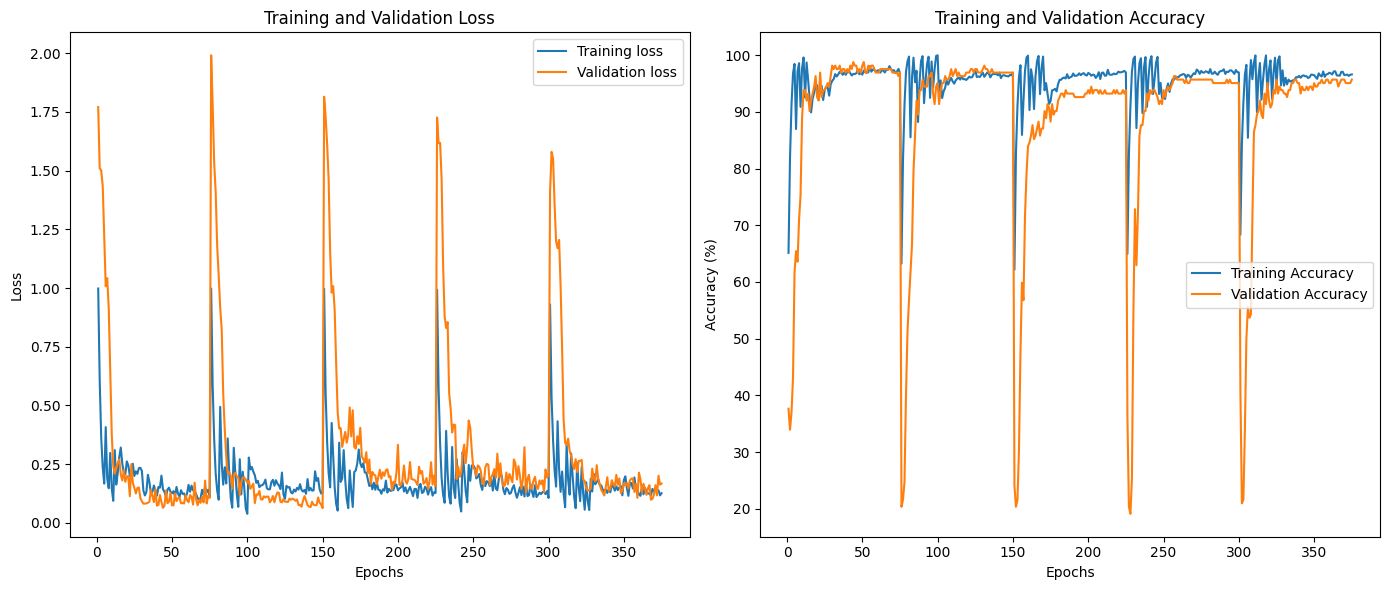

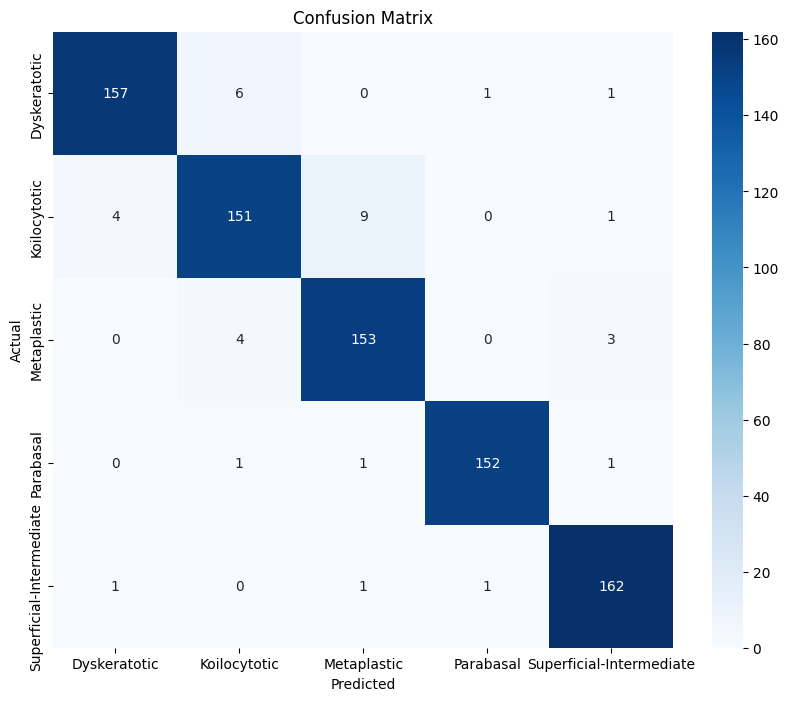

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from torchvision import transforms
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import os


def print_score(y_true, y_pred):
    print('------Weighted------')
    print('Weighted precision', precision_score(y_true, y_pred, average='weighted'))
    print('Weighted recall', recall_score(y_true, y_pred, average='weighted'))
    wf1 = f1_score(y_true, y_pred, average='weighted')
    print('Weighted f1-score', wf1)
    print('------Macro------')
    print('Macro precision', precision_score(y_true, y_pred, average='macro'))
    print('Macro recall', recall_score(y_true, y_pred, average='macro'))
    maf1 = f1_score(y_true, y_pred, average='macro')
    print('Macro f1-score', maf1)
    return wf1, maf1


def is_image_file(filename):
    return filename.endswith('.bmp')


def find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(270),
            transforms.RandomAffine(degrees=270, translate=(0.1, 0.1), shear=0.1, scale=(0.98, 1.02)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}


def train():
    model.train()
    loss, correct, total = 0.0, 0, 0
    pred_total = None
    y_total = None
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        with autocast():
            scores = model(data)
            current_loss = criterion(scores, targets)

        optimizer.zero_grad()
        scaler.scale(current_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        _, predictions = torch.max(scores, dim=1)
        loss += current_loss.item()
        total += targets.size(0)
        correct += (predictions == targets).sum().item()
        if pred_total is None:
            pred_total = predictions
            y_total = targets
        else:
            pred_total = torch.concat([pred_total, predictions], dim=0)
            y_total = torch.concat([y_total, targets], dim=0)
    batch_idx += 1
    loss /= batch_idx
    train_acc = 100 * correct / total
    print(f'Train Loss: {loss}')
    print(f'Train Acc ({total}): {train_acc}%')
    print_score(y_total.flatten().cpu(), pred_total.flatten().cpu())
    return loss, train_acc


def val():
    model.eval()
    loss, correct, total = 0.0, 0, 0
    pred_total = []
    y_total = []
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader)):
            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)
            val_loss = criterion(scores, targets)
            _, predictions = torch.max(scores, dim=1)
            loss += val_loss.item()
            total += targets.size(0)
            correct += (predictions == targets).sum().item()
            pred_total.extend(predictions.cpu().numpy())
            y_total.extend(targets.cpu().numpy())
    batch_idx += 1
    loss /= batch_idx
    accuracy = 100 * correct / total
    print(f'Val Loss: {loss}')
    print(f'Val Acc ({total}): {accuracy}%')
    print_score(np.array(y_total), np.array(pred_total))
    return loss, accuracy, y_total, pred_total


if __name__ == "__main__":
    dir = '/kaggle/input/sipakmed-dataset/SIPaKMeD dataset'
    classes, class_to_idx = find_classes(dir)
    imgs = []
    labels = []
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(dir, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_image_file(path):
                    imgs.append(path)
                    labels.append(class_index)

    skf = StratifiedKFold(n_splits=5)
    test_accuracies = []
    test_losses = []
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    all_preds = []
    all_labels = []
    all_precisions = []
    all_recalls = []
    all_f1s = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(imgs, labels)):
        print(f'Fold {fold + 1}')
        train_imgs, val_imgs = np.array(imgs)[train_idx], np.array(imgs)[val_idx]
        train_labels, val_labels = np.array(labels)[train_idx], np.array(labels)[val_idx]

        # Further split train set to create a small validation set
        train_imgs, val_imgs_inner, train_labels, val_labels_inner = train_test_split(
            train_imgs, train_labels, test_size=0.05, stratify=train_labels
        )
        settings = TolerateLossEpochsPeriod(7e-2)
        train_dataset = MyDataset(train_imgs, train_labels, transform=data_transforms['train'])
        val_dataset = MyDataset(val_imgs_inner, val_labels_inner, transform=data_transforms['val'])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = VTCNet(5).to(device)
        initialize_weights(model)
        model = nn.DataParallel(model)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=3e-2)
        scaler = GradScaler()
        train_loss = 1e5
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        best_acc = 0.0
        best_model_wts = None

        for epoch in range(num_epochs):
            scheduler.step()
            settings.step(train_loss)
            print(f'Epoch {epoch + 1}/{num_epochs}')
            train_loss, train_acc = train()
            val_loss, val_acc, _, _ = val()
            print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

            train_loss_list.append(train_loss)
            val_loss_list.append(val_loss)
            train_accuracy_list.append(train_acc)
            val_accuracy_list.append(val_acc)

        # Load best model weights from the validation phase
        model.load_state_dict(best_model_wts)

        # Evaluate the model on the final validation set (which serves as the test set for this fold)
        final_val_dataset = MyDataset(val_imgs, val_labels, transform=data_transforms['val'])
        final_val_dataloader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False)
        test_loss, test_acc, y_true, y_pred = val()

        # Record the test accuracy and loss
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)

        all_preds.extend(y_pred)
        all_labels.extend(y_true)

        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

        print(f'Fold {fold + 1}, Test Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.4f}')
        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

    # Calculate the average test accuracy, loss, precision, recall, and f1-score across all folds
    average_test_acc = np.mean(test_accuracies)
    average_test_loss = np.mean(test_losses)
    average_precision = np.mean(all_precisions)
    average_recall = np.mean(all_recalls)
    average_f1 = np.mean(all_f1s)

    print(f'Average Test Accuracy: {average_test_acc:.2f}%, Average Test Loss: {average_test_loss:.4f}')
    print(f'Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-score: {average_f1:.4f}')

    # Plot training and validation loss and accuracy
    epochs = range(1, len(train_loss_list) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Training loss')
    plt.plot(epochs, val_loss_list, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


Average Test Accuracy: 95.68%, Average Test Loss: 0.1372
Average Precision: 0.9581, Average Recall: 0.9571, Average F1-score: 0.9567


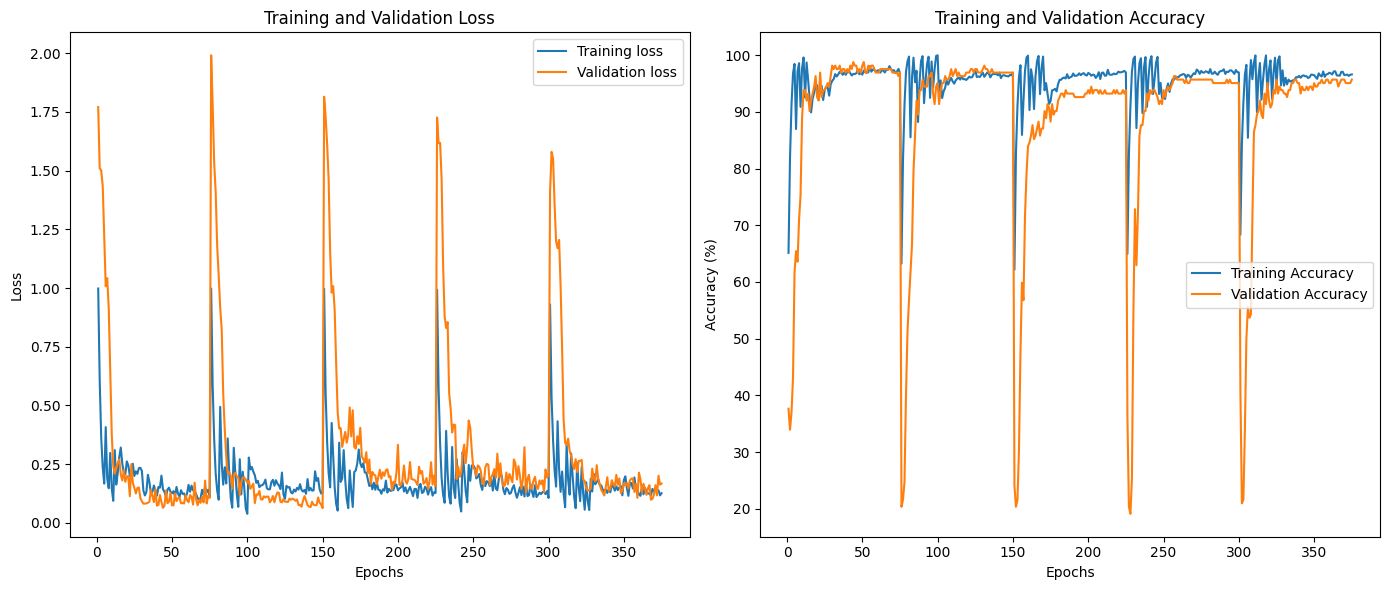

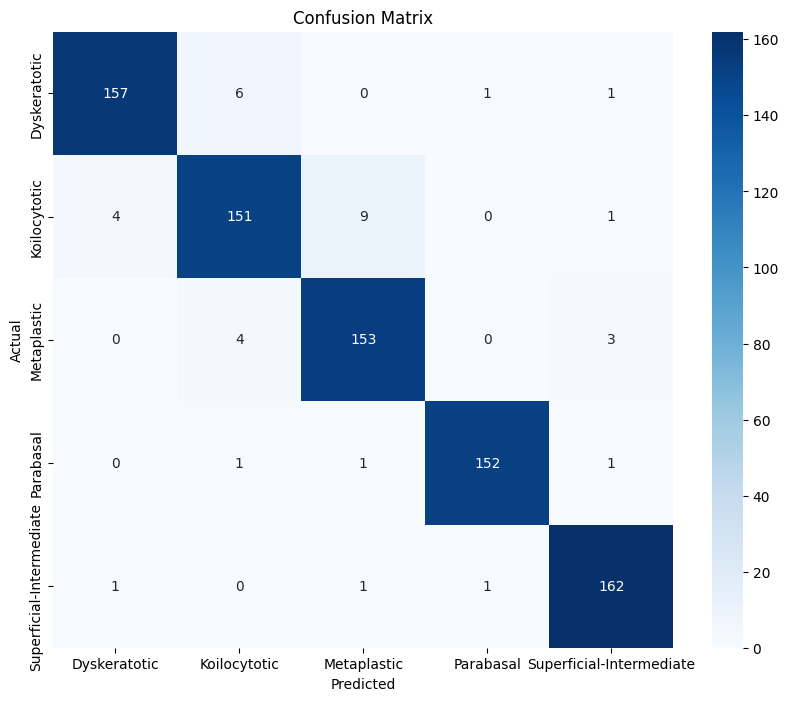

In [25]:

    print(f'Average Test Accuracy: {average_test_acc:.2f}%, Average Test Loss: {average_test_loss:.4f}')
    print(f'Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-score: {average_f1:.4f}')

    # Plot training and validation loss and accuracy
    epochs = range(1, len(train_loss_list) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Training loss')
    plt.plot(epochs, val_loss_list, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
    plt.plot(epochs, val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
